#  <span style="color:darkred">Home Credit Default Risk

## <span style="color:darkred"> Can you predict how capable each applicant is of repaying a loan?

Author: Kelli Davies

## Summary

*The goal of Home Credit Default Risk Kaggle competition was to predict which credit applicants are most likely to default on home loans.  The project here had an ROC AUC score of 0.79558 in the competition and ranked in the top 6.5% (#463 of 7198 teams), earning a bronze medal.  The top score in the competition had an ROC AUC of 0.80570.*

*One challenge to the competition was working with large datafiles with lots of missing data.  There were many features for over 300,000 loans. In the main application file, the median amount of missing data per loan was 30%.  There were several supplemental files that often  contained multiple rows for a given loan, and consequently the largest files had over a million rows. Feature engineering was important because most features needed to be summarized for a given application and most features had very little predictive power on their own.*

*The approach was to first clean up the data, removing spurious values, normalizing some skewed values such as income, and converting categorical variables to binary variables to create a numeric only dataset. New feature generation was first done by considering intuitive relationships and summary statistics (mean, median, min, max, etc) as well as weighted values for time history values.  Later, after all datasets were processed and combined, I generated more interaction features across all the data using all possible pairwise combinations.* 

*I tried several data imputation methods and also worked with normalized and standardized versions of the data.  These did not have strong benefits but in the end did provide a modest benefit to the final ROC AUC score.  I used lightGBM models with hyperparameters identified via Bayesian Optimization and relied on cross fold validation to compare the models' performances on the different permutations of the train file.  Prediction probabilities from the test file were then averaged from the best performing models to generate a stack/blended model that outperformed the individual models.*


<a id='top'></a>

## Table of Contents

**[1. Introduction- Kaggle Competition Dataset from HomeCredit](#p1)<br>**
*Description of competition and provided datafiles.*

**[2. Open Files and Calculate Fraction Missing of Data](#p2)<br>**
*An intitial look at each file provided. Summaries of file size and breakdown of missing data.*

**[3. EDA and Processing of Application Train File](#p3)<br>**
*Deeper look at the main application file. Includes clean up of data, basic data imputation and effects on correlation with target, identification of colinear variables, feature engineering, and distributions of selected variables.*

&nbsp;&nbsp;&nbsp;&nbsp;[Initial Processing - Convert Binary Variables and Record Fraction Missing](#p31)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Analysis of Missing Data - Colinear Variables](#p32)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Missing Data Imputation - Comparison of Mean, Median and Mode fill methods](#p33)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Feature Selection - Identification and Removal Colinear Variables](#p34)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Class Imbalance of Loans](#p35)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Data Visualization of Selected Variables](#p36)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Conversion of Selected Multi-level Categorical Variables to Binary Variables](#p37)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Feature Engineering  From Main Application File](#p38)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Process Test Data](#p39)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Initial Look at Feature Importances and Comparison with Correlation Values](#p310)<br>

**[4. Processing and Feature Engineering of Supplemental Data Files:](#p4)<br>**
*In this section, I first confirm that the additional files have a substantial amount of data across the loans and then proceed with processing as was done for the application file in part 2.  This section makes heavy use of aggregate data to make new summary features. Many of the files have time-related data (such as payment histories) and so weighted metrics are also generated to take into account recency.*<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Most Loans Have Data in the Supplemental Files](#p41)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Bureau Data files](#p42)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Credit Card Balance](#p43)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Installment Payments](#p44)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Previous Application](#p45)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[POS Cash Balance](#p46)<br>

**[5. Merge All Data Files](#p5)<br>**
*Consolidate all processed datafiles into a single file, creating both imputated and non-imputated versions of the data for train and test.  Calculate feature importances for the non-imputated compiled train file.*

**[6. Generation of New Features via Feature interaction](#p6)<br>**
	*Unbiased approach to new features across all datasets with merged data file: generates all pairwise multiplication, division, addition, subtraction combinations. Comparison of new feature selection based on correlation versus feature importances. I observed slight improvement to ROC AUC with feature importances based selection of new interaction features.*

**[7. Data Normalization and Standardization](#p7)<br>**
*Generate normalized and standardized versions of the data which can be used with different machine learning algorithms, data imputation methods, and for generating new interaction variables.*

**[8. Comparison of Data Imputation Methods](#p8)<br>**
*Check if MICE, softimpute, mean, median, mode, and the “Multi-fill” (selection of mean, median and mode based on best correlation as used during processing in parts 3 and 4).  Unfilled dataset outperforms imputated versions.*

**[9. Interaction Feature Engineering to Generate Final Data Sets](#p9)<br>**
*Generate interaction features as done in part 6, but on the non-imputated and standardized versions of the data.*

**[10.  Bayesian Optimization of lightGBM Classifier Hyperparameters](#p10)<br>**
*Identification of best hyperparameters for several models that make use of different boosting algorithms.*

**[11. AUC ROC Values](#p11)<br>**
*Cross validation to assess which model on which training set provides the best score.*

**[12. Model Blending/Stacking and Results](#p12)<br>**
*Discussion of how final submission was generated and the results.*

<a id='p1'></a>
## [1. Introduction:](#top)
### Competition Description (provided by Kaggle):

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

### Data File Descriptions (provided by Kaggle):

**application_{train|test}.csv**    - This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.

**bureau.csv**    - All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample). For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

**bureau_balance.csv**    - Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

**POS_CASH_balance.csv**    - Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit. This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

**credit_card_balance.csv**    - Monthly balance snapshots of previous credit cards that the applicant has with Home Credit. This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

**previous_application.csv**    - All previous applications for Home Credit loans of clients who have loans in our sample. There is one row for each previous application related to loans in our data sample.

**installments_payments.csv**    - Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

**HomeCredit_columns_description.csv**    - This file contains descriptions for the columns in the various data files.
        
<img src="home_credit.png">

<a id='p2'></a>
## [2: Open Files and Calculate Fraction Missing of Data :](#top)

Note: The large size of files in the dataset creates memory issues.  Files not presently used will be closed and deleted with the function gc.collect() .  Additionally, newly generated and altered data files will be saved to a new .csv file and closed when not needed.  

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
pd.set_option('display.max_rows', 70)
plt.style.use('fivethirtyeight')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


In [13]:
train = pd.read_csv("application_train.csv")
test = pd.read_csv("application_test.csv")
bureau = pd.read_csv("bureau.csv")
bureau_balance = pd.read_csv("bureau_balance.csv")
cc_balance = pd.read_csv("credit_card_balance.csv")
installments = pd.read_csv("installments_payments.csv")
prev_app = pd.read_csv("previous_application.csv")
cash_bal = pd.read_csv("POS_CASH_balance.csv")

In [3]:
def miss_data_sum(df, name="Data", text_sum=True):
    
    '''Returns table summary and optional text summary of missing data in dataframe '''
    
    nullc = df.isnull().sum()/df.shape[0]
    nullc = nullc[nullc>0]
    
    if text_sum:
        print("\nThe {} file consists of {} columns and {} rows".format(str(name), str(df.shape[1]), 
                                                                str(df.shape[0])))
        print("{} columns have missing data".format(len(nullc)))
    
    if len(nullc) > 0:
        amnt_col20 = len(nullc[nullc>0.20])
        nullc.sort_values(ascending=False, inplace=True)
        nulldfc = pd.DataFrame(nullc).reset_index()
        nulldfc.columns = ['Feature', 'Fraction Missing']
        nullr = df.isnull().sum(axis=1)/df.shape[1]
        nullr_med = nullr.median()
        
        if text_sum:
            print("{} columns have greater than 20% missing data".format(amnt_col20))
            print("The average (median) row has {}% missing data".format(np.round(nullr_med*100)))
            print("Columns with Missing Data:")
        return nulldfc
    else:
          return None

In [15]:
miss_data_sum(train, "train")


The train file consists of 122 columns and 307511 rows
67 columns have missing data
50 columns have greater than 20% missing data
The average (median) row has 30.0% missing data
Columns with Missing Data:


,Feature,Fraction Missing
0,COMMONAREA_MEDI,0.698723
1,COMMONAREA_AVG,0.698723
2,COMMONAREA_MODE,0.698723
3,NONLIVINGAPARTMENTS_AVG,0.694330
4,NONLIVINGAPARTMENTS_MODE,0.694330
5,NONLIVINGAPARTMENTS_MEDI,0.694330
6,FONDKAPREMONT_MODE,0.683862
7,LIVINGAPARTMENTS_AVG,0.683550
8,LIVINGAPARTMENTS_MEDI,0.683550
9,LIVINGAPARTMENTS_MODE,0.683550


In [16]:
miss_data_sum(test, "test")


The test file consists of 121 columns and 48744 rows
64 columns have missing data
50 columns have greater than 20% missing data
The average (median) row has 25.0% missing data
Columns with Missing Data:


,Feature,Fraction Missing
0,COMMONAREA_MODE,0.687161
1,COMMONAREA_AVG,0.687161
2,COMMONAREA_MEDI,0.687161
3,NONLIVINGAPARTMENTS_MEDI,0.684125
4,NONLIVINGAPARTMENTS_AVG,0.684125
5,NONLIVINGAPARTMENTS_MODE,0.684125
6,FONDKAPREMONT_MODE,0.672842
7,LIVINGAPARTMENTS_MODE,0.672493
8,LIVINGAPARTMENTS_AVG,0.672493
9,LIVINGAPARTMENTS_MEDI,0.672493


In [17]:
bureau_miss = miss_data_sum(bureau, "bureau")
bureau_miss


The bureau file consists of 17 columns and 1716428 rows
7 columns have missing data
4 columns have greater than 20% missing data
The average (median) row has 12.0% missing data
Columns with Missing Data:


,Feature,Fraction Missing
0,AMT_ANNUITY,0.714735
1,AMT_CREDIT_MAX_OVERDUE,0.655133
2,DAYS_ENDDATE_FACT,0.369170
3,AMT_CREDIT_SUM_LIMIT,0.344774
4,AMT_CREDIT_SUM_DEBT,0.150119
5,DAYS_CREDIT_ENDDATE,0.061496
6,AMT_CREDIT_SUM,0.000008


In [18]:
miss_data_sum(bureau_balance, "bureau_balance")


The bureau_balance file consists of 3 columns and 27299925 rows
0 columns have missing data


In [19]:
miss_data_sum(cc_balance, "cc_balance")


The cc_balance file consists of 23 columns and 3840312 rows
9 columns have missing data
0 columns have greater than 20% missing data
The average (median) row has 0.0% missing data
Columns with Missing Data:


,Feature,Fraction Missing
0,AMT_PAYMENT_CURRENT,0.199981
1,CNT_DRAWINGS_POS_CURRENT,0.195249
2,CNT_DRAWINGS_OTHER_CURRENT,0.195249
3,CNT_DRAWINGS_ATM_CURRENT,0.195249
4,AMT_DRAWINGS_POS_CURRENT,0.195249
5,AMT_DRAWINGS_OTHER_CURRENT,0.195249
6,AMT_DRAWINGS_ATM_CURRENT,0.195249
7,CNT_INSTALMENT_MATURE_CUM,0.079482
8,AMT_INST_MIN_REGULARITY,0.079482


In [20]:
miss_data_sum(installments, "installments")


The installments file consists of 8 columns and 13605401 rows
2 columns have missing data
0 columns have greater than 20% missing data
The average (median) row has 0.0% missing data
Columns with Missing Data:


,Feature,Fraction Missing
0,AMT_PAYMENT,0.000214
1,DAYS_ENTRY_PAYMENT,0.000214


In [21]:
miss_data_sum(prev_app, "prev_app")


The prev_app file consists of 37 columns and 1670214 rows
16 columns have missing data
14 columns have greater than 20% missing data
The average (median) row has 11.0% missing data
Columns with Missing Data:


,Feature,Fraction Missing
0,RATE_INTEREST_PRIVILEGED,9.964370e-01
1,RATE_INTEREST_PRIMARY,9.964370e-01
2,RATE_DOWN_PAYMENT,5.363648e-01
3,AMT_DOWN_PAYMENT,5.363648e-01
4,NAME_TYPE_SUITE,4.911975e-01
5,NFLAG_INSURED_ON_APPROVAL,4.029813e-01
6,DAYS_TERMINATION,4.029813e-01
7,DAYS_LAST_DUE,4.029813e-01
8,DAYS_LAST_DUE_1ST_VERSION,4.029813e-01
9,DAYS_FIRST_DUE,4.029813e-01


In [22]:
miss_data_sum(cash_bal, "cash_bal")


The cash_bal file consists of 8 columns and 10001358 rows
2 columns have missing data
0 columns have greater than 20% missing data
The average (median) row has 0.0% missing data
Columns with Missing Data:


,Feature,Fraction Missing
0,CNT_INSTALMENT_FUTURE,0.002608
1,CNT_INSTALMENT,0.002607


In [23]:
# Delete variables to free up memory
del test
del bureau 
del bureau_balance
del cc_balance
del installments
del prev_app
del cash_bal
gc.collect()

5658

There is a lot of missing data in many of the provided data files, particularly the main application train and test files, the previous application file, and the bureau file. Dropping missing data would remove a lot of the data, and so data imputation or use of machine learning algorithms that allow NA values will be necessary. The train and test application files have similar amounts of missing data across variables, consistent with the files coming from similar distributions.  I will begin with cleaning up looking further at the train file.

<a id=‘p3’></a>

<a id='p3'></a>
## [3. EDA and Processing of Main Application Train File](#top)

<a id='p31'></a>
## [Initial Processing:](#top)
### Convert "Y" / "N" entries to binary variables

There are several categorical "Yes"/ "No" variables.  Most of these, such as "FLAG_MOBILE" are already entered as 0 for no and 1 for yes.  Others, such as "EMERGENCYSTATE_MODE" have "Yes" and "No" responses (as well as NaN) entered as object type data.  The data will be converted to 0 (no) and 1 (yes) numerical entries for easier processing before proceeding with filling in missing data. 

In [5]:
def yn_to_num(df):
    yes_no_cols = [c for c in df.columns.tolist() if (("Y" in df[c].unique()) or 
                                                     "Yes" in df[c].unique())]
    print("Columns to convert:")
    print(yes_no_cols)

    for c in yes_no_cols:
        df[c].replace(['No','N'], [0, 0], inplace=True)
        df[c].replace(['Yes', 'Y'], [1, 1], inplace=True)
    return df

In [6]:
train = pd.read_csv("application_train.csv")
train = yn_to_num(train)

Columns to convert:
['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE']


There were three columns (listed above) to convert.

### Add New Feature - frac_missing_train

Before proceeding with analysis and filling in of missing data, the amount of missing data per applicant will be recorded.  Applicants with less complete loan applications may be more or less likely to default on their loans.  If the feature does turn out to be a good predictor of loan defaults, it may be worthwhile going back and determining if missing information on specific subsets of the loan application provides a stronger indication of whether an individual will default. 

In [85]:
train["frac_missing_mainapp"] = train.isnull().sum(axis=1)/train.shape[1]

<a id='p32'></a>
### [Analysis of Missing Data - Colinear Variables](#top)

In the train file there is a large amount of missing data; 67 of the 122 features have missing data, and 50 features have more than 20% Data.  Missing data can be left as is, dropped, or filled in with averages or predictions based on other metrics.   

Interestingly, several of the variables in the missing data are different average statistics of the same measurement and are potentially colinear (highly redundant) with one another.  For example, the top three features with missing data are: COMMONAREA_MEDI, COMMONAREA_AVG, and COMMONAREA_MODE all with 69.8% missing data.  These related features all have the same missing data percentages, indicating that they are likely all missing or all present for a given observation. If instead, individual observations tend to be missing data for only a subset of _AVG, _MEDI, or _MODE, the available feature information can be used to more accurately fill in the data for the missing features in the dataset.  I will check whether observations with missing data for a _MEDI statistic are also missing data for _AVG and _MODE Statistics:

In [7]:
train_missing = miss_data_sum(train, "train", text_sum=False)
train_cols_missing = train_missing["Feature"].tolist()
check_redund_cols = [i for i in train_cols_missing if ("_AVG" in i) or ("_MEDI" in i) or ("_MODE" in i)]
train[check_redund_cols][0:20]

,COMMONAREA_MEDI,COMMONAREA_AVG,COMMONAREA_MODE,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MODE,NONLIVINGAPARTMENTS_MEDI,FONDKAPREMONT_MODE,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,...,LIVINGAREA_AVG,HOUSETYPE_MODE,FLOORSMAX_MODE,FLOORSMAX_MEDI,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BEGINEXPLUATATION_AVG,TOTALAREA_MODE,EMERGENCYSTATE_MODE
0,0.0144,0.0143,0.0144,0.0000,0.0000,0.0000,reg oper account,0.0202,0.0205,0.0220,...,0.0190,block of flats,0.0833,0.0833,0.0833,0.9722,0.9722,0.9722,0.0149,0.0
1,0.0608,0.0605,0.0497,0.0039,0.0000,0.0039,reg oper account,0.0773,0.0787,0.0790,...,0.0549,block of flats,0.2917,0.2917,0.2917,0.9851,0.9851,0.9851,0.0714,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Unfortunately, for the above features with missing values, it looks like closely related features (eg., COMMON_AREA (suffix _MEDI, _MODE, _AVG)) are also missing. 
The data can be filled in with either using average metrics (mean, median, or mode), or a more sophisticated imputation based on other feature values (such as MICE), both of which will be explored later. 

Many of the features above have highly similar values and are therefore correlative/colinear that contribute redundant information, meaning that we can keep one of the three statistics for a given measurement for a simpler model.  This will be analyzed further in a subsequent section.

<a id='p33'></a>
### [Missing Data Imputation - Comparison of Mean,  Median, and Mode Fill methods](#top)

It can be difficult to work with data that has lots of missing values. Currently, we do not know which of the features are informative for predicting loan defaults.  For the features with missing values, we will check whether there is an evidence for a positive or negative association with loan default status using the corr() function:

In [87]:
def check_correlations(cols, complete_df, null_df=None, method_choice='spearman'):
    
    '''Checks for correlation between feature list and target
    using the the corr() function.  Returns dataframe.  Option to merge information 
    regarding NaN data if df from miss_data_sum also provided as input'''
    
    correlations = np.round(complete_df[cols].corr(method=method_choice)["TARGET"],3)
    order = correlations.map(lambda x :np.abs(x)).sort_values(ascending = False)

    correlations = pd.DataFrame(correlations[order.index]).reset_index()
    correlations.columns = ['Feature', 'Correlation with TARGET']

    if null_df is not None:
        correlationsmerged = correlations.merge(null_df, how='left', on='Feature')
        correlationsmerged.fillna(0, inplace=True)
        return correlationsmerged 

    else:
        return correlations

In [88]:
train_cols_missing = train_missing["Feature"].tolist()
train_cols_missing.append("TARGET")

train_missing_corrs = check_correlations(train_cols_missing, train, train_missing)
train_missing_corrs

,Feature,Correlation with TARGET,Fraction Missing
0,TARGET,1.000,0.000000
1,EXT_SOURCE_3,-0.166,0.198253
2,EXT_SOURCE_1,-0.151,0.563811
3,EXT_SOURCE_2,-0.147,0.002146
4,DAYS_LAST_PHONE_CHANGE,0.054,0.000003
5,OWN_CAR_AGE,0.053,0.659908
6,FLOORSMAX_MEDI,-0.046,0.497608
7,FLOORSMAX_AVG,-0.046,0.497608
8,FLOORSMAX_MODE,-0.045,0.497608
9,LIVINGAREA_AVG,-0.042,0.501933


Based on the Correlation Data of cols with missing values, the EXT_SOURCE features (suffixes _1, _2, _3), have the most significant correlation with Target (Spearman Correlation from -.147 to - 0.166).  Although EXT_SOURCE_1 has a large amount of missing data (56%), its strong correlation argues it may still be of  significant value in the analysis.  The next significant correlation is Days_Last_Phone_Change, with a correlation of +0.054.  This feature has very little missing data (<0.1%).  Several features have correlation values of ~0. 

The major limitation of the correlation method is that it considers linear (or in this case with Spearman, monotonically increasing/decreasing) associations only, meaning features above with low/no correlation cannot be confidently dismissed as having no association with the Target. Later analysis with decision trees and feature importances will provide additional information as to whether these are significant explanatory variables.  

For now, the correlations values provide some indication of what variables may be more predictive.  Additionally, the correlations provide a baseline to determine the affects of data imputation on variable relationship with target. The features will be filled with average statistics for the feature (mean, median, and mode), and the exent to which the resulting correlation with the target is altered will be calculated in the proceeding section.

In [89]:
def fillna_func(df):
    
    '''Fills na of dataframe using pandas.fillna using three methods: mean, median, mode
    Returns dataframe for each method will filled values '''
    
    df_mea = df.fillna(df.mean())
    df_med = df.fillna(df.median())
    df_mod = df.fillna(df.mode().iloc[0])
    
    return df_mea, df_med, df_mod

Train will be filled in using the function above and the success of each fill method will be checked by calculating the missing data in the resulting dataframes.  

In [90]:
train_fill_mea, train_fill_med, train_fill_mod = fillna_func(train[train_cols_missing])

print(miss_data_sum(train_fill_mea, "Mean-based fillna train"))
print(miss_data_sum(train_fill_med, "Median-based fillna train"))
miss_data_sum(train_fill_mod, "Mode-based fillna train")


The Mean-based fillna train file consists of 68 columns and 307511 rows
5 columns have missing data
4 columns have greater than 20% missing data
The average (median) row has 4.0% missing data
Columns with Missing Data:
              Feature  Fraction Missing
0  FONDKAPREMONT_MODE          0.683862
1  WALLSMATERIAL_MODE          0.508408
2      HOUSETYPE_MODE          0.501761
3     OCCUPATION_TYPE          0.313455
4     NAME_TYPE_SUITE          0.004201

The Median-based fillna train file consists of 68 columns and 307511 rows
5 columns have missing data
4 columns have greater than 20% missing data
The average (median) row has 4.0% missing data
Columns with Missing Data:
              Feature  Fraction Missing
0  FONDKAPREMONT_MODE          0.683862
1  WALLSMATERIAL_MODE          0.508408
2      HOUSETYPE_MODE          0.501761
3     OCCUPATION_TYPE          0.313455
4     NAME_TYPE_SUITE          0.004201

The Mode-based fillna train file consists of 68 columns and 307511 rows
0 col

The fill methods were successful; for the mode fillna, all the columns were filled while for the mean and median fill methods, all but non-numerical (multi-level object type categorical variables) were filled. In the next sections, the feature correlation with target is calculated on the filled data.  The correlations tables are then merged for a side-by-side comparison of the effects of the different fills on discerning data trends and relationships.

In [91]:
train_corrs_mea = check_correlations(train_cols_missing, train_fill_mea)
train_corrs_med = check_correlations(train_cols_missing, train_fill_med)
train_corrs_mod = check_correlations(train_cols_missing, train_fill_mod)

del train_fill_mea
del train_fill_med
del train_fill_mod
gc.collect()

1043

In [92]:
def merge_dataframes(dataframes, merge_on, how_to='left'):
    '''Merges a list of dataframes in the order given on the column provided'''
    dfm = dataframes[0]
    for df in dataframes[1:]:
        dfm=dfm.merge(df, how=how_to, on=merge_on)
    return dfm

In [93]:
fillna_correlations = merge_dataframes([train_corrs_mea, train_corrs_med, train_corrs_mod,
                                        train_missing_corrs], "Feature")

fillna_correlations.columns = ["Feature", "corr Mean Fill", "corr Median Fill", "corr Mode Fill", 
                               "corr No NaFill", "Frac NaN"]

fillna_correlations["Best fill"] = fillna_correlations[["corr Mean Fill", "corr Median Fill", 
                                                "corr Mode Fill"]].abs().idxmax(axis=1)
fillna_correlations["Best fill"] = fillna_correlations["Best fill"].str.replace("corr ", "")
fillna_correlations = fillna_correlations.drop([0])
fillna_correlations.set_index("Feature", drop=True, append=False, inplace=True)

del train_corrs_mea
del train_corrs_med
del train_corrs_mod
gc.collect()

fillna_correlations

,corr Mean Fill,corr Median Fill,corr Mode Fill,corr No NaFill,Frac NaN,Best fill
Feature,,,,,,
EXT_SOURCE_2,-0.147,-0.147,-0.147,-0.147,0.002146,Mean Fill
EXT_SOURCE_3,-0.144,-0.141,-0.103,-0.166,0.198253,Mean Fill
EXT_SOURCE_1,-0.086,-0.085,-0.092,-0.151,0.563811,Mode Fill
DAYS_LAST_PHONE_CHANGE,0.054,0.054,0.054,0.054,0.000003,Mean Fill
EMERGENCYSTATE_MODE,0.042,0.005,0.005,0.012,0.473983,Mean Fill
OWN_CAR_AGE,0.034,0.030,0.022,0.053,0.659908,Mean Fill
YEARS_BEGINEXPLUATATION_MODE,-0.033,-0.016,0.006,-0.027,0.487810,Mean Fill
AMT_REQ_CREDIT_BUREAU_DAY,0.033,0.004,0.004,0.005,0.135016,Mean Fill
AMT_REQ_CREDIT_BUREAU_HOUR,0.032,-0.000,-0.000,0.001,0.135016,Mean Fill


The correlation was not significantly altered for many features with the filling.  As expected, correlations were reduced more strongly for features with a greater percentage of missing data.  For example, EXT_SOURCE_1 had 56% missing data and the best fill method (mode) dropped its correlation with TARGET from 0.15 to 0.09.  The EXT_SOURCE_3, which had 20% missing data had a more modest r correlation drop from 0.17 to 0.14 with the best fill method (mean). 

Interestingly, for a few features, such as AMT_REQ_CREDIT_BUREAU_HOUR with a relatively low amount of missing data (13.5%), the correlation strength increased from -0.008 to 0.014. This final correlation value is still very low in terms of strength and likely results from noise rather than a true association with the target.  

For some features, the correlation was similar among the different fill methods while for other features the choice of fill significantly impacted the final correlation value.  The fill method (mean, median, mode) that provided the strongest correlation will be used to fill on an individual feature basis.  For non-numerical multi-level categorical variables (which do not have correlations above), the mode fill option will be used since it is the only option. 

In [94]:
def best_fill_na(df, df_corr):
    
    '''Uses correlation dataframe with Best Fill col to fill missing values in df
    Returns filled df and dictionary with missing values that were imputed. 
    The dictionary is returned because it will allow for fill of test data file'''
    
    cols_mean_fill = df_corr[df_corr["Best fill"] == "Mean Fill"].index.tolist()
    cols_med_fill = df_corr[df_corr["Best fill"] == "Median Fill"].index.tolist()
    cols_mode_fill = df_corr[df_corr["Best fill"] == "Mode Fill"].index.tolist()

    miss_value_d = {}

    for c in cols_mean_fill:
        value = df[c].mean()
        miss_value_d[c] = value
        df[c] = df[c].fillna(value)

    for c in cols_med_fill:
        value = df[c].median()
        miss_value_d[c] = value
        df[c] = df[c].fillna(value)

    for c in cols_mode_fill:
        value = df[c].mode().iloc[0]
        miss_value_d[c] = value
        df[c] = df[c].fillna(value)
    
    return df, miss_value_d

In [95]:
train_filled, application_miss_value_d = best_fill_na(train[train.columns.tolist()], 
                                                      fillna_correlations)



object_type_missing_data = ["FONDKAPREMONT_MODE", 'WALLSMATERIAL_MODE', 'OCCUPATION_TYPE', 
                            'HOUSETYPE_MODE', 'NAME_TYPE_SUITE']


for c in object_type_missing_data:
    value = train_filled[c].mode().iloc[0]
    application_miss_value_d[c] = value
    train_filled[c] = train_filled[c].fillna(value)
    
miss_data_sum(train_filled, "Train Filled")


The Train Filled file consists of 123 columns and 307511 rows
0 columns have missing data


In [96]:
miss_value_df = pd.DataFrame.from_dict(application_miss_value_d, orient='index')
miss_value_df.columns=["Fill_Value"]
#miss_value_df.to_csv("app_miss_valued_20180716.csv")  #append date before running
#train_filled.to_csv("app_train_filled_allfeatures_20180716.csv")
miss_value_df.head()

,Fill_Value
EXT_SOURCE_2,0.514393
EXT_SOURCE_3,0.510853
DAYS_LAST_PHONE_CHANGE,-962.859
EMERGENCYSTATE_MODE,0.014392
OWN_CAR_AGE,12.0611


In [97]:
del train
del fillna_correlations
gc.collect()

22

<a id='p34'></a>

### [Feature Selection - Identification and Removal of Colinear Variables](#top)

As discussed earlier, there are several variables that report very similar information (such as normalized home information reported as mean, median, and mode).  There are a lot of features in the data, and so to allow for a more manageable file, highly redundant/ colinear variables (correlation > 0.9) will be removed.

In [99]:
def corr_matrix(df, cols):
    print("Colinear Variable Analysis:")
    plt.figure(figsize=(9,9))
    cols = sorted(cols)
    correlations = df[cols].corr(method='spearman').round(decimals=1)
    ax = sns.heatmap(correlations, annot=True, annot_kws={"size": 13})
    plt.show()
    
    if "TARGET" not in cols:
        cols.append("TARGET")
    correlation_with_target = df[cols].corr(method='spearman').round(decimals=4)["TARGET"]
    print("Correlation of Features with TARGET")
    return correlation_with_target

Colinear Variable Analysis:


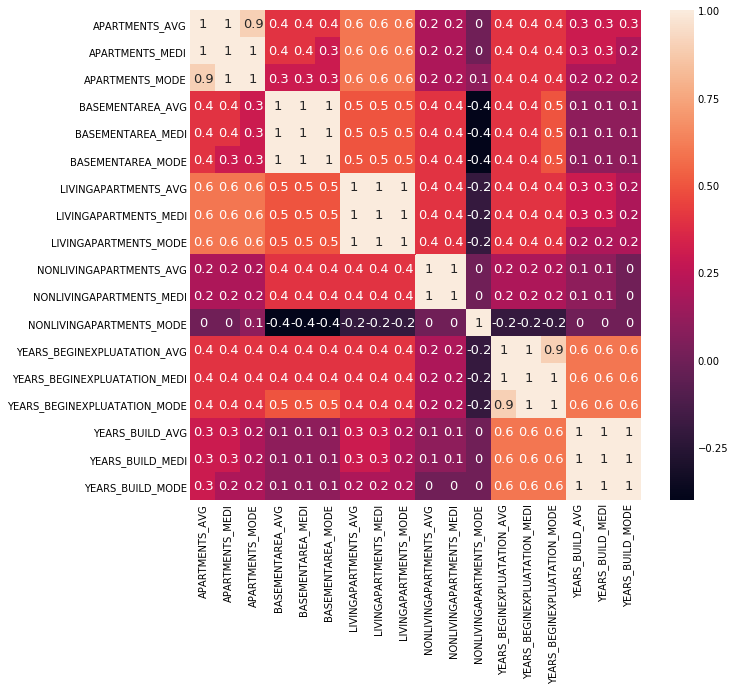

Correlation of Features with TARGET


APARTMENTS_AVG                 -0.0234
APARTMENTS_MEDI                -0.0226
APARTMENTS_MODE                -0.0196
BASEMENTAREA_AVG               -0.0381
BASEMENTAREA_MEDI              -0.0380
BASEMENTAREA_MODE              -0.0371
LIVINGAPARTMENTS_AVG           -0.0276
LIVINGAPARTMENTS_MEDI          -0.0272
LIVINGAPARTMENTS_MODE          -0.0256
NONLIVINGAPARTMENTS_AVG        -0.0185
NONLIVINGAPARTMENTS_MEDI       -0.0176
NONLIVINGAPARTMENTS_MODE        0.0164
YEARS_BEGINEXPLUATATION_AVG    -0.0297
YEARS_BEGINEXPLUATATION_MEDI   -0.0296
YEARS_BEGINEXPLUATATION_MODE   -0.0326
YEARS_BUILD_AVG                -0.0112
YEARS_BUILD_MEDI               -0.0111
YEARS_BUILD_MODE               -0.0102
TARGET                          1.0000
Name: TARGET, dtype: float64

In [100]:
check_colin_cols_set1 = [i for i in train_filled if ("APARTMENTS_" in i) or 
                          ("BASEMENTAREA_" in i) or ("YEARS_BEGINEXPLUATATION_" in i) or
                         ("YEARS_BUILD_" in i)]

corr_matrix(train_filled, check_colin_cols_set1)

With the exception of NONLIVINGAPARTMENTS_MODE, there is a substantial correlation between the average, mean, and median statistics for a given measurement.  Correlation values are 0.9 or greater for most of the above, indicating redundancy. 

The NONLIVINGAPARTMENTS triad was markedly different from the others, in that the _MODE variable did not correlate with the other two.  In an above section (Analysis of Missing Data - Colinear Variables), the first 50 rows for these features (and others) were printed.  One can see that there is often a "zero" value (note: not a np.Nan) for the _MODE of NONLIVINGAPARTMENT while the _MEDI _AVG of the measurement have non-negative values that are very close to each other, which explains why we observed the departure from collinearity above. There may be something inconsistent with how the _MODE data was collected.  

For the collinear variable sets, which should be retained?  The feature with the greatest correlation with the TARGET will be retained using the correlation table above. If there is a tie, the variables are at this point interchangeable and the first in the list will be kept. 

In the code below, redundant variables are removed and two additional sets of potential collinear variables are analyzed, as above. 

Colinear Variable Analysis:


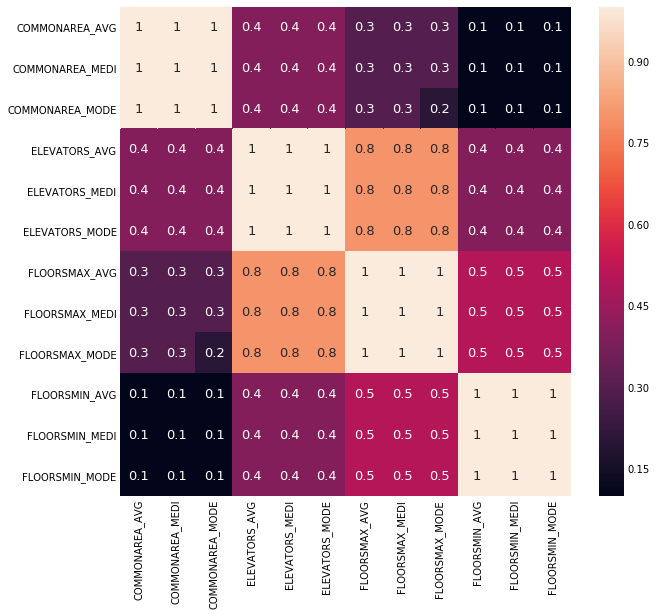

Correlation of Features with TARGET
COMMONAREA_AVG    -0.0274
COMMONAREA_MEDI   -0.0272
COMMONAREA_MODE   -0.0267
ELEVATORS_AVG     -0.0416
ELEVATORS_MEDI    -0.0412
ELEVATORS_MODE    -0.0400
FLOORSMAX_AVG     -0.0372
FLOORSMAX_MEDI    -0.0368
FLOORSMAX_MODE    -0.0357
FLOORSMIN_AVG     -0.0174
FLOORSMIN_MEDI    -0.0173
FLOORSMIN_MODE    -0.0161
TARGET             1.0000
Name: TARGET, dtype: float64
Colinear Variable Analysis:


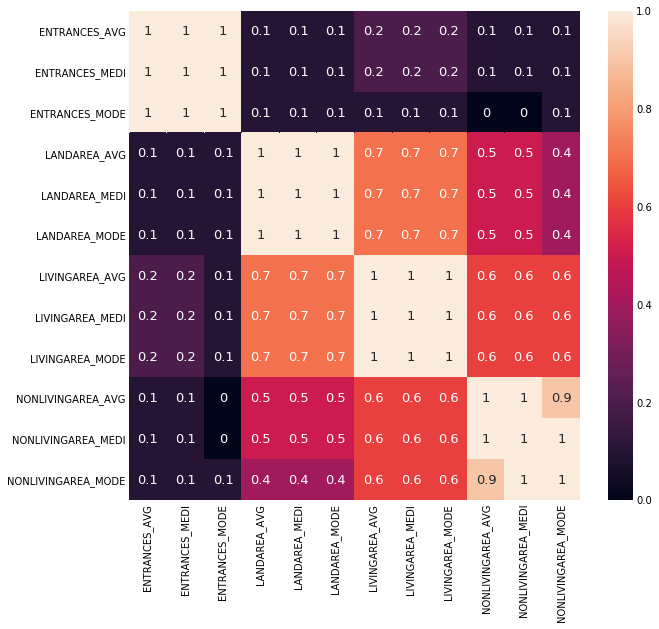

Correlation of Features with TARGET
ENTRANCES_AVG        -0.0128
ENTRANCES_MEDI       -0.0127
ENTRANCES_MODE       -0.0096
LANDAREA_AVG         -0.0303
LANDAREA_MEDI        -0.0301
LANDAREA_MODE        -0.0293
LIVINGAREA_AVG       -0.0468
LIVINGAREA_MEDI      -0.0466
LIVINGAREA_MODE      -0.0462
NONLIVINGAREA_AVG    -0.0317
NONLIVINGAREA_MEDI   -0.0308
NONLIVINGAREA_MODE   -0.0294
TARGET                1.0000
Name: TARGET, dtype: float64


In [101]:
cols_to_drop = ["APARTMENTS_MEDI", "APARTMENTS_MODE", "BASEMENTAREA_MEDI", "BASEMENTAREA_MODE",
                "LIVINGAPARTMENTS_MEDI", "LIVINGAPARTMENTS_MODE", "NONLIVINGAPARTMENTS_MEDI",
                "YEARS_BEGINEXPLUATATION_AVG", "YEARS_BEGINEXPLUATATION_MEDI", "YEARS_BUILD_MEDI",
                "YEARS_BUILD_MODE"]

train_filled.drop(cols_to_drop, axis=1, inplace=True)
                
check_colin_cols_set2 = [i for i in train_filled if ("COMMONAREA_" in i) or 
                          ("ELEVATORS_" in i) or ("FLOORSMIN_" in i) or
                         ("FLOORSMAX_" in i)]

check_colin_cols_set3 = [i for i in train_filled if ("LANDAREA_" in i) or 
                          ("ENTRANCES_" in i) or ("LIVINGAREA_" in i)]

print(corr_matrix(train_filled, check_colin_cols_set2))
print(corr_matrix(train_filled, check_colin_cols_set3))                

As before, we see the _AVG, _MED, and _MODE values for a given measurement are highly correlated.  Of the three, the value that correlates best with the target will be retained in the data set. The analysis has allowed us to remove 27 features in total from the train dataset.

The above analysis focused on features that, based on their description, were very likely to be redundant measurements.  It's possible that there are other colinear features as well and the heatmaps above allow for some examination of additional colinearity within the subsets.  For example, the FLOORSMAX  metrics and ELEVATORS metrics (mean, median, average) highly correlate with each other, with correlation of 0.8.  This relationship makes sense as buildings with more floors have more elevators. The value of 0.8 is high a correlation, but not nearly as high as the clearly colinear variables, meaning it is not as redundant.  

There are other values that that may potentially be colinear.  Notably, there are three variables related to the clients' normalized score data from external sources and four variables related to days past due defaults in the client's social circle in the past 30 and 60 days. Additionally there are four metrics about frequency of credit enquiries. These features will also be checked for potential colinearity:

Colinear Variable Analysis:


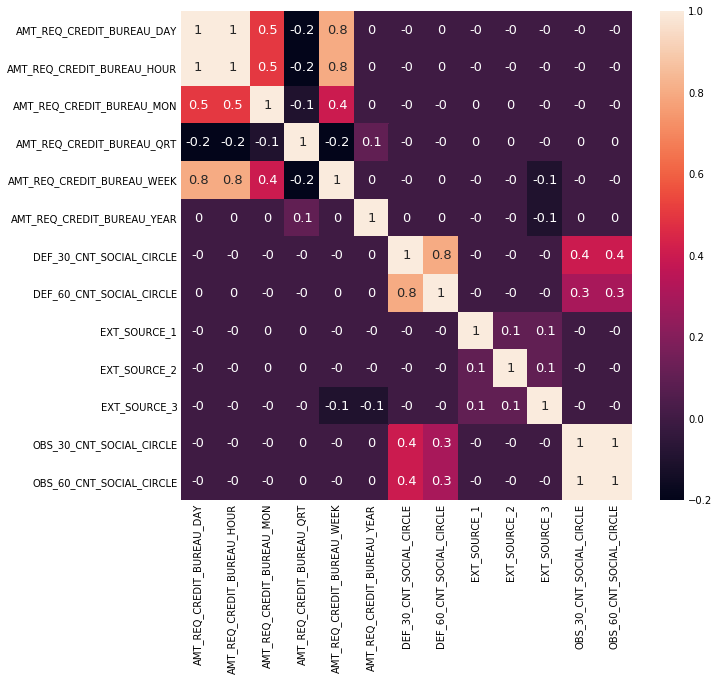

Correlation of Features with TARGET
AMT_REQ_CREDIT_BUREAU_DAY     0.0330
AMT_REQ_CREDIT_BUREAU_HOUR    0.0321
AMT_REQ_CREDIT_BUREAU_MON     0.0113
AMT_REQ_CREDIT_BUREAU_QRT    -0.0135
AMT_REQ_CREDIT_BUREAU_WEEK    0.0287
AMT_REQ_CREDIT_BUREAU_YEAR    0.0183
DEF_30_CNT_SOCIAL_CIRCLE      0.0324
DEF_60_CNT_SOCIAL_CIRCLE      0.0310
EXT_SOURCE_1                 -0.0925
EXT_SOURCE_2                 -0.1471
EXT_SOURCE_3                 -0.1445
OBS_30_CNT_SOCIAL_CIRCLE      0.0098
OBS_60_CNT_SOCIAL_CIRCLE      0.0097
TARGET                        1.0000
Name: TARGET, dtype: float64


In [102]:
cols_to_drop = ["COMMONAREA_MEDI", "COMMONAREA_MODE", "ELEVATORS_MEDI", "ELEVATORS_MODE",
                "ENTRANCES_MEDI", "ENTRANCES_MODE", "FLOORSMAX_MEDI", "FLOORSMAX_MODE",
                "FLOORSMIN_MEDI", "FLOORSMIN_MODE", "LANDAREA_MEDI", "LANDAREA_MODE", 
                "NONLIVINGAREA_MEDI", "NONLIVINGAREA_MODE", "LIVINGAREA_MEDI", "LIVINGAREA_MODE"]

train_filled.drop(cols_to_drop, axis=1, inplace=True)

check_colin_cols_set4 = [i for i in train_filled if ("EXT_SOURCE_" in i) or 
                          ("SOCIAL_CIRCLE" in i) or ("AMT_REQ_CREDIT" in i)]

print(corr_matrix(train_filled, check_colin_cols_set4))

It looks like the AMT_REQ_CREDIT_BUREAU_DAY and AMT_REQ_CREDIT_BUREAU_HOUR are redundant, as are the OBS_30_CNT_SOCIAL_CIRCLE and OBS_60_CNT_SOCIAL_CIRCLE.   The EXT_SOURCE metrics had very little correlation.  One argument for retention of redundant variables is the high amount of missing data in the dataset.  If data is missing for one of the two redundant variables, the data is arguably no longer "redundant" for the one that remains.  As seen in previous analysis (Analysis of Missing Data - Colinear Variable), for most of the closely related variables, the data was either missing or present for all.  If a feature turns out to be particularly important later in the analysis, its closely related dropped feature(s) will be re-evaluted for inclusion in the model. 

Other metrics, such as the FLAG_DOCUMENT (1, 2, ... 21) were also examined for colinearity, and strong correlations were not observed (data not shown).  

In [103]:
cols_to_drop = ["AMT_REQ_CREDIT_BUREAU_HOUR",  "OBS_60_CNT_SOCIAL_CIRCLE"]
train_filled.drop(cols_to_drop, axis=1, inplace=True)

In [1]:
#train_filled.to_csv('app_train_filled_colinear_removed20180716.csv') #append date

<a id='p35'></a>
### [Class Imbalance of Loans](#top)

There are now no longer missing values in the Train file and colinear features have been removed.  Next, visualization of the target and potentially explanatory variables will be used to better understand relationships among the data.  First, the frequency of loan defaults in the data is calculated to check for class imbalance:  

24825 of 307511 loans defaulted.  This corresponds to 8.1%


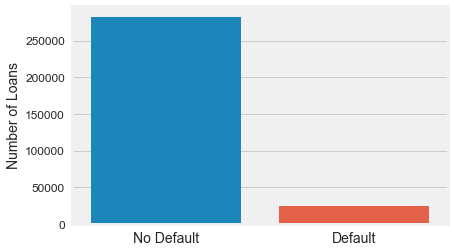

In [7]:
counts = train_filled["TARGET"].value_counts()
freq = np.round(100*counts[1]/counts.sum(), decimals=1)

print("{} of {} loans defaulted.  This corresponds to {}%".format(counts[1], counts.sum(), freq))

plt.figure()
bar = sns.barplot(x = counts.index, y=counts.values)
bar.set_xticklabels(["No Default", "Default"])
bar.xaxis.set_tick_params(labelsize=14)
bar.yaxis.set_tick_params(labelsize=12)
bar.set_ylabel('Number of Loans', fontsize=14)
plt.show()


There is clearly a class imbalance in the data, with only 8.1% of the total data containing loan defaults.  

<a id='p36'></a>
### [Data Visualization of Selected Variables](#top)

Next, Features from the Train Data Set will be analyzed to understand the distributions and relationships with the target.  New Features will be engineered. 

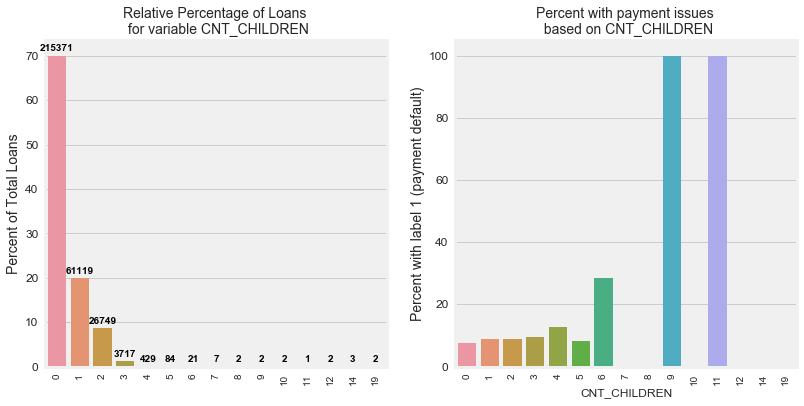

In [10]:
def bargraph(feature, df):
    ''' Generates graph with relative percentage of responses for each category of feature
    Generates 2nd graph with percent of late loan payments for each feature category '''
    
    # Calculate counts and percent for each category of feature
    counts = df[feature].value_counts().to_frame()
    counts.columns=["Count"]
    counts["rel_percent"] = counts["Count"].apply(lambda x: 100*x/df.shape[0])
    counts.sort_index(inplace=True)
    
    # Calculate the percentage of target=1 for each category of feature
    target_percent = df[[feature, 'TARGET']].groupby([feature]).mean()*100
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    bar = sns.barplot(ax=ax1, x = counts.index, y="rel_percent", data=counts)
    bar.set_title("Relative Percentage of Loans \n for variable " + str(feature), fontsize=14)
    bar.set_xticklabels(bar.get_xticklabels(),rotation=90)
    bar.yaxis.set_tick_params(labelsize=12)
    bar.set_ylabel('Percent of Total Loans', fontsize=14)
    
    for i, v in enumerate(counts["rel_percent"]):
        ax1.text(i, v + 1, str(int(counts.iloc[i]["Count"])), color='black', ha='center',fontweight='bold')
    
    bar2 = sns.barplot(ax=ax2, x = target_percent.index, y='TARGET', data=target_percent)
    bar2.set_title("Percent with payment issues \n based on " + str(feature), fontsize=14)
    bar2.set_xticklabels(bar2.get_xticklabels(),rotation=90)
    bar2.yaxis.set_tick_params(labelsize=12)
    bar2.set_ylabel('Percent with label 1 (payment default)', fontsize=14) 
    plt.show();
    
bargraph("CNT_CHILDREN", train_filled)

The CNT_CHILDREN at first appears striking as those with more children have the potential for very high default (100% for those with 9 and 11 children).  However, there are only 3 loans total for both of the aforementioned categories and the seven loans reporting 12+ children have no default.  A very small fraction of loans come from individuals with greater than three children, and for those with those with three or fewer children, there are much more modest differences. The default rate is 7.7% for zero children, just under 9% for 1 and 2 children, and 9.6% for three children indicating the variable may have some predictive value for loan default.  For now the CNT_CHILDREN will be left as is, but it may be useful to group values of 4 or more children all in one category since the counts for greater than three children are so low.  

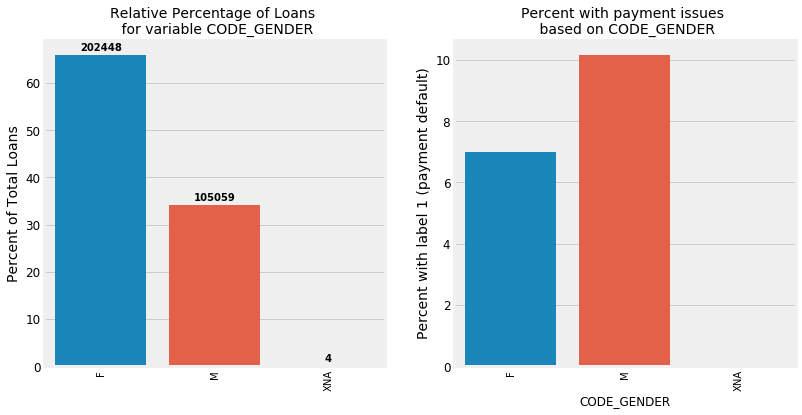

In [45]:
bargraph("CODE_GENDER", train_filled)

Based on the CODE_GENDER favorable, there are more than twice as many female applicants as males in the dataset, and females have a lower default rate.  There is an additional Gender category "XNA" that has just 4 applicants and a default rate of zero. It is unclear if this is a missing value or a non-binary gender designation.  There are so few applicants with this designation (4) and this designation is not present in the test file.  In a previous version of this analysis file, a random forest ensemble was run with "IS_XNA" variable and it was not useful based on its feature importance.  Consequently, the GENDER categorical variable will be reassigned to a binary category variable:  IS_MALE (1 if male, 0 if female or XNA).

In [105]:
train_filled = pd.read_csv("app_train_filled_colinear_removed20180716.csv", index_col=0)
train_filled["t_IS_MALE"] = np.where(train_filled["CODE_GENDER"] == "M", 1, 0)
train_filled = train_filled.drop("CODE_GENDER", axis=1)

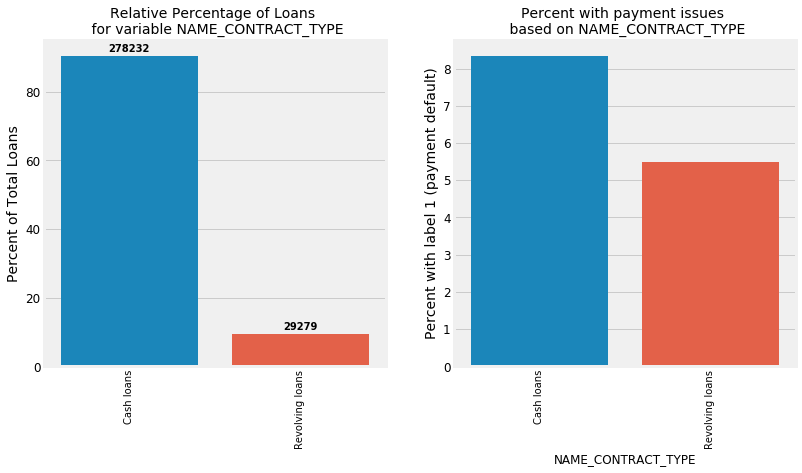

In [57]:
bargraph("NAME_CONTRACT_TYPE", train_filled)

In [106]:
train_filled["NAME_CONTRACT_TYPE"] = np.where(train_filled["NAME_CONTRACT_TYPE"] == "Cash loans",
                                             0, 1)

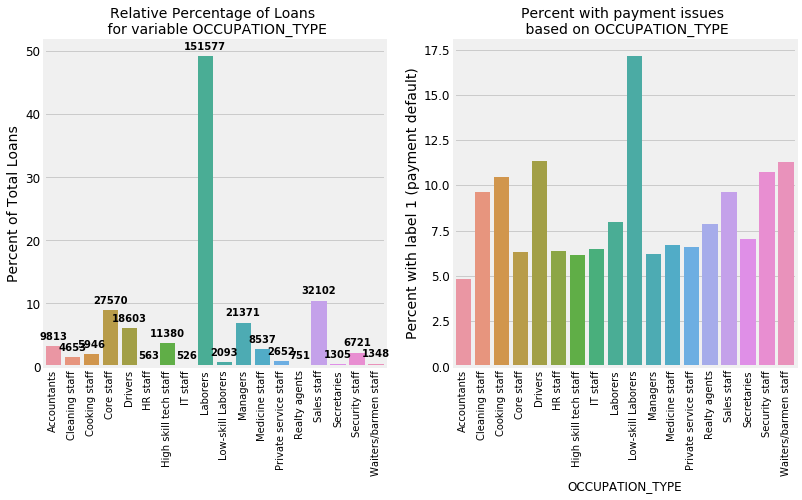

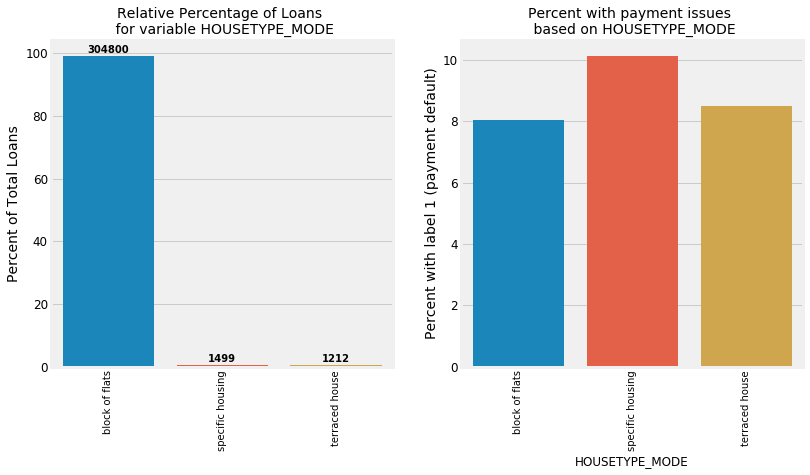

In [107]:
bargraph("OCCUPATION_TYPE", train_filled)
bargraph("HOUSETYPE_MODE", train_filled)

<a id='p37'></a>
### [Conversion of Selected Multi-level Categorical Variables to Binary Variables](#top)

There are 11 remaining categorical with multilevels, such as OCCUPATION_TYPE and HOUSETYPE_MODE displayed above.  To include categorical variables in the model, I will convert them to binary variables (one for each category) using the dummies function.  Doing so can result in a rapid increase of variables, and so the conversion will only be done variables for which there are clear differences in the loan default for a subset categories that have at least a few thousand loans.  Looking at the set of graphs immediately above, OCCUPATION_TYPE meets this critera. For example, there are close to 10,000 accountants who collectively have a default rate less than 5%, which is distinct from the 32,000+ Sales staff who collectively have default rates approaching 10%. 

In contrast, the HOUSETYPE_MODE above seems substantially less useful.  There are very few loans (<1500) with the label "specific housing" or "terraced housing".  In addition, the differences in defaults are fairly modest.   

The remaining categorical were similarly assessed with graphs (not shown) and the following categorical variables were identified to convert to binary:

OCCUPATION_TYPE
FONDKAPREMONT_MODE
NAME_HOUSING_TYPE
NAME_FAMILY_STATUS
NAME_EDUCATION_TYPE
NAME_INCOME_TYPE

It will be decided later whether to retain or discard individual binary variables based on trends or evaluation of variables through methods such as feature importances.

In [108]:
cols_to_drop = ['NAME_TYPE_SUITE',  'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 
                   'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE']

cols_to_binary = ["OCCUPATION_TYPE", "FONDKAPREMONT_MODE", "NAME_HOUSING_TYPE",
                  "NAME_FAMILY_STATUS", "NAME_EDUCATION_TYPE", "NAME_INCOME_TYPE"]

def convert_dummies(columns, df):
    for col in columns:
        dummies = pd.get_dummies(df[col],prefix=col)
        df = pd.concat([df,dummies],axis=1)
        df.drop(col, axis=1, inplace=True)
    return df

In [109]:
train_filled = convert_dummies(cols_to_binary, train_filled)
train_filled.drop(cols_to_drop, axis=1, inplace=True)
new_dummies = [i for i in train_filled.columns for col in cols_to_binary if (col in i)]
print(len(new_dummies))

47


47 dummies columns were created from 6 columns, resulting in 41 new columns. 

In [110]:
new_dummies.append("TARGET")
check_correlations(new_dummies,train_filled)[0:15]    

,Feature,Correlation with TARGET
0,TARGET,1.000
1,NAME_INCOME_TYPE_Working,0.057
2,NAME_EDUCATION_TYPE_Higher education,-0.057
3,NAME_EDUCATION_TYPE_Secondary / secondary special,0.050
4,NAME_INCOME_TYPE_Pensioner,-0.046
5,OCCUPATION_TYPE_Drivers,0.030
6,NAME_HOUSING_TYPE_With parents,0.030
7,NAME_HOUSING_TYPE_House / apartment,-0.029
8,OCCUPATION_TYPE_Low-skill Laborers,0.028
9,NAME_FAMILY_STATUS_Single / not married,0.027


### EDA Continued

Next, the EDA continues with analysis of continuous numerical variables.

In [9]:
#Transform log, amount of loan vs income total
def distribution(feature, dataframe):
    plt.figure()
    plt.title("Distributions of " + str(feature), fontsize=14)
    sns.kdeplot(dataframe[feature][dataframe["TARGET"]==0], label='0', shade=True)
    sns.kdeplot(dataframe[feature][dataframe["TARGET"]==1], label='1 (late)', shade=True)
    plt.xlabel(str(feature))
    plt.ylabel("Density")
    plt.show()


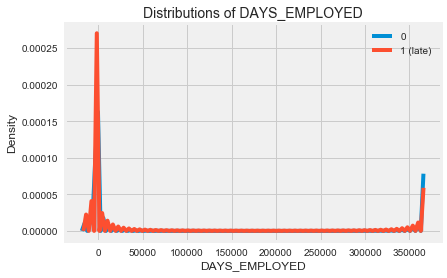

In [10]:
#train_filled = pd.read_csv("20180626train_filled_colinear_removed.csv")
distribution('DAYS_EMPLOYED', train_filled)

There is a strange, most likely erroneous peak corresponding to over 350,000 days (~100 yrs) of employment.  

In [113]:
max_days_employed = train_filled["DAYS_EMPLOYED"].max()
number_max = len(train_filled[train_filled["DAYS_EMPLOYED"] == max_days_employed])
total_entries = train_filled.shape[0]
percent = np.round((100*number_max/total_entries), 2)
print("{} of the total {} entries in train ({}%) \ncontain the value {} for DAYS_EMPLOYED".format(
    number_max, total_entries, percent, max_days_employed))

55374 of the total 307511 entries in train (18.01%) 
contain the value 365243 for DAYS_EMPLOYED


It is not clear where this value came from, but as a days employed number it does not make sense (100 years of employment).  It may correspond to individuals with a very long work history.  Those observations with the value will be noted using a new feature, and the 365243 value will be replaced with more feasible values.  

In [11]:
train_filled["t_DAYS_EMPLOYED_100yrs"] = np.where(train_filled['DAYS_EMPLOYED'] == 365243, 1, 0)

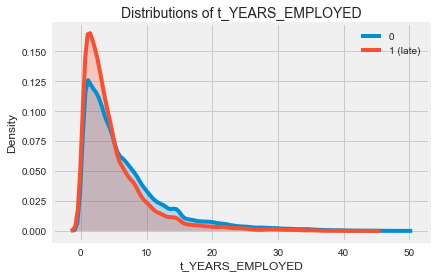

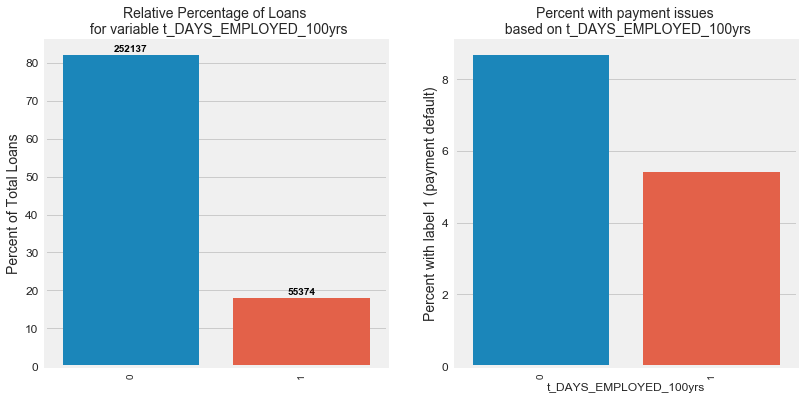

In [12]:
train_filled['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
train_filled["t_YEARS_EMPLOYED"] = np.abs(train_filled["DAYS_EMPLOYED"]/365)
distribution('t_YEARS_EMPLOYED', train_filled)
bargraph("t_DAYS_EMPLOYED_100yrs", train_filled)

With the large 100 year values removed and the conversion from DAYS to YEARS, the YEARS_EMPLOYED distribution makes more sense; it is unimodal with a right skew. 

The DAYS_EMPLOYED_100yrs actually shows a big difference in default rate (2.5%+ lower for those had the value), indicating it may be useful for prediction.

There are now over 55k missing values for the "YEARS_EMPLOYED" variable in the data set to be filled. To decide which fill method to use, the missing values will be filled using mean, median, and mode values for the variable.  The correlations for YEARS_EMPLOYED with the target label for each fill method and the non-filled data will be caclulated and compared.  


In [116]:
filled_yrs_employed_dfs = fillna_func(train_filled[["t_YEARS_EMPLOYED", "TARGET"]])

filled_yrs_correlations_dfs = [check_correlations(["t_YEARS_EMPLOYED", "TARGET"],train_filled) 
                           for df in filled_yrs_employed_dfs]
notfilled_yrs_employed_corrs = check_correlations(["t_YEARS_EMPLOYED", "TARGET"],train_filled)

filled_yrs_correlations_dfs.append(notfilled_yrs_employed_corrs)
filled_yrs_correlations = merge_dataframes(filled_yrs_correlations_dfs, "Feature")


filled_yrs_correlations.columns = ["Feature", "corr Mean Fill", "corr Median Fill", "corr Mode Fill", 
                               "corr No NaFill"]
filled_yrs_correlations.drop([0], inplace=True)

del filled_yrs_employed_dfs
del filled_yrs_correlations_dfs
del notfilled_yrs_employed_corrs
gc.collect()

filled_yrs_correlations

,Feature,corr Mean Fill,corr Median Fill,corr Mode Fill,corr No NaFill
1,t_YEARS_EMPLOYED,-0.08,-0.08,-0.08,-0.08


The mean, median, and mode fill na methods all give the same correlations value as the unfilled. The mean will be used. Surprisingly, the correlation value is negative.

Additional metrics will now be analyzed.

In [117]:
value = train_filled["t_YEARS_EMPLOYED"].mean()
application_miss_value_d["t_YEARS_EMPLOYED"] = value
train_filled["t_YEARS_EMPLOYED"] = train_filled["t_YEARS_EMPLOYED"].fillna(value)
train_filled.drop("DAYS_EMPLOYED", axis=1, inplace=True)

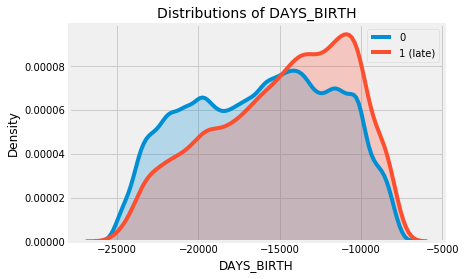

In [118]:
distribution("DAYS_BIRTH", train_filled)

The DAYS_BIRTH is less inuitive representation of age, with larger negative values corresponding to an older age.  The DAYS_BIRTH will be converted to standard age in years. 

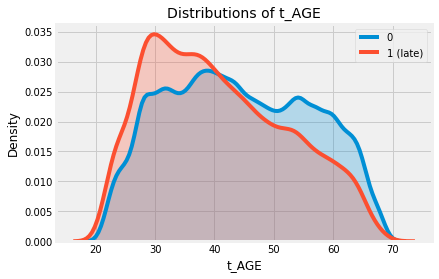

In [119]:
train_filled["t_AGE"] = np.abs(train_filled["DAYS_BIRTH"]/365)
distribution("t_AGE", train_filled)
train_filled.drop("DAYS_BIRTH",axis=1, inplace=True)

The data is now more readable.  There is a range of applicant ages from approx 20 to 70.  The distribution for the subset of loans with defaults is has a larger proportion of younger applicants. 

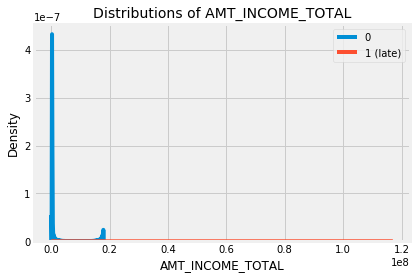

In [72]:
distribution("AMT_INCOME_TOTAL", train_filled)

The income looks to have a strong right skew and its distribution is not clear in the above graphic.  A log transformation will be used to help normalize the distribution.  

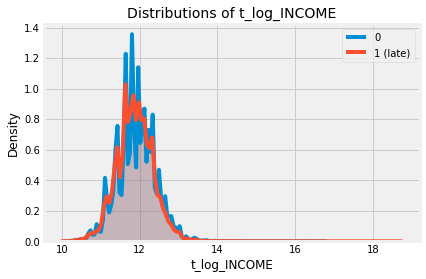

In [120]:
train_filled["t_log_INCOME"] = np.log(train_filled["AMT_INCOME_TOTAL"])
distribution("t_log_INCOME", train_filled)

The transformation normalized the data and it is now easier to the distribution. The distributions look different between the non-default and default categories, with the no-late looking more variable, but it is not easy to identify meaningful differences between the two.  

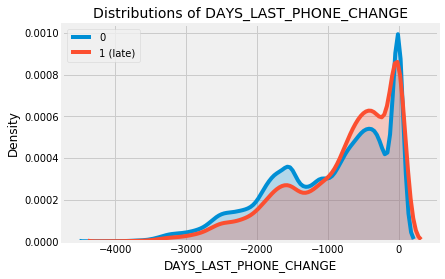

37672 of the total 307511 entries in train (12.25%) 
contain the value 0 for DAYS_LAST_PHONE_CHANGE


In [121]:
distribution("DAYS_LAST_PHONE_CHANGE", train_filled)
number_zero = len(train_filled[train_filled["DAYS_LAST_PHONE_CHANGE"]==0])
total_entries = train_filled.shape[0]
percent = np.round((100*number_zero/total_entries), 2)
print("{} of the total {} entries in train ({}%) \ncontain the value 0 for DAYS_LAST_PHONE_CHANGE".
      format(number_zero, total_entries, percent))

The data here is strange because there is a large peak at zero, which means that a considerable amount (12.25%) of applicants changed their phone 0 days before the application.  One possibility is that zero was entered as a form of "NA".  From the analysis of missing data, there was a very small amount of np.Nan for this feature (fraction = 0.000003), which actually corresponds to only 1 NA in the entire dataset.  The data here will be recalculated.  An new variable will note whether there was a zero in the field, and the zeros for the current variable will be filled with a replacement of the 0s with np.nan.   A correlation analysis was done (not shown) and no differences were observed among filling the NA values with mean, median, or mode values.  

In [122]:
train_filled["t_PHONE_CHANGE_ZERO"] = np.where(train_filled['DAYS_LAST_PHONE_CHANGE'] == 0, 1, 0)

Initial Distribution:


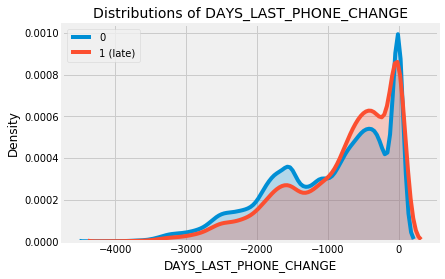

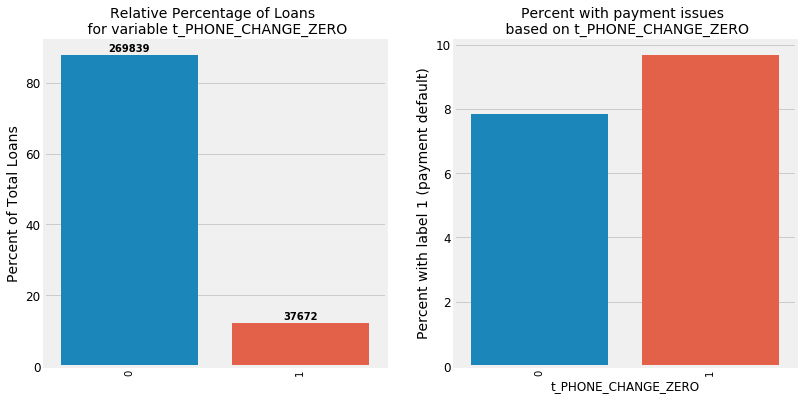


Distribution in Years (zeros are NA) before Fill:


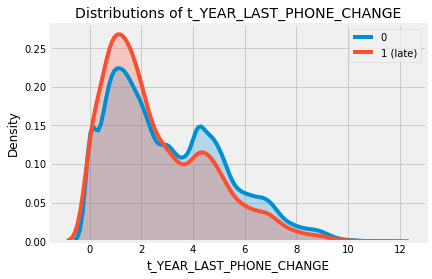

Distribution post Fill:


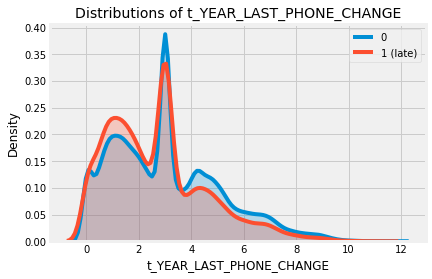

In [123]:
print("Initial Distribution:")
distribution("DAYS_LAST_PHONE_CHANGE", train_filled)

train_filled["t_YEAR_LAST_PHONE_CHANGE"] = train_filled[
    'DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan)

train_filled["t_YEAR_LAST_PHONE_CHANGE"] = np.abs(train_filled["t_YEAR_LAST_PHONE_CHANGE"]/365)

bargraph("t_PHONE_CHANGE_ZERO", train_filled)

print("\nDistribution in Years (zeros are NA) before Fill:")
distribution('t_YEAR_LAST_PHONE_CHANGE', train_filled)

value = train_filled["t_YEAR_LAST_PHONE_CHANGE"].mean()
application_miss_value_d["t_YEAR_LAST_PHONE_CHANGE"] = value
train_filled["t_YEAR_LAST_PHONE_CHANGE"] = train_filled["t_YEAR_LAST_PHONE_CHANGE"].fillna(
    value)

print("Distribution post Fill:")
distribution('t_YEAR_LAST_PHONE_CHANGE', train_filled)

Individuals with zero for phone change (t_PHONE_CHANGE_ZERO) appear to have a greater default rate.

The distribution of t_YEAR_LAST_PHONE_CHANGE after fill has a large peak in the middle because this was the mean value that was filled in for "missing values".  It's not clear if this new version of phone change is more meaningful than the initial metric with zeros, or the new metric denoting zeros, so all will be retained at this point.  
<a id='p38'></a>
### [Feature Engineering from Main Application File](#top)

Next, some additional metrics will be generated based on interactions of the data that have some inuitive meeting within this train file (Later, after all the files have been analyzed and merged, an unbiased generation of pairwise interactions across files will be used to generate new metrics to be tested/rated for potential usefullness).  For now, new engineered features include metrics for how many of the 20 documents did the applicant provide, how long they've been employed relative to their age, credit vs their annuity and income, and others.  

In [124]:
#Creating as function to easily apply to test dataset later
def new_application_features(df):
    
    '''Generates new features using the application file.  Return entire dataframe'''
    
    flag_document_columns = [i for i in df.columns if "FLAG_DOCUMENT_" in i]
    df["t_FLAG_DOC_SUM"] = df[flag_document_columns].sum(axis=1)

    df['t_FRAC_YEARS_EMPLOYED'] = df['t_YEARS_EMPLOYED']/df['t_AGE']

    df['t_FRAC_YEARS_EMPLOYED_ADULT'] = df['t_YEARS_EMPLOYED'] / (df['t_AGE']-17)

    df['t_FRAC_INCOME_CREDIT'] = df['AMT_INCOME_TOTAL']/(df['AMT_CREDIT'] + 1)

    df['t_FRAC_log_INCOME_FAMILY'] = df['t_log_INCOME']/ (df['CNT_FAM_MEMBERS'] + 1)

    df['t_FRAC_INCOME_FAMILY'] = df['AMT_INCOME_TOTAL'] / (df['CNT_FAM_MEMBERS'] + 1)

    df['t_FRAC_ANNUITY_INCOME'] = df['AMT_ANNUITY']/df['AMT_INCOME_TOTAL']

    df['t_FRAC_ANNUITY_log_INCOME'] = df['AMT_ANNUITY'] /df['t_log_INCOME']

    df['t_CREDIT_TERM'] = df['AMT_CREDIT'] /df['AMT_ANNUITY']
    
    df["t_CREDIT_GOODS_RATIO"] = df['AMT_CREDIT'] /df['AMT_GOODS_PRICE']
    
    df["t_CREDIT_INCOME_RATIO"] = df['AMT_CREDIT'] /df['AMT_INCOME_TOTAL']
    
    df["t_CREDIT_logINCOME_RATIO"] = df['AMT_CREDIT'] /df["t_log_INCOME"]

    df['t_CREDIT_TERM_INCOME'] = df['t_CREDIT_TERM'] * df["t_log_INCOME"]
    
    df["t_CREDIT_TERM_INCOME_LOG_RATIO"] = df['t_CREDIT_TERM'] / df["t_log_INCOME"]

    df['t_RECENT_CHANGES'] = (df["t_YEARS_EMPLOYED"] * 
                              np.abs(df["DAYS_REGISTRATION"]/365) * 
                              np.abs(df["DAYS_ID_PUBLISH"]/365))

    df['t_RECENT_CHANGES2'] =  (df['t_RECENT_CHANGES'] * df['t_YEAR_LAST_PHONE_CHANGE'])

    df['t_RECENT_CHANGES3'] = (np.abs(df["DAYS_REGISTRATION"]/365) * 
                               np.abs(df["DAYS_ID_PUBLISH"]/365))
    df["t_EXT_SOURCE_MEAN"] = (df["EXT_SOURCE_1"] + df["EXT_SOURCE_2"] + df["EXT_SOURCE_3"])/3
    
    df["t_EXT_SOURCE23_MEAN"] = (df["EXT_SOURCE_2"] + df["EXT_SOURCE_3"])/2 
    
    df["t_EXT_SOURCE_VAR"] = df[["EXT_SOURCE_1","EXT_SOURCE_2", "EXT_SOURCE_3"]].var(axis=1)
    
    df["t_EXT_MEAN_VAR_RATIO"] = df["t_EXT_SOURCE_MEAN"] /  df["t_EXT_SOURCE_VAR"] 
    
    df["t_EXT_SOURCE23_VAR"] = df[["EXT_SOURCE_2", "EXT_SOURCE_3"]].var(axis=1)
    
    df["t_EXT_MEAN23_VAR_RATIO"] = df["t_EXT_SOURCE23_MEAN"] /  df["t_EXT_SOURCE23_VAR"] 
                                                  
    return df

In [128]:
#Add to filled application file and record means so it can be applied to test missing data; using means
train_filled = new_application_features(train_filled)
new_keys = [c for c in train_filled.columns if c.startswith("t_")]

for k in new_keys:
    value = train_filled[k].mean()
    application_miss_value_d[k] = value

#miss_value_df = pd.DataFrame.from_dict(application_miss_value_d, orient='index')
#miss_value_df.columns=["Fill_Value"]
#miss_value_df.to_csv("app_miss_valued_20180716.csv")  #append date before running
#train_filled.to_csv("train_filled_temp20180716.csv")

<a id='p39'></a>
### [Process Test Data](#top)

Now that the initial analysis of the train application file has been completed, the feature modifications need to be applied to the test application file so that the two files correspond with one another.  Mean/median/mode fill values from the train file will be used to impute missing values in the test file.  

In [153]:
# Generate one function that will make all the modifications described thus far 
#(minus the fill na) that can be used for train and test applications file

# Generate a second function that will fill in np.nan using values from the dictionary/df

def process_application_file(df):
    
    '''' Processes the application file: Converts binary variables, records frac missing,
    drops colinear and less interesting categorical variables (Determined from EDA), adds/
    modified additional variables.
    Does not fill in missing values.  '''

    #Convert binary N/Y variables to 0/1 
    df = yn_to_num(df)

    #Record FracNa in file
    df["frac_missing_mainapp"] = df.isnull().sum(axis=1)/df.shape[1]

    #Drop the 28 colinear columns and 5 categorical that were removed from the train app file 

    colinear_cols = ["COMMONAREA_MEDI", "COMMONAREA_MODE", "ELEVATORS_MEDI", "ELEVATORS_MODE",
                     "ENTRANCES_MEDI", "ENTRANCES_MODE", "FLOORSMAX_MEDI", "FLOORSMAX_MODE",
                     "FLOORSMIN_MEDI", "FLOORSMIN_MODE", "LANDAREA_MEDI", "LANDAREA_MODE", 
                     "NONLIVINGAREA_MEDI", "NONLIVINGAREA_MODE", "LIVINGAREA_MEDI", 
                     "LIVINGAREA_MODE", "APARTMENTS_MEDI", "APARTMENTS_MODE", "BASEMENTAREA_MEDI",
                     "BASEMENTAREA_MODE","LIVINGAPARTMENTS_MEDI", "LIVINGAPARTMENTS_MODE", 
                     "NONLIVINGAPARTMENTS_MEDI","YEARS_BEGINEXPLUATATION_AVG", 
                     "YEARS_BEGINEXPLUATATION_MEDI", "YEARS_BUILD_MEDI","YEARS_BUILD_MODE", 
                     "AMT_REQ_CREDIT_BUREAU_HOUR",  "OBS_60_CNT_SOCIAL_CIRCLE"]

    categorical_drop = ['NAME_TYPE_SUITE',  'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 
                       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE']

    df.drop(colinear_cols, axis=1, inplace=True)
    df.drop(categorical_drop, axis=1, inplace=True)
    
    #Modification of existing features
    
    df["t_IS_MALE"] = np.where(df["CODE_GENDER"] == "M", 1, 0)
    df = df.drop("CODE_GENDER", axis=1)

    df["NAME_CONTRACT_TYPE"] = np.where(df["NAME_CONTRACT_TYPE"] == "Cash loans", 0, 1)
    df["t_DAYS_EMPLOYED_100yrs"] = np.where(df['DAYS_EMPLOYED'] == 365243, 1, 0)
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    df["t_YEARS_EMPLOYED"] = np.abs(df["DAYS_EMPLOYED"]/365)
    df.drop("DAYS_EMPLOYED", axis=1, inplace=True)

    df["t_AGE"] = np.abs(df["DAYS_BIRTH"]/365)
    df.drop("DAYS_BIRTH",axis=1, inplace=True)

    df["t_log_INCOME"] = np.log(df["AMT_INCOME_TOTAL"])
    df["t_PHONE_CHANGE_ZERO"] = np.where(df['DAYS_LAST_PHONE_CHANGE'] == 0, 1, 0)

    df["t_YEAR_LAST_PHONE_CHANGE"] = df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan)
    
    # Addition of new features
    
    df = new_application_features(df)
    
    # Selected categorical variables to binary with dummies
    
    df = convert_dummies(cols_to_binary, df)
    
    return df

def fill_from_dictionary(df, dictionary):
    ''' Fills in missing data using values from dictionary df file'''
    
    columns = miss_data_sum(df)["Feature"].tolist()
    for c in columns:
        try:
            value = float(dictionary.loc[c, "Fill_Value"])
        except:
            value = dictionary.loc[c, "Fill_Value"]
        df[c] = df[c].fillna(value)
    return df


In [154]:
train = pd.read_csv("application_train.csv")
test= pd.read_csv("application_test.csv")
train_proc = process_application_file(train)
test_proc = process_application_file(test)
del train
del test
gc.collect()
app_dictionary = pd.read_csv("app_miss_valued_20180716.csv", index_col=0)
train_proc_fill = fill_from_dictionary(train_proc[train_proc.columns], app_dictionary)
test_proc_fill = fill_from_dictionary(test_proc[test_proc.columns], app_dictionary)


The Data file consists of 157 columns and 307511 rows
53 columns have missing data
22 columns have greater than 20% missing data
The average (median) row has 11.0% missing data
Columns with Missing Data:

The Data file consists of 154 columns and 48744 rows
47 columns have missing data
22 columns have greater than 20% missing data
The average (median) row has 11.0% missing data
Columns with Missing Data:


In [145]:
diff_columns = [i for i in train_proc_fill.columns if i not in test_proc_fill.columns]
print(diff_columns)

['TARGET', 'NAME_FAMILY_STATUS_Unknown', 'NAME_INCOME_TYPE_Maternity leave']


There were three extra columns in the train application compared ot the test.  This includes the TARGET (default) status, as expected, as well as two binary variables generated from categorical variables.  These cateogries were present as very low frequency and so train file and not at all present in the test file.  They will be dropped from the analysis. 
<a id='p310'></a>
### [Initial Look at Feature Importances and Comparison with Correlation Values](#top)

Next, I will look at feature importances using the default settings of a gradient boosted random forest classifier (LightGBM). I plan on using such a model for the predictions because such algorithms historically tend to perform well in Kaggle competitions.  The feature imortances will provide a look at which features are most important, which can inform choices in the processing of the accessory data files.  

Additionally, I have used the correlation values as proxy for importance when filling in the missing values.  I will check whether there is indeed a strong correlation between feature importance and feature correlation with the TARGET.

First, I generate feature importances for both fill and non-filled versions of the processed train application file. 

In [22]:
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

def feature_importance(df, correlations=True):
    
    ''' Input df with features and target value and return feature importances for numeric
    features based on RandomForestClassifier. Additional col reporting correlation'''
    
    features = [c for c in df.columns if df[c].dtype != 'object']
    df = df[features]
    
    if 'SK_ID_CURR' in df:
        df.drop("SK_ID_CURR", axis=1, inplace=True)
    
    if correlations:
        corr_df = check_correlations(df.columns.tolist(), df)
        
    target = df["TARGET"]
    df.drop("TARGET", axis=1, inplace=True)
    
    rf = LGBMClassifier(n_estimators=150, max_depth=8, min_samples_leaf=4, 
                                max_features=0.5, random_state=2)
    rf.fit(df, target)
    
    feature_imp = pd.DataFrame(rf.feature_importances_,index = df.columns,
                            columns=['Importance']).sort_values('Importance', ascending=False)
    
    if correlations:
        feature_imp = feature_imp.merge(corr_df, how='left', left_index=True, right_on='Feature')
        feature_imp = feature_imp[["Feature", 'Importance', "Correlation with TARGET"]]
        feature_imp.set_index("Feature", drop=True, inplace=True)
    return feature_imp

In [14]:
pd.set_option('display.max_rows', 300)
train_proc_imp = feature_importance(train_proc)
train_proc_fill_imp = feature_importance(train_proc_fill)
train_proc_fill_imp.reset_index(inplace=True)
train_proc_imp.reset_index(inplace=True)
train_importances = train_proc_imp.merge(train_proc_fill_imp, how='left', on="Feature")
train_importances.columns = ["Feature", "No Fill Imp", "No Fill Corr", "Fill Rank", "Fill Imp", "Fill Corr"]
train_importances.rename_axis('No Fill Rank', inplace=True)
train_importances

,Feature,No Fill Imp,No Fill Corr,Fill Rank,Fill Imp,Fill Corr
No Fill Rank,,,,,,
0,t_CREDIT_TERM,307,-0.030,0,327,-0.030
1,EXT_SOURCE_1,197,-0.151,1,201,-0.092
2,EXT_SOURCE_3,180,-0.166,3,173,-0.144
3,t_AGE,179,-0.078,2,194,-0.078
4,EXT_SOURCE_2,169,-0.147,5,170,-0.147
5,t_EXT_SOURCE23_MEAN,146,-0.203,4,171,-0.175
6,t_CREDIT_GOODS_RATIO,129,0.067,6,134,0.067
7,DAYS_ID_PUBLISH,120,0.053,7,117,0.053
8,t_EXT_SOURCE_MEAN,117,-0.217,8,99,-0.117


Above are the calculated importance.  The most feature was the newly engineered t_CREDIT_TERM, which the amount of credit divided by the annuity.  The EXT_SOURCE files were all among the most important; based on the colinear analysis, these are not redundant features.   The two dummy features that were present in the train set only were not found to be important.  OWN_CAR_AGE was relatively more important in the no fill data (rank 10) than the filled NA data (rank 30).  There is also a decrease in its correlation value (0.053 to 0.034) with the target.  Next, I'll check if in general it appears that features with higher correlations have better importances.

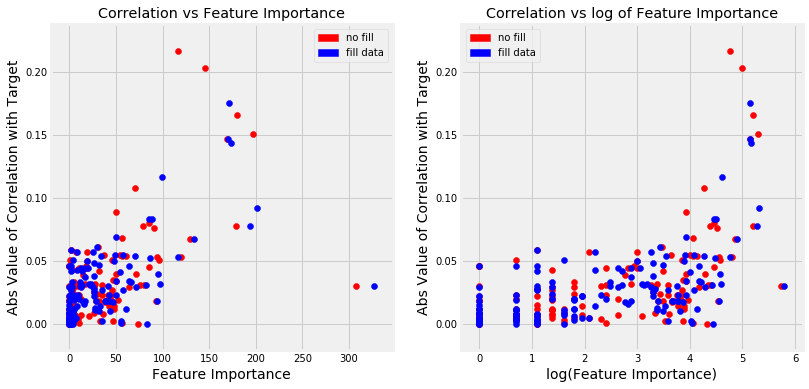

In [24]:
#Plot Importance vs Correlation with Target
import matplotlib.patches as mpatches

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
ax1.scatter(x=train_importances["No Fill Imp"], 
            y=np.abs(train_importances["No Fill Corr"]), color='red')
ax1.scatter(x=train_importances["Fill Imp"], 
            y=np.abs(train_importances["Fill Corr"]), color='blue')
ax2.scatter(x=np.log(train_importances["No Fill Imp"]+1), 
            y=np.abs(train_importances["No Fill Corr"]), color='red')
ax2.scatter(x=np.log(train_importances["Fill Imp"]+1), 
            y=np.abs(train_importances["Fill Corr"]), color='blue')
ax1.set_title("Correlation vs Feature Importance")
ax2.set_title("Correlation vs log of Feature Importance")
ax1.set_ylabel('Abs Value of Correlation with Target', fontsize=14)
ax2.set_ylabel('Abs Value of Correlation with Target', fontsize=14)
ax1.set_xlabel('Feature Importance', fontsize=14)
ax2.set_xlabel('log(Feature Importance)', fontsize=14)
red_patch = mpatches.Patch(color='red', label='no fill')
blue_patch = mpatches.Patch(color='blue', label='fill data')
ax1.legend(handles=[red_patch, blue_patch])
ax2.legend(handles=[red_patch, blue_patch])
plt.show()

The feature importance distribution has a strong right skew; most values were near zero with a few with much higer values.  Plotting the log transformation of feature importance makes the trends easier to observe. 

While there is an association between the correlation strength and the feature importance, this is also a lot of noise for lower correlation strengths.  It looks like correlations with strengths greater than 0.05 (and certainly greater than 0.075) tend to be more significant. 

Next, I will move on to analyzing the other datafiles. 

<a id='p4'></a>
## [4. Processing  and Feature Engineering of Supplemental Data Files:](#top)
<a id='p41'></a>
### [Most Loans Have Data in the Supplemental Data files](#top)

I processed the main application file in detail above.  There are still 5 other files to go through that have additional applicant information. These files contain both the train and test applicant info combined in a single file.  As seen in the missing data summaries, there is a lot of missing data across these files. It's possible that for many applications, there may not be any corresponding data in the supplemental files. In this section, I calculate   the fraction of IDs with corresponding information in each of the accessory files.  

The test IDs are used rather than that train IDs, because they are fewer (less computationally expensive) and expected to have a similar distribution as the train IDs.  

In [36]:
files = ["application_train.csv", "application_test.csv", "bureau.csv",
            "credit_card_balance.csv", "installments_payments.csv", "previous_application.csv",
            "POS_CASH_balance.csv"]

names = ['train', 'test_app', "bureau", "cc_bal", "install", "prev_app", "POS"]

unique_ids = {}

for i in range(0, len(files)):
    file = pd.read_csv(files[i])
    unique_ids[names[i]] = file["SK_ID_CURR"].unique().tolist()
    del file
    gc.collect()
    
test_ratios = {}
test_ids = len(unique_ids["test_app"])
for c in names:
    test_ratios[c] = (len([i for i in unique_ids["test_app"] if i in unique_ids[c]])/
                      test_ids)
                      
test_ratios_df = pd.DataFrame.from_dict(test_ratios, orient='index')
test_ratios_df.columns = ["Fraction of test IDs in file"]
test_ratios_df

,Fraction of test IDs in file
train_app,0.000000
test_app,1.000000
bureau,0.868209
cc_bal,0.341642
install,0.983588
prev_app,0.980634
POS,0.980798


As expected, the calculation shows that all of the test IDs taking from the test application file are present in the test application file and none of the test IDs are present in the train data IDs.  The fraction of test applicant IDs present in the accessory files ranges from 0.34 for the credit_card_balance to 0.98 for the previous application and POS_CASH_BALANCE files.  The credit_card_balance may be less useful because it only contains information for a third of the applicants.   

<a id='p42'></a>
### [Bureau Datafiles - Processing and Feature Engineering](#top)

There are two files provided that contain credit bureau information:

bureau.csv - All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample). For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

bureau_balance.csv - Monthly balances of previous credits in Credit Bureau. This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample # of relative previous credits # of months where we have some history observable for the previous credits) rows.

I will begin with the bureau_balance file which has no missing data.

The bureau_balance consists of just three columns: a unique coding for each application corresponding to the ID in bureau (SK_ID_BUREAU), a list of monthly balances relative to the application date (MONTHS_BALANCE; 0, -1, -2, etc) and the status of the loan (STATUS):

C = closed

X = status unknown

0 = no DPD

1 = maximal DPD during month between 1-30

2 = DPD 31-60

5 = DPD 120+ or sold or written off

This table has one row for each month of history of every previous credit reported to Credit Bureau. This amounts to a total of 27299925 rows of data. To condense the data into a more usable form, a new "Weighted_DPD_Sum" will be calculated. The amount of non-zero DPD statuses will be divided by the absolute value of the MONTHS_BALANCE and summed, resulting in more recent defaults resulting in higher "Weighted_DPD" scores.  Note: 1 was subtracted from all "MONTHS_BALANCE" values to prevent division by zero error. 

In addition, the mean DPD will be calculated and summary statistics (mean, min, max) will be calculate for the length of account (MONTHS_BALANCE)

In [16]:
bureau_balance = pd.read_csv("bureau_balance.csv")
bureau_balance.replace(["C", "X"], 0, inplace=True)
bureau_balance = bureau_balance.astype("int32")
bureau_balance["bbWeighted_DPD"] = bureau_balance["STATUS"]/(
    np.abs(bureau_balance["MONTHS_BALANCE"] -1 ))
bureau_balance['bbWeighted_DPD_Sum'] = bureau_balance["bbWeighted_DPD"].groupby(
    bureau_balance["SK_ID_BUREAU"]).transform("sum")
bureau_balance['bbmean_DPD'] = bureau_balance["STATUS"].groupby(
    bureau_balance["SK_ID_BUREAU"]).transform("mean")
bureau_balance['MONTHS_BALANCE_min'] = bureau_balance["MONTHS_BALANCE"].groupby(
    bureau_balance["SK_ID_BUREAU"]).transform("min")
bureau_balance['MONTHS_BALANCE_max'] = bureau_balance["MONTHS_BALANCE"].groupby(
    bureau_balance["SK_ID_BUREAU"]).transform("max")
bureau_balance['MONTHS_BALANCE_size'] = bureau_balance["MONTHS_BALANCE"].groupby(
    bureau_balance["SK_ID_BUREAU"]).transform("count")


bureau_balance[bureau_balance["SK_ID_BUREAU"] == 5715797]

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS,bbWeighted_DPD,bbWeighted_DPD_Sum,bbmean_DPD,MONTHS_BALANCE_min,MONTHS_BALANCE_max,MONTHS_BALANCE_size
536,5715797,0,0,0.000000,1.740984,0.518519,-26,0,27
537,5715797,-1,1,0.500000,1.740984,0.518519,-26,0,27
538,5715797,-2,1,0.333333,1.740984,0.518519,-26,0,27
539,5715797,-3,0,0.000000,1.740984,0.518519,-26,0,27
540,5715797,-4,0,0.000000,1.740984,0.518519,-26,0,27
541,5715797,-5,0,0.000000,1.740984,0.518519,-26,0,27
542,5715797,-6,0,0.000000,1.740984,0.518519,-26,0,27
543,5715797,-7,2,0.250000,1.740984,0.518519,-26,0,27
544,5715797,-8,1,0.111111,1.740984,0.518519,-26,0,27
545,5715797,-9,0,0.000000,1.740984,0.518519,-26,0,27


The above is the Weighted_DPD_Sum calculation for one previous previous credit report (ID # 5715797).  The Weighted_DPD_Sum values will be merged with the bureau file (generating the bureau combined file bureau_comb) and the percent of missing data for this new metric and across the metrics will be calculated:

In [17]:
bureau_balance.drop_duplicates("SK_ID_BUREAU", inplace=True) 

bureau = pd.read_csv("bureau.csv")
bb_to_merge = bureau_balance[["SK_ID_BUREAU", "bbWeighted_DPD_Sum", "bbmean_DPD",
                             'MONTHS_BALANCE_min', 'MONTHS_BALANCE_max', 'MONTHS_BALANCE_size']]
bureau_comb = bureau.merge(bb_to_merge, how="left", on="SK_ID_BUREAU")
w_dpd_null = bureau_comb["bbWeighted_DPD_Sum"].isnull().sum()
print("There are {} NaN entries for 'bbWeighted_DPD_Sum', which is {}% of the total".format(
    w_dpd_null, np.round(100*w_dpd_null/bureau_comb.shape[0])))
print(bureau_comb["bbWeighted_DPD_Sum"].describe())

del bb_to_merge
del bureau
del bureau_balance
gc.collect()

There are 942074 NaN entries for 'bbWeighted_DPD_Sum', which is 55.0% of the total
count    774354.000000
mean          0.059045
std           0.648332
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          25.243646
Name: bbWeighted_DPD_Sum, dtype: float64


99

In [18]:
miss_data_sum(bureau_comb, "Bureau Combined")


The Bureau Combined file consists of 22 columns and 1716428 rows
12 columns have missing data
9 columns have greater than 20% missing data
The average (median) row has 27.0% missing data
Columns with Missing Data:


,Feature,Fraction Missing
0,AMT_ANNUITY,0.714735
1,AMT_CREDIT_MAX_OVERDUE,0.655133
2,MONTHS_BALANCE_size,0.548857
3,MONTHS_BALANCE_max,0.548857
4,MONTHS_BALANCE_min,0.548857
5,bbmean_DPD,0.548857
6,bbWeighted_DPD_Sum,0.548857
7,DAYS_ENDDATE_FACT,0.369170
8,AMT_CREDIT_SUM_LIMIT,0.344774
9,AMT_CREDIT_SUM_DEBT,0.150119


### Bureau Additional Feature Engineering 

As summarized above, there are some features in the Bureau file that have a lot of missing data.  Most loan applications have multiple entries and ultimately we want to consolidate these entries into new, useful features.  Since there are generally multiple entries per loan application, features and aggregates will be generated based on the available data for a given application, and then NaNs for these new features will be filled.  

For each current application ("SK_ID_CURR"), features summarizing previous credit files will be generated.  

Afterwards, imputation of missing data will be performed for these features and they will be evaluated based on correlation with TARGET.  Those features that show a correlation with target will be added to the train dataset.

General Features:

* For each numerical variable in the data set, the mean value for the application will be calculated


The following custom metrics will also be generated:

DPD_TOT - based off of the "Weighted_DPD_Sum" generated above from bureau_balance, sums the weighted Days Past Default scores from all previous credit accounts on file.  Note that the "Weighted_DPD_Sum" is already weighted based on recency of defaults

DPD_MEAN - based off of the "Weighted_DPD_Sum" generated above from bureau_balance, provides the mean of  the weighted Days Past Default scores from all previous credit accounts on file.

TOTAL_OVERDUE - sum of AMT_CREDIT_MAX_OVERDUE across accounts

ACTIVE_TOT - total number of current open accounts 

YR5_CLOS - total accounts that have been closed in past 5 years

YR5_TOTAL - total accounts that are active or were closed less than 5 years ago (ACTIVE_TOT + YR5_CLOS)

DEBT_SUM - sum of current debt across accounts

CREDIT_SUM - sum of current credit across all active counts

DEBT_CREDIT_RATIO : Ratio of total debt to credit sum for the applicant

ACTIVE_CC = Number of Active Credit Cards

PR_MORT_NODPD = 0 or 1;  Receives a 1 if applicant had previous mortgage without a DPD of zero on previous mortgage

CURR_TYPE_UNIQ:  Total unique types of CREDIT_CURRENCY applicant has had previously

CREDIT_TYPE_UNIQ : Total unique CREDIT_TYPE applicant has previously

In [19]:
bureau_comb.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,...,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,bbWeighted_DPD_Sum,bbmean_DPD,MONTHS_BALANCE_min,MONTHS_BALANCE_max,MONTHS_BALANCE_size
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,...,NaN,0.0,Consumer credit,-131,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,...,NaN,0.0,Credit card,-20,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,...,NaN,0.0,Consumer credit,-16,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,...,NaN,0.0,Credit card,-16,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,...,NaN,0.0,Consumer credit,-21,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
#There are a few pos values for DAYS_CREDIT_UPDATE, which doesn't make sense because
#days relative to the application are recorded as negative values
bureau_comb["DAYS_CREDIT_UPDATE"] = np.where(bureau_comb['DAYS_CREDIT_UPDATE'] > 0, np.nan, 
                                             bureau_comb["DAYS_CREDIT_UPDATE"])

# generate summary features from existing features
num_variables = [c for c in bureau_comb.columns if bureau_comb[c].dtype != 'object']
num_variables.remove("SK_ID_CURR")
num_variables.remove("SK_ID_BUREAU")
for c in num_variables:
    bureau_comb["b_mean_" + str(c)] = bureau_comb[c].groupby(bureau_comb["SK_ID_CURR"]
                                                          ).transform('mean')

min_columns = ['DAYS_CREDIT', "AMT_CREDIT_SUM_DEBT", 'DAYS_CREDIT_ENDDATE', 
               "DAYS_CREDIT_UPDATE", 'MONTHS_BALANCE_min']

max_columns = ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'CREDIT_DAY_OVERDUE','AMT_CREDIT_SUM',
              'AMT_CREDIT_SUM_DEBT', 'AMT_ANNUITY', 'MONTHS_BALANCE_max', 
               "bbWeighted_DPD_Sum", "bbmean_DPD"]

for c in min_columns:
    bureau_comb["b_min" + str(c)] = bureau_comb[c].groupby(bureau_comb["SK_ID_CURR"]).transform("min")
    
for c in max_columns:
    bureau_comb["b_max" + str(c)] = bureau_comb[c].groupby(bureau_comb["SK_ID_CURR"]).transform("max")

sum_columns = ['CNT_CREDIT_PROLONG', 'MONTHS_BALANCE_size', 'AMT_CREDIT_SUM_LIMIT', 
              'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', "bbWeighted_DPD_Sum", "bbmean_DPD"]    
    
for c in sum_columns:
    bureau_comb["b_sum" + str(c)] = bureau_comb[c].groupby(bureau_comb["SK_ID_CURR"]).transform("sum")

In [21]:
#Generate New Features:
bureau_comb_active = bureau_comb[bureau_comb["CREDIT_ACTIVE"]=="Active"]
bureau_comb_active_f = bureau_comb_active['CREDIT_ACTIVE'].groupby(
    bureau_comb_active["SK_ID_CURR"]).count().to_frame()
bureau_comb_active_f.columns=['b_ACTIVE_TOT']
bureau_comb = bureau_comb.merge(bureau_comb_active_f, how='left', 
                                 left_on="SK_ID_CURR", right_index=True)
    
bureau_comb["DAYS_ENDDATE_FACT"] = bureau_comb["DAYS_ENDDATE_FACT"].fillna(0)
bureau_closed_5yr = bureau_comb[(bureau_comb["DAYS_ENDDATE_FACT"]<0) &
                               (bureau_comb["DAYS_ENDDATE_FACT"]>=-1825)]
bureau_closed_5yr = bureau_closed_5yr["DAYS_ENDDATE_FACT"].groupby(
    bureau_closed_5yr["SK_ID_CURR"]).count().to_frame()
bureau_closed_5yr.columns=['b_YR5_CLOS']
bureau_comb = bureau_comb.merge(bureau_closed_5yr, how='left', 
                                 left_on="SK_ID_CURR", right_index=True)

del bureau_closed_5yr
del bureau_comb_active_f
gc.collect()

bureau_comb["b_YR5_TOTAL"] = bureau_comb["b_ACTIVE_TOT"] + bureau_comb["b_YR5_CLOS"]

bureau_comb["b_DEBT_CREDIT_RATIO"] = bureau_comb['b_sumAMT_CREDIT_SUM_DEBT'] / bureau_comb['b_sumAMT_CREDIT_SUM']

bureau_comb_cc = bureau_comb_active[bureau_comb["CREDIT_TYPE"]=="Credit card"]
bureau_comb_cc_count = bureau_comb_cc['CREDIT_TYPE'].groupby(
    bureau_comb_cc["SK_ID_CURR"]).count().to_frame()
bureau_comb_cc_count.columns=['b_ACTIVE_CC']
bureau_comb = bureau_comb.merge(bureau_comb_cc_count, how='left', 
                                 left_on="SK_ID_CURR", right_index=True)

del bureau_comb_active

del bureau_comb_cc
del bureau_comb_cc_count
gc.collect()


bureau_comb["b_PR_MORT_NODPD"] = np.where(((bureau_comb["CREDIT_TYPE"] == "Mortgage")
                                         & (bureau_comb["b_sumbbWeighted_DPD_Sum"] == 0)), 1, 0)
bureau_comb["b_CURR_TYPE_UNIQ"] = bureau_comb.groupby('SK_ID_CURR'
                                                   )["CREDIT_CURRENCY"].transform('nunique')
bureau_comb["b_CREDIT_TYPE_UNIQ"] = bureau_comb.groupby('SK_ID_CURR'
                                                     )["CREDIT_TYPE"].transform('nunique')       

In [22]:
bureau_features = [i for i in bureau_comb.columns if i.startswith("b_")]
bureau_features.append("SK_ID_CURR")
bureau_comb.drop_duplicates("SK_ID_CURR", inplace=True)
bureau_comb = bureau_comb[bureau_features]
bureau_comb = bureau_comb.replace([np.inf, -np.inf], np.nan)  #replace any infinities that may have resulted by divbyzero
print(bureau_comb.columns)

Index(['b_mean_DAYS_CREDIT', 'b_mean_CREDIT_DAY_OVERDUE',
       'b_mean_DAYS_CREDIT_ENDDATE', 'b_mean_DAYS_ENDDATE_FACT',
       'b_mean_AMT_CREDIT_MAX_OVERDUE', 'b_mean_CNT_CREDIT_PROLONG',
       'b_mean_AMT_CREDIT_SUM', 'b_mean_AMT_CREDIT_SUM_DEBT',
       'b_mean_AMT_CREDIT_SUM_LIMIT', 'b_mean_AMT_CREDIT_SUM_OVERDUE',
       'b_mean_DAYS_CREDIT_UPDATE', 'b_mean_AMT_ANNUITY',
       'b_mean_bbWeighted_DPD_Sum', 'b_mean_bbmean_DPD',
       'b_mean_MONTHS_BALANCE_min', 'b_mean_MONTHS_BALANCE_max',
       'b_mean_MONTHS_BALANCE_size', 'b_minDAYS_CREDIT',
       'b_minAMT_CREDIT_SUM_DEBT', 'b_minDAYS_CREDIT_ENDDATE',
       'b_minDAYS_CREDIT_UPDATE', 'b_minMONTHS_BALANCE_min',
       'b_maxDAYS_CREDIT', 'b_maxDAYS_CREDIT_ENDDATE',
       'b_maxCREDIT_DAY_OVERDUE', 'b_maxAMT_CREDIT_SUM',
       'b_maxAMT_CREDIT_SUM_DEBT', 'b_maxAMT_ANNUITY',
       'b_maxMONTHS_BALANCE_max', 'b_maxbbWeighted_DPD_Sum', 'b_maxbbmean_DPD',
       'b_sumCNT_CREDIT_PROLONG', 'b_sumMONTHS_BALANCE_size',
     

In [24]:
print(miss_data_sum(bureau_comb, "bureau_comb before dropping dups"))


The bureau_comb before dropping dups file consists of 47 columns and 305811 rows
29 columns have missing data
14 columns have greater than 20% missing data
The average (median) row has 23.0% missing data
Columns with Missing Data:
                          Feature  Fraction Missing
0                b_maxAMT_ANNUITY          0.613408
1              b_mean_AMT_ANNUITY          0.613408
2       b_mean_bbWeighted_DPD_Sum          0.560049
3         b_minMONTHS_BALANCE_min          0.560049
4               b_mean_bbmean_DPD          0.560049
5       b_mean_MONTHS_BALANCE_min          0.560049
6       b_mean_MONTHS_BALANCE_max          0.560049
7                 b_maxbbmean_DPD          0.560049
8         b_maxbbWeighted_DPD_Sum          0.560049
9         b_maxMONTHS_BALANCE_max          0.560049
10     b_mean_MONTHS_BALANCE_size          0.560049
11                    b_ACTIVE_CC          0.437051
12                    b_YR5_TOTAL          0.322235
13  b_mean_AMT_CREDIT_MAX_OVERDUE       

After the merge to the main application file, the amount of missing data increased for the bureau variables.  This can be explained by the fact (as seen in the previous analysis section, Most applicants have data in the accessory files) that over 13% of applicants do not have any data in the bureau files.  


### Bureau Correlation with Target and Missing Data Imputation 

The next major step is to fill in the missing data for the burea and to get a rough idea of possible predictive power based on correlation values.  Before doing so, I will again calculate a frac_missing metric across applications for the data file, as it's possible that applicants with less data available to generate the metrics may differ in their tendency to repay loans.  

In [27]:
bureau_comb["bfrac_missing_bur"] = bureau_comb.isnull().sum(axis=1)/bureau_comb.shape[1]
#bureau_comb.to_csv("df_bureau_nomergeandfill20180717.csv")

In [32]:
#Load train file in order to get train SK ID s and target values.  
#The current bureau_comb file consists of IDs from both train and test

bureau_comb = pd.read_csv("df_bureau_nomergeandfill20180717.csv", index_col=0)
train = pd.read_csv("application_train.csv")
train_to_merge = train[["SK_ID_CURR", "TARGET"]]
del train
gc.collect()

#Merge with "how" corresponding to train, because bureau_comb contains train and test data

bureau_comb = train_to_merge.merge(bureau_comb, how="left", on="SK_ID_CURR" )


'''For applicants for which there were no data to merge with the IDs from the train file, 
the resulting np.nan for frac_missing_bur in this case corresponds 
to 100% missing data (no data from bureau): '''

bureau_comb["bfrac_missing_bur"].fillna(1, inplace=True)
#bureau_comb.to_csv("df_bureau_trainsubset_nofill20180717.csv")

cols = bureau_comb.columns.tolist()
cols.remove("SK_ID_CURR")
bureau_missing = miss_data_sum(bureau_comb, text_sum=False)
bureau_corrs = check_correlations(cols, bureau_comb, bureau_missing)

burcomb_fill_mea, burcomb_fill_med, burcomb_fill_mod = fillna_func(bureau_comb)

print(miss_data_sum(burcomb_fill_mea, "Mean-based  bureau"))
print(miss_data_sum(burcomb_fill_med, "Median-based fillna bureau"))
miss_data_sum(burcomb_fill_mod, "Mode-based fillna bureau") 


The Mean-based  bureau file consists of 49 columns and 307511 rows
0 columns have missing data
None

The Median-based fillna bureau file consists of 49 columns and 307511 rows
0 columns have missing data
None

The Mode-based fillna bureau file consists of 49 columns and 307511 rows
0 columns have missing data


In [33]:
burcomb_corrs_mea = check_correlations(cols, burcomb_fill_mea)
burcomb_corrs_med = check_correlations(cols, burcomb_fill_med)
burcomb_corrs_mod = check_correlations(cols, burcomb_fill_mod)

del burcomb_fill_mea
del burcomb_fill_med
del burcomb_fill_mod
gc.collect()

for df in [burcomb_corrs_med, burcomb_corrs_mod, bureau_corrs]:
    burcomb_corrs_mea = burcomb_corrs_mea.merge(df, how='left', left_on='Feature',right_on="Feature")
burcomb_corrs_mea.columns = ["Feature", "corr Mean Fill", "corr Median Fill", "corr Mode Fill",
                          "corr No NaFill", "Frac NaN"]
burcomb_corrs_mea["Best fill"] = burcomb_corrs_mea[["corr Mean Fill", "corr Median Fill", 
                                                "corr Mode Fill"]].abs().idxmax(axis=1)
burcomb_corrs_mea["Best fill"] = burcomb_corrs_mea["Best fill"].str.replace("corr ", "")
burcomb_corrs_mea = burcomb_corrs_mea.drop([0])
burcomb_corrs_mea.set_index("Feature", drop=True, append=False, inplace=True)
burcomb_corrs_mea

,corr Mean Fill,corr Median Fill,corr Mode Fill,corr No NaFill,Frac NaN,Best fill
Feature,,,,,,
b_mean_DAYS_CREDIT,0.084,0.085,0.094,0.095,0.143149,Mode Fill
b_DEBT_CREDIT_RATIO,0.079,0.076,0.054,0.086,0.146671,Mean Fill
b_mean_DAYS_CREDIT_UPDATE,0.072,0.074,0.078,0.083,0.143153,Mode Fill
b_mean_DAYS_CREDIT_ENDDATE,0.066,0.061,0.064,0.067,0.150463,Mean Fill
b_minDAYS_CREDIT,0.066,0.065,0.034,0.072,0.143149,Mean Fill
b_minDAYS_CREDIT_ENDDATE,0.058,0.055,0.034,0.062,0.150463,Mean Fill
b_maxDAYS_CREDIT,0.057,0.067,0.076,0.074,0.143149,Mode Fill
b_minDAYS_CREDIT_UPDATE,0.055,0.057,0.066,0.064,0.143153,Mode Fill
b_mean_AMT_CREDIT_SUM_DEBT,0.051,0.049,0.031,0.054,0.167083,Mean Fill


The mean days credit and and debt credit ratio have the greatest correlation scores.  The feature importances will be checked next.

In [37]:
bureau_comb_filled, bureau_miss_value_d = best_fill_na(bureau_comb[bureau_comb.columns.tolist()], burcomb_corrs_mea)
bureau_importances = feature_importance(bureau_comb_filled[0:100000])
bureau_importances[0:20]

,Importance,Correlation with TARGET
Feature,,
b_maxDAYS_CREDIT,249,0.080
b_mean_AMT_CREDIT_SUM,228,-0.017
b_maxDAYS_CREDIT_ENDDATE,218,0.047
b_DEBT_CREDIT_RATIO,204,0.081
b_mean_AMT_CREDIT_MAX_OVERDUE,202,0.036
b_mean_DAYS_CREDIT_UPDATE,200,0.078
b_mean_DAYS_CREDIT_ENDDATE,196,0.065
b_mean_DAYS_CREDIT,178,0.095
b_mean_DAYS_ENDDATE_FACT,170,0.070


The maxDAYS Credit has the greatest feature importance.  Note that the correlation values here are slightly different than in the previous section because only ~1/3 of the train data was used in the above metrics.  There are several features with low correlation values that have relatively high feature importance values. 

### Process bureau data for test file

Now the data from the bureau for the test file will be merged and missing data entered using averages from the train file. 

In [35]:
#save files
bureau_miss_value_df = pd.DataFrame.from_dict(bureau_miss_value_d, orient='index')
bureau_miss_value_df.columns=["Fill_Value"]
bureau_miss_value_df.to_csv("dict_bureau_miss_value_d_20180717.csv")
bureau_comb_filled.to_csv("df_bureau_trainsubset_filled_20180717.csv")

In [36]:
#Create file with relevant bureau data for test file IDs

bureau_comb = pd.read_csv("df_bureau_nomergeandfill20180717.csv", index_col=0)
test = pd.read_csv("application_test.csv")
test_to_merge = test["SK_ID_CURR"]
test_to_merge = test_to_merge.to_frame()

del test
gc.collect()

#Merge with "how" corresponding to test, because bureau_comb contains train and test data

bureau_test_data = test_to_merge.merge(bureau_comb, how="left", on="SK_ID_CURR" )

'''For applicants for which there were no data to merge with the IDs from the test file, 
the resulting np.nan for frac_missing_bur in this case corresponds 
to 100% missing data (no data from bureau): '''

bureau_test_data["bfrac_missing_bur"].fillna(1, inplace=True)
bureau_test_data.to_csv("df_bureau_testsubset_nofill20180717.csv")


#Fill Missing Data and save

bmiss_val_dict = pd.read_csv("dict_bureau_miss_value_d_20180717.csv", index_col=0)
bureau_test_data=fill_from_dictionary(bureau_test_data, bmiss_val_dict)
bureau_test_data.to_csv("df_bureau_testsubset_filled_20180717.csv")


The Data file consists of 48 columns and 48744 rows
46 columns have missing data
9 columns have greater than 20% missing data
The average (median) row has 2.0% missing data
Columns with Missing Data:


<a id='p43'></a>
### [Credit Card Balance File Processing and Feature Engineering](#top)

In [11]:
cc_balance = pd.read_csv("credit_card_balance.csv")
miss_data_sum(cc_balance)


The Data file consists of 23 columns and 3840312 rows
9 columns have missing data
0 columns have greater than 20% missing data
The average (median) row has 0.0% missing data
Columns with Missing Data:


,Feature,Fraction Missing
0,AMT_PAYMENT_CURRENT,0.199981
1,CNT_DRAWINGS_POS_CURRENT,0.195249
2,CNT_DRAWINGS_OTHER_CURRENT,0.195249
3,CNT_DRAWINGS_ATM_CURRENT,0.195249
4,AMT_DRAWINGS_POS_CURRENT,0.195249
5,AMT_DRAWINGS_OTHER_CURRENT,0.195249
6,AMT_DRAWINGS_ATM_CURRENT,0.195249
7,CNT_INSTALMENT_MATURE_CUM,0.079482
8,AMT_INST_MIN_REGULARITY,0.079482


In [12]:
cc_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


### Credit Card Balance Feature Engineering

As with the bureau data, there are many metrics and data for an individual applicant is distributed among numerous rows (a quick check revealed that the first SK_ID_CURR in the file, 378907, has more than 40 rows of data in the file).   The data will be grouped based on the ID and summarized based on new aggregation metrics.  Additionally, new metrics will be generated looking at relationships such as balances to limits. 

In [14]:
#Generate New Features:

cc_balance["BALANCE_SUM"] = cc_balance["AMT_BALANCE"].groupby(
    cc_balance["SK_ID_CURR"]).transform('sum')
cc_balance["LIMIT_SUM"] = cc_balance["AMT_CREDIT_LIMIT_ACTUAL"].groupby(
    cc_balance["SK_ID_CURR"]).transform('sum')
cc_balance["ccBALANCE_TO_LIMIT_OVERALL"] = (cc_balance["BALANCE_SUM"] / 
                                            cc_balance["LIMIT_SUM"])

cc_balance_yr = cc_balance[cc_balance["MONTHS_BALANCE"] >= -12]
cc_balance_yr["BALANCE_SUM"] = cc_balance_yr["AMT_BALANCE"].groupby(
    cc_balance_yr["SK_ID_CURR"]).transform('sum')
cc_balance_yr["LIMIT_SUM"] = cc_balance_yr["AMT_CREDIT_LIMIT_ACTUAL"].groupby(
    cc_balance_yr["SK_ID_CURR"]).transform('sum')
cc_balance_yr["ccBALANCE_TO_LIMIT_Year"] = (cc_balance_yr["BALANCE_SUM"] / 
                                            cc_balance_yr["LIMIT_SUM"])
cc_balance["ccCNT_DRAWINGS_ATM_Sum"] = cc_balance["CNT_DRAWINGS_ATM_CURRENT"].groupby(
    cc_balance["SK_ID_CURR"]).transform('sum')

cc_balance_yr["ccCNT_DRAWINGS_ATM_Year"] = cc_balance_yr["CNT_DRAWINGS_ATM_CURRENT"].groupby(
    cc_balance_yr["SK_ID_CURR"]).transform('sum')

cc_balance_yr_select = cc_balance_yr[["SK_ID_CURR", "ccCNT_DRAWINGS_ATM_Year", "ccBALANCE_TO_LIMIT_Year"]]
cc_balance_yr_select.drop_duplicates(inplace=True)

cc_balance = cc_balance.merge(cc_balance_yr_select, how='left', on="SK_ID_CURR")
del cc_balance_yr
del cc_balance_yr_select
gc.collect()

50

In [15]:
# generate summary features from existing features
num_variables = ['MONTHS_BALANCE', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL', 
                 'AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT', 
                 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT', 
                 'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT', 
                 'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 
                 'AMT_TOTAL_RECEIVABLE', 'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT', 
                 'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT', 
                 'CNT_INSTALMENT_MATURE_CUM', 'SK_DPD', 'SK_DPD_DEF']

for c in num_variables:
    cc_balance["ccmean_" + str(c)] = cc_balance[c].groupby(cc_balance["SK_ID_CURR"]
                                                          ).transform('mean')
    cc_balance["ccmax_" + str(c)] = cc_balance[c].groupby(cc_balance["SK_ID_CURR"]
                                                          ).transform('max')
    
min_variables = ["MONTHS_BALANCE", "AMT_CREDIT_LIMIT_ACTUAL"]
for c in min_variables:
    cc_balance["ccmin_" + str(c)] = cc_balance[c].groupby(cc_balance["SK_ID_CURR"]
                                                          ).transform('min')
cc_balance['cc_length'] = cc_balance.groupby('SK_ID_CURR').size()


# generate weighted features using recency 
cc_balance["Weight_AMT_BALANCE"] = cc_balance["AMT_BALANCE"]/(np.abs(cc_balance["MONTHS_BALANCE"]))
cc_balance["Weight_AMT_DRAWINGS_ATM_CURRENT"] = cc_balance["AMT_DRAWINGS_ATM_CURRENT"]/(np.abs(cc_balance["MONTHS_BALANCE"]))
cc_balance["Weight_CNT_DRAWINGS_ATM_CURRENT"] = cc_balance["AMT_BALANCE"]/(np.abs(cc_balance["MONTHS_BALANCE"]))
cc_balance["Weight_SK_DPD"] = cc_balance["AMT_BALANCE"]/(np.abs(cc_balance["MONTHS_BALANCE"]))
cc_balance["Weight_SK_DPD_DEF"] = cc_balance["AMT_BALANCE"]/(np.abs(cc_balance["MONTHS_BALANCE"]))

weight_variables = [c for c in cc_balance.columns if c.startswith("Weight_")]  

for c in weight_variables:
    cc_balance["ccsum_" + str(c)] = cc_balance[c].groupby(cc_balance["SK_ID_CURR"]
                                                          ).transform('sum')
cc_balance
cc_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,Weight_AMT_BALANCE,Weight_AMT_DRAWINGS_ATM_CURRENT,Weight_CNT_DRAWINGS_ATM_CURRENT,Weight_SK_DPD,Weight_SK_DPD_DEF,ccsum_Weight_AMT_BALANCE,ccsum_Weight_AMT_DRAWINGS_ATM_CURRENT,ccsum_Weight_CNT_DRAWINGS_ATM_CURRENT,ccsum_Weight_SK_DPD,ccsum_Weight_SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,9.495000,0.0,9.495000,9.495000,9.495000,4.202717e+04,1406.250000,4.202717e+04,4.202717e+04,4.202717e+04
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,63975.555000,2250.0,63975.555000,63975.555000,63975.555000,2.212193e+05,15204.048608,2.212193e+05,2.212193e+05,2.212193e+05
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,4545.032143,0.0,4545.032143,4545.032143,4545.032143,4.145166e+05,36005.732771,4.145166e+05,4.145166e+05,4.145166e+05
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,59143.027500,562.5,59143.027500,59143.027500,59143.027500,7.302914e+05,9499.772727,7.302914e+05,7.302914e+05,7.302914e+05
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455000,0.0,453919.455000,453919.455000,453919.455000,1.819577e+06,33115.625813,1.819577e+06,1.819577e+06,1.819577e+06


In [17]:
final_columns = [c for c in cc_balance.columns if c.startswith("cc")]
final_columns.append("SK_ID_CURR")
cc_balance = cc_balance[final_columns]
cc_balance.drop_duplicates("SK_ID_CURR", inplace=True)
print(cc_balance.shape)
cc_balance.head()

(103558, 53)


,ccBALANCE_TO_LIMIT_OVERALL,ccCNT_DRAWINGS_ATM_Sum,ccCNT_DRAWINGS_ATM_Year,ccBALANCE_TO_LIMIT_Year,ccmean_MONTHS_BALANCE,ccmax_MONTHS_BALANCE,ccmean_AMT_BALANCE,ccmax_AMT_BALANCE,ccmean_AMT_CREDIT_LIMIT_ACTUAL,ccmax_AMT_CREDIT_LIMIT_ACTUAL,...,ccmax_SK_DPD_DEF,ccmin_MONTHS_BALANCE,ccmin_AMT_CREDIT_LIMIT_ACTUAL,cc_length,ccsum_Weight_AMT_BALANCE,ccsum_Weight_AMT_DRAWINGS_ATM_CURRENT,ccsum_Weight_CNT_DRAWINGS_ATM_CURRENT,ccsum_Weight_SK_DPD,ccsum_Weight_SK_DPD_DEF,SK_ID_CURR
0,0.145502,1.0,0.0,0.052019,-25.0,-2,27973.440000,69186.690,192255.319149,270000,...,6,-48,9000,NaN,4.202717e+04,1406.250000,4.202717e+04,4.202717e+04,4.202717e+04,378907
1,0.516014,31.0,7.0,1.103473,-48.5,-1,32895.901875,72964.440,63750.000000,67500,...,1,-96,45000,NaN,2.212193e+05,15204.048608,2.212193e+05,2.212193e+05,2.212193e+05,363914
2,0.297524,21.0,9.0,0.185539,-19.0,-1,112572.811216,273194.640,378364.864865,450000,...,0,-37,112500,NaN,4.145166e+05,36005.732771,4.145166e+05,4.145166e+05,4.145166e+05,371185
3,0.941164,15.0,15.0,1.015422,-8.0,-1,189173.943000,237884.130,201000.000000,225000,...,0,-15,45000,NaN,7.302914e+05,9499.772727,7.302914e+05,7.302914e+05,7.302914e+05,337855
4,0.853964,40.0,3.0,1.010082,-48.5,-1,194543.745469,461330.505,227812.500000,450000,...,1,-96,180000,NaN,1.819577e+06,33115.625813,1.819577e+06,1.819577e+06,1.819577e+06,126868


In [18]:
#Replace any any infinity values due to division by zero with nan
cc_balance= cc_balance.replace([np.inf, -np.inf], np.nan)

cc_balance["ccfrac_missing"] = cc_balance.isnull().sum(axis=1)/cc_balance.shape[1]
cc_balance.to_csv("df_cc_nomergeandfill20180717.csv")

### Credit Card Balance - Correlations with Target and Missing Data Imputation

In [19]:
#Load train file in order to get train SK ID s and target values.  
#The current cc file consists of IDs from both train and test

#cc_balance = pd.read_csv("df_cc_nomergeandfill20180717.csv", index_col=0)
train = pd.read_csv("application_train.csv")
train_to_merge = train[["SK_ID_CURR", "TARGET"]]
del train
gc.collect()

#Merge with "how" corresponding to train, because cc contains train and test data

cc_comb = train_to_merge.merge(cc_balance, how="left", on="SK_ID_CURR" )

'''For applicants for which there were no data to merge with the IDs from the train file, 
the resulting np.nan for ccfrac_missing in this case corresponds 
to 100% missing data (no data from bureau): '''

cc_comb["ccfrac_missing"].fillna(1, inplace=True)
cc_comb.to_csv("df_cc_trainsubset_nofill201807107.csv")

cols = cc_comb.columns.tolist()
cols.remove("SK_ID_CURR")
cc_missing = miss_data_sum(cc_comb, text_sum=False)
cc_corrs = check_correlations(cols, cc_comb, cc_missing)

cc_fill_mea, cc_fill_med, cc_fill_mod = fillna_func(cc_comb)

cc_corrs_mea = check_correlations(cols, cc_fill_mea)
cc_corrs_med = check_correlations(cols, cc_fill_med)
cc_corrs_mod = check_correlations(cols, cc_fill_mod)

del cc_fill_mea
del cc_fill_med
del cc_fill_mod
gc.collect()

for df in [cc_corrs_med, cc_corrs_mod, cc_corrs]:
    cc_corrs_mea = cc_corrs_mea.merge(df, how='left', left_on='Feature',right_on="Feature")
cc_corrs_mea.columns = ["Feature", "corr Mean Fill", "corr Median Fill", "corr Mode Fill",
                          "corr No NaFill", "Frac NaN"]
cc_corrs_mea["Best fill"] = cc_corrs_mea[["corr Mean Fill", "corr Median Fill", 
                                                "corr Mode Fill"]].abs().idxmax(axis=1)
cc_corrs_mea["Best fill"] = cc_corrs_mea["Best fill"].str.replace("corr ", "")
cc_corrs_mea = cc_corrs_mea.drop([0])
cc_corrs_mea.set_index("Feature", drop=True, append=False, inplace=True)
cc_corrs_mea

,corr Mean Fill,corr Median Fill,corr Mode Fill,corr No NaFill,Frac NaN,Best fill
Feature,,,,,,
ccBALANCE_TO_LIMIT_Year,0.067,0.064,0.060,0.146,0.768070,Mean Fill
ccBALANCE_TO_LIMIT_OVERALL,0.061,0.059,0.043,0.127,0.720218,Mean Fill
ccCNT_DRAWINGS_ATM_Year,0.054,0.067,0.067,0.131,0.717392,Median Fill
ccmax_CNT_DRAWINGS_CURRENT,0.051,0.056,0.043,0.113,0.717392,Median Fill
ccmean_AMT_BALANCE,0.047,0.054,0.041,0.104,0.717392,Median Fill
ccmean_AMT_RECIVABLE,0.047,0.054,0.041,0.103,0.717392,Median Fill
ccmean_AMT_TOTAL_RECEIVABLE,0.047,0.054,0.041,0.103,0.717392,Median Fill
ccmean_CNT_DRAWINGS_CURRENT,0.047,0.061,0.044,0.122,0.717392,Median Fill
ccmean_AMT_RECEIVABLE_PRINCIPAL,0.046,0.054,0.041,0.103,0.717392,Median Fill


Before fill, these are some of the highest correlation values seen - many with correlations over 0.1  Unforunately, there is a lot of missing data because most of the applications do not have data in credit_card_balance file and so the correlation strengths are attenuated post data imputation

In [20]:
cc_comb_filled = cc_comb[cc_comb.columns.tolist()]
cc_comb_filled, cc_miss_value_d = best_fill_na(cc_comb_filled, cc_corrs_mea)

In [21]:
#save files
cc_miss_value_df = pd.DataFrame.from_dict(cc_miss_value_d, orient='index')
cc_miss_value_df.columns=["Fill_Value"]
cc_miss_value_df.to_csv("dict_cc_miss_value_d_20180717.csv")
cc_comb_filled.to_csv("df_cc_trainsubset_filled_20180717.csv")

In [24]:
#cc_importances = feature_importance(cc_comb_filled[0:100000])
cc_importances[0:20]

,Importance,Correlation with TARGET
Feature,,
ccBALANCE_TO_LIMIT_OVERALL,193,0.062
ccmax_AMT_PAYMENT_CURRENT,171,-0.015
ccmean_CNT_DRAWINGS_CURRENT,169,0.061
ccBALANCE_TO_LIMIT_Year,159,0.070
ccsum_Weight_AMT_DRAWINGS_ATM_CURRENT,153,0.054
ccmean_AMT_CREDIT_LIMIT_ACTUAL,137,0.012
ccmax_AMT_DRAWINGS_CURRENT,136,0.043
ccmean_CNT_INSTALMENT_MATURE_CUM,136,0.034
ccmean_AMT_PAYMENT_CURRENT,135,0.041


The balance to limit overall metric looks most useful with the highest feature imortance and one of the highest correlation values.

### Credit Card Balance - Process test file

In [26]:
#Create file with relevant cc data for test file IDs

cc_comb = pd.read_csv("df_cc_nomergeandfill20180717.csv", index_col=0)
test = pd.read_csv("application_test.csv")
test_to_merge = test["SK_ID_CURR"]
test_to_merge = test_to_merge.to_frame()

del test
gc.collect()

#Merge with "how" corresponding to test, because bureau_comb contains train and test data

cc_test_data = test_to_merge.merge(cc_comb, how="left", on="SK_ID_CURR" )

'''For applicants for which there were no data to merge with the IDs from the test file, 
the resulting np.nan for frac_missing_bur in this case corresponds 
to 100% missing data (no data from bureau): '''

cc_test_data["ccfrac_missing"].fillna(1, inplace=True)
cc_test_data.to_csv("df_cc_testsubset_notfilled_201800717.csv")


#Fill Missing Data, save

ccmiss_val_dict = pd.read_csv("dict_cc_miss_value_d_20180717.csv", index_col=0)
cc_test_data=fill_from_dictionary(cc_test_data, ccmiss_val_dict)
cc_test_data.to_csv("df_cc_test_data_filled_20180711.csv")


The Data file consists of 54 columns and 48744 rows
52 columns have missing data
52 columns have greater than 20% missing data
The average (median) row has 96.0% missing data
Columns with Missing Data:


<a id='p44'></a>
### [Installment Payments Processing and Feature Engineering](#top)

This file has very little missing data

In [27]:
install = pd.read_csv("installments_payments.csv")
miss_data_sum(install, "Installments")


The Installments file consists of 8 columns and 13605401 rows
2 columns have missing data
0 columns have greater than 20% missing data
The average (median) row has 0.0% missing data
Columns with Missing Data:


,Feature,Fraction Missing
0,AMT_PAYMENT,0.000214
1,DAYS_ENTRY_PAYMENT,0.000214


In [28]:
install.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


New features will be engineered based on payment dates relative to due dates, payment amounts, and total accounts. 

In [29]:
#Generate intermediate variables needed to do summary statistics

install["PAY_INSTALL_RATIO"] = install["AMT_PAYMENT"]/install["AMT_INSTALMENT"]
install["PAY_INSTALL_DIFF"] = install["AMT_PAYMENT"] - install["AMT_INSTALMENT"]
install["UNDERPAID"] = np.where(install["PAY_INSTALL_RATIO"] < 1, 1, 0)
install["AMT_UNDERPAID"] = np.where(install["PAY_INSTALL_DIFF"] < 1, 
                                    np.abs(install["PAY_INSTALL_DIFF"]), 0)
install["DATE_RATIO"] = install["DAYS_ENTRY_PAYMENT"]/install["DAYS_INSTALMENT"]
install["DATE_DIFF"] = install["DAYS_ENTRY_PAYMENT"] - install["DAYS_INSTALMENT"]
install["LATE_PAY"] = np.where(install["DATE_DIFF"] > 0, 1, 0)
install["DAYS_LATE"] = np.where(install["DATE_DIFF"] > 0, install["DATE_DIFF"], 0)
install["EARLY_PAY"] = np.where(install["DATE_DIFF"] < 0, 1, 0)
install["DAYS_EARLY"] = np.where(install["DATE_DIFF"] < 0, np.abs(install["DATE_DIFF"]), 0)
install["in_NUM_ACCOUNT"] = install["SK_ID_PREV"].groupby(install["SK_ID_CURR"]
                                                             ).transform('nunique')
install["in_TOT_COUNTS"] = install["NUM_INSTALMENT_NUMBER"].groupby(install["SK_ID_CURR"]
                                                             ).transform('count')

In [30]:
install.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,PAY_INSTALL_RATIO,PAY_INSTALL_DIFF,UNDERPAID,AMT_UNDERPAID,DATE_RATIO,DATE_DIFF,LATE_PAY,DAYS_LATE,EARLY_PAY,DAYS_EARLY,in_NUM_ACCOUNT,in_TOT_COUNTS
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360,1.000000,0.000,0,0.000,1.005932,-7.0,0,0.0,1,7.0,9,101
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525,1.000000,0.000,0,0.000,1.000000,0.0,0,0.0,0,0.0,5,158
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000,1.000000,0.000,0,0.000,1.000000,0.0,0,0.0,0,0.0,1,3
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130,1.000000,0.000,0,0.000,1.003309,-8.0,0,0.0,1,8.0,2,27
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585,0.997942,-4.455,1,4.455,0.987708,17.0,1,17.0,0,0.0,3,30


In [31]:
#Generate summary statistics

#Remove any infinity values that may have resulted by division by zero from ratio calculations
install= install.replace([np.inf, -np.inf], np.nan)

mean_columns = ["PAY_INSTALL_RATIO",  "PAY_INSTALL_DIFF", "UNDERPAID",  "AMT_UNDERPAID",
                "DATE_RATIO",  "DATE_DIFF", "LATE_PAY", "DAYS_LATE", "EARLY_PAY", "DAYS_EARLY",
                "DAYS_ENTRY_PAYMENT"]
for c in mean_columns:
    install["in_mean" + str(c)] = install[c].groupby(install["SK_ID_CURR"]).transform("mean")

median_columns = ["PAY_INSTALL_RATIO",  "PAY_INSTALL_DIFF", "DATE_DIFF", "DAYS_LATE"]
for c in median_columns:
    install["in_median" + str(c)] = install[c].groupby(install["SK_ID_CURR"]).transform("median")   

min_columns = ["PAY_INSTALL_RATIO",  "PAY_INSTALL_DIFF", "DATE_RATIO", "DATE_DIFF", 
               "DAYS_ENTRY_PAYMENT", "AMT_PAYMENT"]
for c in min_columns:
    install["in_min" + str(c)] = install[c].groupby(install["SK_ID_CURR"]).transform("min")   

max_columns = ["PAY_INSTALL_RATIO",  "PAY_INSTALL_DIFF", "AMT_UNDERPAID", "DATE_RATIO", 
               "DATE_DIFF", "DAYS_ENTRY_PAYMENT", "AMT_PAYMENT", "DAYS_EARLY", "DAYS_LATE"]
for c in max_columns:
    install["in_max" + str(c)] = install[c].groupby(install["SK_ID_CURR"]).transform("max")   

sum_columns = ["UNDERPAID",  "AMT_UNDERPAID", "DATE_DIFF", "LATE_PAY", "DAYS_LATE", "EARLY_PAY", 
               "DAYS_EARLY","AMT_PAYMENT"]
for c in sum_columns:
    install["in_sum" + str(c)] = install[c].groupby(install["SK_ID_CURR"]).transform("sum") 


In [32]:
install.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,PAY_INSTALL_RATIO,PAY_INSTALL_DIFF,...,in_maxDAYS_EARLY,in_maxDAYS_LATE,in_sumUNDERPAID,in_sumAMT_UNDERPAID,in_sumDATE_DIFF,in_sumLATE_PAY,in_sumDAYS_LATE,in_sumEARLY_PAY,in_sumDAYS_EARLY,in_sumAMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360,1.000000,0.000,...,65.0,0.0,0,0.00,-1101.0,0,0.0,88,1101.0,1272601.395
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525,1.000000,0.000,...,38.0,9.0,15,124395.48,-483.0,11,32.0,53,515.0,1459989.270
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000,1.000000,0.000,...,7.0,23.0,0,0.00,16.0,1,23.0,1,7.0,34449.210
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130,1.000000,0.000,...,28.0,74.0,14,148257.90,18.0,11,214.0,15,196.0,402574.230
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585,0.997942,-4.455,...,38.0,17.0,16,18671.67,-234.0,9,63.0,19,297.0,104761.845


In [33]:
final_columns = [c for c in install.columns if c.startswith("in_")]
final_columns.append("SK_ID_CURR")

In [34]:
install = install[final_columns]
install.drop_duplicates("SK_ID_CURR", inplace=True)
install["in_fracmissing"] = install.isnull().sum(axis=1)/install.shape[1]
install.to_csv("df_install_nomergeandfill20180717.csv")
install.head()

,in_NUM_ACCOUNT,in_TOT_COUNTS,in_meanPAY_INSTALL_RATIO,in_meanPAY_INSTALL_DIFF,in_meanUNDERPAID,in_meanAMT_UNDERPAID,in_meanDATE_RATIO,in_meanDATE_DIFF,in_meanLATE_PAY,in_meanDAYS_LATE,...,in_sumUNDERPAID,in_sumAMT_UNDERPAID,in_sumDATE_DIFF,in_sumLATE_PAY,in_sumDAYS_LATE,in_sumEARLY_PAY,in_sumDAYS_EARLY,in_sumAMT_PAYMENT,SK_ID_CURR,in_fracmissing
0,9,101,1.000000,0.000000,0.000000,0.000000,1.025271,-10.900990,0.000000,0.000000,...,0,0.00,-1101.0,0,0.0,88,1101.0,1272601.395,161674,0.0
1,5,158,0.955691,-787.313165,0.094937,787.313165,1.003168,-3.056962,0.069620,0.202532,...,15,124395.48,-483.0,11,32.0,53,515.0,1459989.270,151639,0.0
2,1,3,1.000000,0.000000,0.000000,0.000000,0.992424,5.333333,0.333333,7.666667,...,0,0.00,16.0,1,23.0,1,7.0,34449.210,193053,0.0
3,2,27,0.740741,-5491.033333,0.518519,5491.033333,0.997050,0.666667,0.407407,7.925926,...,14,148257.90,18.0,11,214.0,15,196.0,402574.230,199697,0.0
4,3,30,0.733333,-622.389000,0.533333,622.389000,1.007839,-7.800000,0.300000,2.100000,...,16,18671.67,-234.0,9,63.0,19,297.0,104761.845,167756,0.0


### Installment Payments Correlations and Data Imputation

In [35]:
#Load train file in order to get train SK ID s and target values.  
#The current install file consists of IDs from both train and test

#install = pd.read_csv("df_install_nomergeandfill20180717.csv", index_col=0)
train = pd.read_csv("application_train.csv")
train_to_merge = train[["SK_ID_CURR", "TARGET"]]
del train
gc.collect()

#Merge with "how" corresponding to train, because cc contains train and test data

install_comb = train_to_merge.merge(install, how="left", on="SK_ID_CURR" )

#For applicants for which there were no data to merge with the IDs from the train file, 
#the resulting np.nan for in_fracmissing in this case corresponds 
#to 100% missing data (no data from install): 

install_comb["in_fracmissing"].fillna(1, inplace=True)
install_comb.to_csv("df_install_trainsubset_nofill_20180717.csv")

cols = install_comb.columns.tolist()
cols.remove("SK_ID_CURR")
install_missing = miss_data_sum(install_comb)
install_corrs = check_correlations(cols, install_comb, install_missing)

install_fill_mea, install_fill_med, install_fill_mod = fillna_func(install_comb)

install_corrs_mea = check_correlations(cols, install_fill_mea)
install_corrs_med = check_correlations(cols, install_fill_med)
install_corrs_mod = check_correlations(cols, install_fill_mod)

del install_fill_mea
del install_fill_med
del install_fill_mod
gc.collect()

for df in [install_corrs_med, install_corrs_mod, install_corrs]:
    install_corrs_mea = install_corrs_mea.merge(df, how='left', on='Feature')
install_corrs_mea.columns = ["Feature", "corr Mean Fill", "corr Median Fill", "corr Mode Fill",
                          "corr No NaFill", "Frac NaN"]
install_corrs_mea["Best fill"] = install_corrs_mea[["corr Mean Fill", "corr Median Fill", 
                                                "corr Mode Fill"]].abs().idxmax(axis=1)
install_corrs_mea["Best fill"] = install_corrs_mea["Best fill"].str.replace("corr ", "")

install_corrs_mea = install_corrs_mea.drop([0])
install_corrs_mea.set_index("Feature", drop=True, append=False, inplace=True)
install_corrs_mea


The Data file consists of 43 columns and 307511 rows
40 columns have missing data
0 columns have greater than 20% missing data
The average (median) row has 0.0% missing data
Columns with Missing Data:


,corr Mean Fill,corr Median Fill,corr Mode Fill,corr No NaFill,Frac NaN,Best fill
Feature,,,,,,
in_minDATE_RATIO,-0.061,-0.064,-0.065,-0.066,0.051627,Mode Fill
in_meanLATE_PAY,0.060,0.062,0.065,0.064,0.051601,Mode Fill
in_meanPAY_INSTALL_RATIO,-0.060,-0.058,-0.058,-0.058,0.051637,Mean Fill
in_minDAYS_ENTRY_PAYMENT,0.058,0.058,0.060,0.059,0.051627,Mode Fill
in_meanPAY_INSTALL_DIFF,-0.057,-0.056,-0.056,-0.056,0.051627,Mean Fill
in_meanEARLY_PAY,-0.053,-0.054,-0.056,-0.055,0.051601,Mode Fill
in_meanDAYS_ENTRY_PAYMENT,0.053,0.052,0.042,0.053,0.051627,Mean Fill
in_minAMT_PAYMENT,-0.053,-0.052,-0.048,-0.053,0.051627,Mean Fill
in_meanUNDERPAID,0.052,0.058,0.058,0.057,0.051601,Median Fill


In [36]:
install_comb_filled = install_comb[install_comb.columns.tolist()]
install_comb_filled, install_miss_value_d = best_fill_na(install_comb_filled, 
                                                         install_corrs_mea)

miss_data_sum(install_comb_filled)

install_miss_value_df = pd.DataFrame.from_dict(install_miss_value_d, orient='index')
install_miss_value_df.columns=["Fill_Value"]
install_miss_value_df.to_csv("dict_install_miss_value_d_20180717.csv")
install_comb_filled.to_csv("df_install_trainsubset_filled_20180717.csv")
install_comb_filled.head()


The Data file consists of 43 columns and 307511 rows
0 columns have missing data


,SK_ID_CURR,TARGET,in_NUM_ACCOUNT,in_TOT_COUNTS,in_meanPAY_INSTALL_RATIO,in_meanPAY_INSTALL_DIFF,in_meanUNDERPAID,in_meanAMT_UNDERPAID,in_meanDATE_RATIO,in_meanDATE_DIFF,...,in_maxDAYS_LATE,in_sumUNDERPAID,in_sumAMT_UNDERPAID,in_sumDATE_DIFF,in_sumLATE_PAY,in_sumDAYS_LATE,in_sumEARLY_PAY,in_sumDAYS_EARLY,in_sumAMT_PAYMENT,in_fracmissing
0,100002,1,1.0,19.0,1.000000,0.000000,0.000000,0.000000,1.131260,-20.421053,...,0.0,0.0,0.000,-388.0,0.0,0.0,19.0,388.0,219625.695,0.0
1,100003,0,3.0,25.0,1.000000,0.000000,0.000000,0.000000,1.007302,-7.160000,...,0.0,0.0,0.000,-179.0,0.0,0.0,25.0,179.0,1618864.650,0.0
2,100004,0,1.0,3.0,1.000000,0.000000,0.000000,0.000000,1.010037,-7.666667,...,0.0,0.0,0.000,-23.0,0.0,0.0,3.0,23.0,21288.465,0.0
3,100006,0,3.0,16.0,1.000000,0.000000,0.000000,0.000000,1.064315,-19.375000,...,0.0,0.0,0.000,-310.0,0.0,0.0,16.0,310.0,1007153.415,0.0
4,100007,0,5.0,66.0,0.954545,-452.384318,0.090909,452.384318,1.007376,-3.636364,...,12.0,6.0,29857.365,-240.0,16.0,63.0,41.0,303.0,806127.975,0.0


In [37]:
install_importances = feature_importance(install_comb_filled[0:100000])
install_importances[0:20]

,Importance,Correlation with TARGET
Feature,,
in_minAMT_PAYMENT,282,-0.056
in_sumAMT_PAYMENT,263,-0.043
in_maxAMT_PAYMENT,245,-0.021
in_maxDAYS_ENTRY_PAYMENT,227,0.009
in_minDAYS_ENTRY_PAYMENT,217,0.058
in_maxDATE_RATIO,206,-0.012
in_minDATE_RATIO,203,-0.061
in_meanDAYS_ENTRY_PAYMENT,197,0.051
in_minDATE_DIFF,185,0.008


The payment amounts appear to be most important from the installments file.

### Processing Installments Data for Test File 

In [38]:
#Create file with relevant install data for test file IDs

#install = pd.read_csv("df_install_nomergeandfill20180717.csv", index_col=0)
test = pd.read_csv("application_test.csv")
test_to_merge = test["SK_ID_CURR"]
test_to_merge = test_to_merge.to_frame()

del test
gc.collect()

#Merge with "how" corresponding to test, because previous contains train and test data

install_test_data = test_to_merge.merge(install, how="left", on="SK_ID_CURR" )

'''For applicants for which there were no data to merge with the IDs from the test file, 
the resulting np.nan for frac_missing_bur in this case corresponds 
to 100% missing data (no data from bureau): '''

install_test_data["in_fracmissing"].fillna(1, inplace=True)
install_test_data.to_csv("df_install_testsubset_nofill20180717")


#Fill Missing Data

in_miss_val_dict = pd.read_csv("dict_install_miss_value_d_20180717.csv", index_col=0)
install_test_data = fill_from_dictionary(install_test_data, in_miss_val_dict)
install_test_data.to_csv("df_install_testsubset_filled_20180717.csv")


The Data file consists of 42 columns and 48744 rows
40 columns have missing data
0 columns have greater than 20% missing data
The average (median) row has 0.0% missing data
Columns with Missing Data:


<a id='p45'></a>
### [Previous Application File Processing and Feature Engineering](#top)

In [39]:
previous = pd.read_csv("previous_application.csv")
miss_data_sum(previous)


The Data file consists of 37 columns and 1670214 rows
16 columns have missing data
14 columns have greater than 20% missing data
The average (median) row has 11.0% missing data
Columns with Missing Data:


,Feature,Fraction Missing
0,RATE_INTEREST_PRIVILEGED,9.964370e-01
1,RATE_INTEREST_PRIMARY,9.964370e-01
2,RATE_DOWN_PAYMENT,5.363648e-01
3,AMT_DOWN_PAYMENT,5.363648e-01
4,NAME_TYPE_SUITE,4.911975e-01
5,NFLAG_INSURED_ON_APPROVAL,4.029813e-01
6,DAYS_TERMINATION,4.029813e-01
7,DAYS_LAST_DUE,4.029813e-01
8,DAYS_LAST_DUE_1ST_VERSION,4.029813e-01
9,DAYS_FIRST_DUE,4.029813e-01


There are some spurious values (corresponding to 100 years) in the file.  These will be replaced with np.nan.  

Next, features will be generated using aggregate statistics and interactions between features.  The previous applications are designated as approved or refused, so summary statistics will be generated across all the data and these subsets. 

In [40]:
previous['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
previous['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
previous['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
previous['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
previous['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
previous.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,NaN,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,NaN,-134.0,916.0,NaN,NaN,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,NaN,-271.0,59.0,NaN,NaN,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,NaN,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# New features
previous["CREDIT_GOODS_RATIO"] = previous['AMT_CREDIT'] /(previous['AMT_GOODS_PRICE'] + 1)
previous['APP_CREDIT_RATIO'] = previous['AMT_APPLICATION'] / (previous['AMT_CREDIT'] + 1)
previous["APPROVED"] = np.where(previous["NAME_CONTRACT_STATUS"] == "Approved", 1, 0)
previous["REFUSED"] = np.where(previous["NAME_CONTRACT_STATUS"] == "Refused", 1, 0)
previous['CREDIT_TERM'] = previous['AMT_CREDIT'] /(previous['AMT_ANNUITY'] + 1)
previous["CREDIT_GOODS_RATIO"] = previous['AMT_CREDIT'] /(previous['AMT_GOODS_PRICE'] + 1)
previous["DOWN_PAYMENT_APP_RATIO"] = previous['AMT_DOWN_PAYMENT'] / (previous['AMT_APPLICATION'] + 1)
previous["LENGTH"] = previous['DAYS_TERMINATION'] - previous["DAYS_FIRST_DUE"]

In [42]:
#Summaries across all previous applications:

mean_columns = ["APPROVED", "REFUSED", 'APP_CREDIT_RATIO', 'CREDIT_TERM', "CREDIT_GOODS_RATIO", "AMT_ANNUITY",
       "AMT_APPLICATION", "AMT_CREDIT", "AMT_DOWN_PAYMENT", "AMT_GOODS_PRICE", "RATE_DOWN_PAYMENT", 
       "RATE_INTEREST_PRIMARY", "DAYS_DECISION", "CNT_PAYMENT", "NFLAG_INSURED_ON_APPROVAL",
       "CREDIT_GOODS_RATIO", "DOWN_PAYMENT_APP_RATIO", "DAYS_TERMINATION", "DAYS_FIRST_DRAWING", "DAYS_FIRST_DUE",
       "DAYS_LAST_DUE_1ST_VERSION", "DAYS_LAST_DUE", "LENGTH"]
for c in mean_columns:
    previous["p_mean" + str(c)] = previous[c].groupby(previous["SK_ID_CURR"]).transform("mean")

min_columns = ['APP_CREDIT_RATIO', 'CREDIT_TERM', "CREDIT_GOODS_RATIO", "AMT_ANNUITY",
       "AMT_APPLICATION", "AMT_CREDIT", "AMT_DOWN_PAYMENT", "AMT_GOODS_PRICE", "RATE_DOWN_PAYMENT", 
       "RATE_INTEREST_PRIMARY", "DAYS_DECISION", "CNT_PAYMENT", "CREDIT_GOODS_RATIO", 
       "DOWN_PAYMENT_APP_RATIO", "DAYS_TERMINATION", "DAYS_FIRST_DRAWING", "DAYS_FIRST_DUE",
       "DAYS_LAST_DUE_1ST_VERSION", "DAYS_LAST_DUE", "LENGTH"]
for c in min_columns:
    previous["p_min" + str(c)] = previous[c].groupby(previous["SK_ID_CURR"]).transform("min")   

max_columns = ['APP_CREDIT_RATIO', 'CREDIT_TERM', "CREDIT_GOODS_RATIO", "AMT_ANNUITY",
       "AMT_APPLICATION", "AMT_CREDIT", "AMT_DOWN_PAYMENT", "AMT_GOODS_PRICE", "RATE_DOWN_PAYMENT", 
       "RATE_INTEREST_PRIMARY", "DAYS_DECISION", "CNT_PAYMENT", "CREDIT_GOODS_RATIO", 
       "DOWN_PAYMENT_APP_RATIO", "DAYS_TERMINATION", "DAYS_FIRST_DRAWING", "DAYS_FIRST_DUE",
       "DAYS_LAST_DUE_1ST_VERSION", "DAYS_LAST_DUE", "LENGTH"]
for c in min_columns:
    previous["p_max" + str(c)] = previous[c].groupby(previous["SK_ID_CURR"]).transform("max")   
    
previous["p_size"] = previous["SK_ID_PREV"].groupby(previous["SK_ID_CURR"]).transform("count")  

#Summaries for approved applications

approved = previous[previous["APPROVED"]==1]

mean_columns = ['APP_CREDIT_RATIO', 'CREDIT_TERM', "CREDIT_GOODS_RATIO", "AMT_ANNUITY",
       "AMT_APPLICATION", "AMT_CREDIT", "AMT_DOWN_PAYMENT", "AMT_GOODS_PRICE", "RATE_DOWN_PAYMENT", 
       "RATE_INTEREST_PRIMARY", "DAYS_DECISION", "CNT_PAYMENT", "NFLAG_INSURED_ON_APPROVAL",
       "CREDIT_GOODS_RATIO", "DOWN_PAYMENT_APP_RATIO", "DAYS_TERMINATION", "DAYS_FIRST_DRAWING", "DAYS_FIRST_DUE",
       "DAYS_LAST_DUE_1ST_VERSION", "DAYS_LAST_DUE", "LENGTH"]
for c in mean_columns:
    approved["pa_mean" + str(c)] = approved[c].groupby(approved["SK_ID_CURR"]).transform("mean")

min_columns = ['APP_CREDIT_RATIO', 'CREDIT_TERM', "CREDIT_GOODS_RATIO", "AMT_ANNUITY",
       "AMT_APPLICATION", "AMT_CREDIT", "AMT_DOWN_PAYMENT", "AMT_GOODS_PRICE", "RATE_DOWN_PAYMENT", 
       "RATE_INTEREST_PRIMARY", "DAYS_DECISION", "CNT_PAYMENT", "CREDIT_GOODS_RATIO", 
       "DOWN_PAYMENT_APP_RATIO", "DAYS_TERMINATION", "DAYS_FIRST_DRAWING", "DAYS_FIRST_DUE",
       "DAYS_LAST_DUE_1ST_VERSION", "DAYS_LAST_DUE", "LENGTH"]
for c in min_columns:
    approved["pa_min" + str(c)] = approved[c].groupby(approved["SK_ID_CURR"]).transform("min")   

max_columns = ['APP_CREDIT_RATIO', 'CREDIT_TERM', "CREDIT_GOODS_RATIO", "AMT_ANNUITY",
       "AMT_APPLICATION", "AMT_CREDIT", "AMT_DOWN_PAYMENT", "AMT_GOODS_PRICE", "RATE_DOWN_PAYMENT", 
       "RATE_INTEREST_PRIMARY", "DAYS_DECISION", "CNT_PAYMENT", "CREDIT_GOODS_RATIO", 
       "DOWN_PAYMENT_APP_RATIO", "DAYS_TERMINATION", "DAYS_FIRST_DRAWING", "DAYS_FIRST_DUE",
       "DAYS_LAST_DUE_1ST_VERSION", "DAYS_LAST_DUE", "LENGTH"]
for c in max_columns:
    approved["pa_max" + str(c)] = approved[c].groupby(approved["SK_ID_CURR"]).transform("max") 
    
approved["pa_size"] = approved["SK_ID_PREV"].groupby(approved["SK_ID_CURR"]).transform("count") 

approved_final_columns = [c for c in approved.columns if c.startswith("pa_")]
approved_final_columns.append("SK_ID_CURR")
approved = approved[approved_final_columns]

approved.drop_duplicates("SK_ID_CURR", inplace=True)

#Summaries for refused applications:

refused = previous[previous["REFUSED"]==1]

mean_columns = ['APP_CREDIT_RATIO', 'CREDIT_TERM', "CREDIT_GOODS_RATIO", "AMT_ANNUITY",
       "AMT_APPLICATION", "AMT_CREDIT","AMT_GOODS_PRICE", "DAYS_DECISION", "CNT_PAYMENT", 
       "CREDIT_GOODS_RATIO"]
for c in mean_columns:
    refused["pr_mean" + str(c)] = refused[c].groupby(refused["SK_ID_CURR"]).transform("mean")

min_columns = ['APP_CREDIT_RATIO', 'CREDIT_TERM', "CREDIT_GOODS_RATIO", "AMT_ANNUITY",
       "AMT_APPLICATION", "AMT_CREDIT",  "AMT_GOODS_PRICE", "DAYS_DECISION", "CNT_PAYMENT", 
               "CREDIT_GOODS_RATIO"]
for c in min_columns:
    refused["pr_min" + str(c)] = refused[c].groupby(refused["SK_ID_CURR"]).transform("min")   

max_columns = ['APP_CREDIT_RATIO', 'CREDIT_TERM', "CREDIT_GOODS_RATIO", "AMT_ANNUITY",
       "AMT_APPLICATION", "AMT_CREDIT", "AMT_GOODS_PRICE","DAYS_DECISION", "CNT_PAYMENT", 
               "CREDIT_GOODS_RATIO"]
for c in max_columns:
    refused["pr_max" + str(c)] = refused[c].groupby(refused["SK_ID_CURR"]).transform("max") 

refused["pr_size"] = refused["SK_ID_PREV"].groupby(refused["SK_ID_CURR"]).transform("count") 
    
refused_final_columns = [c for c in refused.columns if c.startswith("pr_")]
refused_final_columns.append("SK_ID_CURR")
refused = refused[refused_final_columns]
refused.drop_duplicates("SK_ID_CURR", inplace=True)

previous_final_columns = [c for c in previous.columns if c.startswith("p_")]
previous_final_columns.append("SK_ID_CURR")
previous = previous[previous_final_columns]
previous.drop_duplicates("SK_ID_CURR", inplace=True)

previous_final = merge_dataframes([previous, approved, refused], "SK_ID_CURR")

In [43]:
previous_final.to_csv("df_previous_nomergeorfill_20180717.csv")
previous_final.head()

,p_meanAPPROVED,p_meanREFUSED,p_meanAPP_CREDIT_RATIO,p_meanCREDIT_TERM,p_meanCREDIT_GOODS_RATIO,p_meanAMT_ANNUITY,p_meanAMT_APPLICATION,p_meanAMT_CREDIT,p_meanAMT_DOWN_PAYMENT,p_meanAMT_GOODS_PRICE,...,pr_maxAPP_CREDIT_RATIO,pr_maxCREDIT_TERM,pr_maxCREDIT_GOODS_RATIO,pr_maxAMT_ANNUITY,pr_maxAMT_APPLICATION,pr_maxAMT_CREDIT,pr_maxAMT_GOODS_PRICE,pr_maxDAYS_DECISION,pr_maxCNT_PAYMENT,pr_size
0,0.666667,0.333333,0.976739,15.086556,1.026795,27468.825000,641848.500000,630571.500,60000.000000,641848.500000,...,1.025804,25.706561,0.974844,68258.655,1800000.0,1754721.0,1800000.0,-472.0,36.0,1.0
1,1.000000,0.000000,0.961106,15.005652,0.951735,13039.485000,201525.750000,257522.250,8250.000000,241830.900000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.750000,0.000000,0.699474,10.636762,1.084031,9623.115000,66690.000000,72696.375,4785.750000,88920.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.260870,0.652174,0.885877,11.548666,1.033889,28022.556429,259704.997826,272578.500,956.904545,284438.807143,...,1.111152,26.251943,1.163695,56907.675,675000.0,709749.0,675000.0,-218.0,36.0,15.0
4,0.320000,0.520000,0.613997,12.675848,1.116890,21187.627941,179037.720000,208061.640,2076.750000,263290.764706,...,0.926614,18.361023,1.287694,37813.680,495000.0,616756.5,495000.0,-7.0,36.0,13.0


### Previous Application File Correlations with Target and Missing Data Imputation

In [3]:
#Load train file in order to get train SK ID s and target values.  
#The current previous file consists of IDs from both train and test

previous_final = pd.read_csv("df_previous_nomergeorfill_20180717.csv", index_col=0)
train = pd.read_csv("application_train.csv")
train_to_merge = train[["SK_ID_CURR", "TARGET"]]
del train
gc.collect()

#Merge with "how" corresponding to train, because previous file contains train and test data

previous_comb = train_to_merge.merge(previous_final, how="left", on="SK_ID_CURR" )
del previous_final
gc.collect()

previous_comb.to_csv("df_previous_trainsubset_nofill_20180717.csv")

cols = previous_comb.columns.tolist()
cols.remove("SK_ID_CURR")
previous_missing = miss_data_sum(previous_comb, "Previous File")
previous_corrs = check_correlations(cols, previous_comb, previous_missing)

previous_fill_mea, previous_fill_med, previous_fill_mod = fillna_func(previous_comb)

#using 1/3 of the data to calculate correlations because the run time is long (148 columns)
previous_corrs_mea = check_correlations(cols, previous_fill_mea[0:100000])
previous_corrs_med = check_correlations(cols, previous_fill_med[0:100000])
previous_corrs_mod = check_correlations(cols, previous_fill_mod[0:100000])

del previous_fill_mea
del previous_fill_med
del previous_fill_mod
gc.collect()

for df in [previous_corrs_med, previous_corrs_mod, previous_corrs]:
    previous_corrs_mea = previous_corrs_mea.merge(df, how='left', on='Feature')
previous_corrs_mea.columns = ["Feature", "corr Mean Fill", "corr Median Fill", "corr Mode Fill",
                          "corr No NaFill", "Frac NaN"]
previous_corrs_mea["Best fill"] = previous_corrs_mea[["corr Mean Fill", "corr Median Fill", 
                                                "corr Mode Fill"]].abs().idxmax(axis=1)
previous_corrs_mea["Best fill"] = previous_corrs_mea["Best fill"].str.replace("corr ", "")

previous_corrs_mea = previous_corrs_mea.drop([0])
previous_corrs_mea.set_index("Feature", drop=True, append=False, inplace=True)
previous_corrs_mea


The Previous File file consists of 150 columns and 307511 rows
148 columns have missing data
40 columns have greater than 20% missing data
The average (median) row has 27.0% missing data
Columns with Missing Data:


,corr Mean Fill,corr Median Fill,corr Mode Fill,corr No NaFill,Frac NaN,Best fill
Feature,,,,,,
p_meanREFUSED,0.061,0.067,0.067,0.067,0.053507,Median Fill
pr_maxAPP_CREDIT_RATIO,-0.060,-0.014,0.047,-0.032,0.673852,Mean Fill
pa_maxAPP_CREDIT_RATIO,-0.059,-0.058,-0.053,-0.057,0.056733,Mean Fill
pr_maxDAYS_DECISION,0.056,0.033,0.012,0.064,0.673852,Mean Fill
p_maxAPP_CREDIT_RATIO,-0.056,-0.052,-0.046,-0.051,0.053507,Mean Fill
p_maxDAYS_FIRST_DRAWING,0.056,0.046,-0.015,0.102,0.826504,Mean Fill
p_meanDAYS_FIRST_DRAWING,0.056,0.045,-0.015,0.102,0.826504,Mean Fill
pa_meanDAYS_FIRST_DRAWING,0.056,0.045,-0.015,0.102,0.826504,Mean Fill
pa_maxDAYS_FIRST_DRAWING,0.056,0.046,-0.015,0.102,0.826504,Mean Fill


In [4]:
previous_comb_filled = previous_comb[previous_comb.columns.tolist()]
previous_comb_filled, previous_miss_value_d = best_fill_na(previous_comb_filled, 
                                                         previous_corrs_mea)

miss_data_sum(previous_comb_filled, "Previous file post fill")

previous_miss_value_df = pd.DataFrame.from_dict(previous_miss_value_d, orient='index')
previous_miss_value_df.columns=["Fill_Value"]
previous_miss_value_df.to_csv("dict_previous_miss_value_d_20180717.csv")
previous_comb_filled.to_csv("df_previous_trainsubset_filled_20180717.csv")
previous_comb_filled.head()


The Previous file post fill file consists of 150 columns and 307511 rows
0 columns have missing data


,SK_ID_CURR,TARGET,p_meanAPPROVED,p_meanREFUSED,p_meanAPP_CREDIT_RATIO,p_meanCREDIT_TERM,p_meanCREDIT_GOODS_RATIO,p_meanAMT_ANNUITY,p_meanAMT_APPLICATION,p_meanAMT_CREDIT,...,pr_maxAPP_CREDIT_RATIO,pr_maxCREDIT_TERM,pr_maxCREDIT_GOODS_RATIO,pr_maxAMT_ANNUITY,pr_maxAMT_APPLICATION,pr_maxAMT_CREDIT,pr_maxAMT_GOODS_PRICE,pr_maxDAYS_DECISION,pr_maxCNT_PAYMENT,pr_size
0,100002,1,1.000000,0.000000,0.999994,19.351492,0.999994,9251.775,179055.00,179055.00,...,1.373355,30.202377,0.999996,11250.0,0.0,0.0,417982.16776,-728.625042,12.0,1.0
1,100003,0,1.000000,0.000000,0.949323,8.676909,1.057658,56553.990,435436.50,484191.00,...,1.373355,30.202377,0.999996,11250.0,0.0,0.0,417982.16776,-728.625042,12.0,1.0
2,100004,0,1.000000,0.000000,1.207639,3.752345,0.827987,5357.250,24282.00,20106.00,...,1.373355,30.202377,0.999996,11250.0,0.0,0.0,417982.16776,-728.625042,12.0,1.0
3,100006,0,0.555556,0.111111,0.673835,17.765949,1.012677,23651.175,272203.26,291695.50,...,0.759417,27.727688,1.316795,32696.1,688500.0,906615.0,688500.00000,-181.000000,48.0,1.0
4,100007,0,1.000000,0.000000,0.969628,12.642320,1.046339,12278.805,150530.25,166638.75,...,1.373355,30.202377,0.999996,11250.0,0.0,0.0,417982.16776,-728.625042,12.0,1.0


In [5]:
previous_importances = feature_importance(previous_comb_filled[0:100000])
previous_importances[0:20]

,Importance,Correlation with TARGET
Feature,,
p_maxDAYS_LAST_DUE_1ST_VERSION,121,0.011
p_minLENGTH,84,0.011
p_maxDAYS_DECISION,84,0.021
p_meanLENGTH,83,-0.009
p_maxLENGTH,78,-0.016
pa_maxCREDIT_TERM,77,-0.014
p_meanDAYS_DECISION,75,0.052
p_minAMT_ANNUITY,70,-0.037
p_maxCREDIT_TERM,65,0.010


There are a lot of metrics since statistics were generated across all previous applications (prefix p), and subsets of approved (prefix pa) vs rejected application (prefix pr). In general, the statistics using all the previous application data (prefix p) tend to be most important.  

### Process Previous Application Data for Test File

In [7]:
#Create file with relevant previous data for test file IDs

previous_final = pd.read_csv("df_previous_nomergeorfill_20180717.csv", index_col=0)
test = pd.read_csv("application_test.csv")
test_to_merge = test["SK_ID_CURR"]
test_to_merge = test_to_merge.to_frame()

del test
gc.collect()

#Merge with "how" corresponding to test, because previous contains train and test data

previous_test_data = test_to_merge.merge(previous_final, how="left", on="SK_ID_CURR" )
del previous_final
gc.collect()

previous_test_data.to_csv("df_previous_testsubset_nofill_20180717.csv")

#Fill Missing Data and Save

p_miss_val_dict = pd.read_csv("dict_previous_miss_value_d_20180717.csv", index_col=0)
previous_test_data = fill_from_dictionary(previous_test_data, p_miss_val_dict)
previous_test_data.to_csv("df_previous_testsubset_filled_20180717.csv")


The Data file consists of 149 columns and 48744 rows
148 columns have missing data
40 columns have greater than 20% missing data
The average (median) row has 27.0% missing data
Columns with Missing Data:


<a id='p46'><a/>
### [POS CASH Balance File Processing and Feature Engineering](#top)

In [11]:
pos = pd.read_csv("POS_CASH_balance.csv")
miss_data_sum(pos, "POS Cash Balance")


The POS Cash Balance file consists of 8 columns and 10001358 rows
2 columns have missing data
0 columns have greater than 20% missing data
The average (median) row has 0.0% missing data
Columns with Missing Data:


,Feature,Fraction Missing
0,CNT_INSTALMENT_FUTURE,0.002608
1,CNT_INSTALMENT,0.002607


In [12]:
pos.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


For feature engineering, the summary statistics and new features will be generated.  There is a lot of time data related to payments, so weighted data metrics (based on recency) will be generated to capture this data.

In [13]:
pos["Weighted_DPD"] = pos["SK_DPD"]/(np.abs(pos["MONTHS_BALANCE"])) #Checked that balance never zero
#Checked with describe() that balance is never zero
pos["Weighted_DPD_DEF"] = pos["SK_DPD_DEF"]/(np.abs(pos["MONTHS_BALANCE"]))

pos["pos_TOT_ENTRIES"] = pos["MONTHS_BALANCE"].groupby(pos["SK_ID_CURR"]
                                                             ).transform('count')
pos["pos_UNIQUE_ACCOUNT"] = pos["SK_ID_PREV"].groupby(pos["SK_ID_CURR"]
                                                             ).transform('nunique')

mean_columns = ['MONTHS_BALANCE', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE', 'SK_DPD', 'SK_DPD_DEF', 
                "Weighted_DPD", "Weighted_DPD_DEF"]
for c in mean_columns:
    pos["pos_mean" + str(c)] = pos[c].groupby(pos["SK_ID_CURR"]).transform("mean")  
    
max_columns = ['CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE', 'SK_DPD', 'SK_DPD_DEF', 
               "Weighted_DPD", "Weighted_DPD_DEF"]
for c in max_columns:
    pos["pos_max" + str(c)] = pos[c].groupby(pos["SK_ID_CURR"]).transform("max")  

min_columns = ['MONTHS_BALANCE', 'CNT_INSTALMENT_FUTURE']
for c in min_columns:
    pos["pos_min" + str(c)] = pos[c].groupby(pos["SK_ID_CURR"]).transform("min")  
    
sum_columns = ['SK_DPD', 'SK_DPD_DEF', "Weighted_DPD", "Weighted_DPD_DEF"]
for c in sum_columns:
    pos["pos_sum" + str(c)] = pos[c].groupby(pos["SK_ID_CURR"]).transform("sum") 
    
# Weight weighted mean defaults more heavily if the applicant has a more extensive history
pos["pos_sumWDPD_DEF_UNIQUE"] = pos["pos_sumWeighted_DPD_DEF"] * pos["pos_UNIQUE_ACCOUNT"]
pos["pos_meanWDPD_UNIQUE"] = pos["pos_meanWeighted_DPD"] * pos["pos_UNIQUE_ACCOUNT"]
pos["pos_meanWDPD_DEF_UNIQUE"] = pos["pos_meanWeighted_DPD_DEF"] * pos["pos_UNIQUE_ACCOUNT"]
    
final_columns = [c for c in pos.columns if c.startswith("pos_")]
final_columns.append("SK_ID_CURR")
pos = pos[final_columns]

pos.drop_duplicates("SK_ID_CURR", inplace=True)
pos.to_csv("df_pos_nomergeorfill_20180717.csv")
pos.head()

,pos_TOT_ENTRIES,pos_UNIQUE_ACCOUNT,pos_meanMONTHS_BALANCE,pos_meanCNT_INSTALMENT,pos_meanCNT_INSTALMENT_FUTURE,pos_meanSK_DPD,pos_meanSK_DPD_DEF,pos_meanWeighted_DPD,pos_meanWeighted_DPD_DEF,pos_maxCNT_INSTALMENT,...,pos_minMONTHS_BALANCE,pos_minCNT_INSTALMENT_FUTURE,pos_sumSK_DPD,pos_sumSK_DPD_DEF,pos_sumWeighted_DPD,pos_sumWeighted_DPD_DEF,pos_sumWDPD_DEF_UNIQUE,pos_meanWDPD_UNIQUE,pos_meanWDPD_DEF_UNIQUE,SK_ID_CURR
0,43,2,-27.186047,38.930233,25.395349,0.000000,0.000000,0.000000,0.000000,48.0,...,-62,0.0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,182943
1,27,2,-41.148148,26.444444,19.111111,0.000000,0.000000,0.000000,0.000000,36.0,...,-83,0.0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,367990
2,109,8,-42.449541,18.238532,11.743119,37.706422,0.146789,0.513281,0.004147,54.0,...,-94,0.0,4110,16,55.947614,0.451994,3.615954,4.106247,0.033174,397406
3,114,6,-45.859649,32.850877,21.692982,0.000000,0.000000,0.000000,0.000000,48.0,...,-87,0.0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,269225
4,126,7,-37.126984,25.000000,14.476190,0.000000,0.000000,0.000000,0.000000,36.0,...,-89,0.0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,334279


### POS Cash Balance Correlation with Target and Missing Data Imputation

In [18]:
#Load train file in order to get train SK ID s and target values.  
#The current pos file consists of IDs from both train and test

pos= pd.read_csv("df_pos_nomergeorfill_20180717.csv", index_col=0)
train = pd.read_csv("application_train.csv")
train_to_merge = train[["SK_ID_CURR", "TARGET"]]
del train
gc.collect()

#Merge with "how" corresponding to train, because pos file contains train and test data

pos_comb = train_to_merge.merge(pos, how="left", on="SK_ID_CURR" )
del pos
gc.collect()

pos_comb.to_csv("df_pos_trainsubset_nofill_20180717.csv")

cols = pos_comb.columns.tolist()
cols.remove("SK_ID_CURR")
pos_missing = miss_data_sum(pos_comb, "pos File")
pos_corrs = check_correlations(cols, pos_comb, pos_missing)

pos_fill_mea, pos_fill_med, pos_fill_mod = fillna_func(pos_comb)

#use 1:3 of the data for correlation calculation
pos_corrs_mea = check_correlations(cols, pos_fill_mea)
pos_corrs_med = check_correlations(cols, pos_fill_med)
pos_corrs_mod = check_correlations(cols, pos_fill_mod)

del pos_fill_mea
del pos_fill_med
del pos_fill_mod
gc.collect()

for df in [pos_corrs_med, pos_corrs_mod, pos_corrs]:
    pos_corrs_mea = pos_corrs_mea.merge(df, how='left', on='Feature')
pos_corrs_mea.columns = ["Feature", "corr Mean Fill", "corr Median Fill", "corr Mode Fill",
                          "corr No NaFill", "Frac NaN"]
pos_corrs_mea["Best fill"] = pos_corrs_mea[["corr Mean Fill", "corr Median Fill", 
                                                "corr Mode Fill"]].abs().idxmax(axis=1)
pos_corrs_mea["Best fill"] = pos_corrs_mea["Best fill"].str.replace("corr ", "")

pos_corrs_mea = pos_corrs_mea.drop([0])
pos_corrs_mea.set_index("Feature", drop=True, append=False, inplace=True)
pos_corrs_mea


The pos File file consists of 26 columns and 307511 rows
24 columns have missing data
0 columns have greater than 20% missing data
The average (median) row has 0.0% missing data
Columns with Missing Data:


,corr Mean Fill,corr Median Fill,corr Mode Fill,corr No NaFill,Frac NaN,Best fill
Feature,,,,,,
pos_minMONTHS_BALANCE,0.054,0.054,0.055,0.055,0.058752,Mode Fill
pos_UNIQUE_ACCOUNT,-0.047,-0.046,-0.041,-0.048,0.058752,Mean Fill
pos_TOT_ENTRIES,-0.043,-0.042,-0.039,-0.043,0.058752,Mean Fill
pos_meanMONTHS_BALANCE,0.041,0.041,0.033,0.041,0.058752,Mean Fill
pos_meanWeighted_DPD_DEF,0.030,0.043,0.043,0.043,0.058752,Median Fill
pos_maxWeighted_DPD_DEF,0.029,0.042,0.042,0.042,0.058752,Median Fill
pos_meanSK_DPD_DEF,0.029,0.041,0.041,0.041,0.058752,Median Fill
pos_maxSK_DPD_DEF,0.029,0.040,0.040,0.040,0.058752,Median Fill
pos_meanWDPD_DEF_UNIQUE,0.029,0.042,0.042,0.042,0.058752,Median Fill


In [19]:
pos_comb_filled = pos_comb[pos_comb.columns.tolist()]
pos_comb_filled, pos_miss_value_d = best_fill_na(pos_comb_filled, 
                                                         pos_corrs_mea)

miss_data_sum(pos_comb_filled, "pos file post fill")

pos_miss_value_df = pd.DataFrame.from_dict(pos_miss_value_d, orient='index')
pos_miss_value_df.columns=["Fill_Value"]
pos_miss_value_df.to_csv("dict_pos_miss_value_d_20180717.csv")
pos_comb_filled.to_csv("df_pos_trainsubset_filled_20180717.csv")
pos_comb_filled.head()


The pos file post fill file consists of 26 columns and 307511 rows
0 columns have missing data


,SK_ID_CURR,TARGET,pos_TOT_ENTRIES,pos_UNIQUE_ACCOUNT,pos_meanMONTHS_BALANCE,pos_meanCNT_INSTALMENT,pos_meanCNT_INSTALMENT_FUTURE,pos_meanSK_DPD,pos_meanSK_DPD_DEF,pos_meanWeighted_DPD,...,pos_maxWeighted_DPD_DEF,pos_minMONTHS_BALANCE,pos_minCNT_INSTALMENT_FUTURE,pos_sumSK_DPD,pos_sumSK_DPD_DEF,pos_sumWeighted_DPD,pos_sumWeighted_DPD_DEF,pos_sumWDPD_DEF_UNIQUE,pos_meanWDPD_UNIQUE,pos_meanWDPD_DEF_UNIQUE
0,100002,1,19.0,1.0,-10.000000,24.000000,15.000000,0.0,0.0,0.0,...,0.0,-19.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,28.0,3.0,-43.785714,10.107143,5.785714,0.0,0.0,0.0,...,0.0,-77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,4.0,1.0,-25.500000,3.750000,2.250000,0.0,0.0,0.0,...,0.0,-27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,21.0,3.0,-9.619048,12.000000,8.650000,0.0,0.0,0.0,...,0.0,-20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,66.0,5.0,-33.636364,15.333333,8.969697,0.0,0.0,0.0,...,0.0,-77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
pos_importances = feature_importance(pos_comb_filled[0:100000])
pos_importances[0:20]

,Importance,Correlation with TARGET
Feature,,
pos_meanMONTHS_BALANCE,581,0.038
pos_meanCNT_INSTALMENT_FUTURE,518,0.019
pos_TOT_ENTRIES,449,-0.044
pos_meanCNT_INSTALMENT,430,0.015
pos_minMONTHS_BALANCE,378,0.051
pos_maxWeighted_DPD,174,0.034
pos_meanSK_DPD,155,0.033
pos_maxCNT_INSTALMENT,138,0.007
pos_meanWeighted_DPD,132,0.035


The correlation with TARGET values for the metrics in the POS CASH balance file are relatively weak.  The mean months balance metric has the greated feature importance.

### Process POS CASH Balance Test Data

In [21]:
#Create file with relevant pos data for test file IDs

pos= pd.read_csv("df_pos_nomergeorfill_20180717.csv", index_col=0)
test = pd.read_csv("application_test.csv")
test_to_merge = test["SK_ID_CURR"]
test_to_merge = test_to_merge.to_frame()

del test
gc.collect()

#Merge with "how" corresponding to test, because pos contains train and test data

pos_test_data = test_to_merge.merge(pos, how="left", on="SK_ID_CURR" )
del pos
gc.collect()

pos_test_data.to_csv("df_pos_testsubset_nofill_20180717.csv")

#Fill Missing Data

p_miss_val_dict = pd.read_csv("dict_pos_miss_value_d_20180717.csv", index_col=0)
pos_test_data = fill_from_dictionary(pos_test_data, p_miss_val_dict)
pos_test_data.to_csv("df_pos_testsubset_filled_20180717.csv")


The Data file consists of 25 columns and 48744 rows
24 columns have missing data
0 columns have greater than 20% missing data
The average (median) row has 0.0% missing data
Columns with Missing Data:


<a id='p5'></a>
## [5. Merge Datafiles and Calculate Feature Importances Across all Data:](#top)

Now, all the accessory files have been processed to generate summary statistics such that each application now has one row of data in each file.  The files will now be merged and non-filled (with np.NAN) and filled versions will be generated.  The data will be filled using the "Multi-fill" method (using mean, median, mode as appropriate based on best correlation) that was used to analyze the data.  More sophisticated fill methods will later be considered. 

In [3]:
# Merge processed train data files without fill

#open and process main application file
train = pd.read_csv("application_train.csv")
train_app = process_application_file(train)

#Two dummy generated variables not present in test set will be dropped:
train_app.drop(['NAME_FAMILY_STATUS_Unknown', 'NAME_INCOME_TYPE_Maternity leave'], axis=1,
              inplace=True)
print("The file has {} rows and {} columns".format(train_app.shape[0], train_app.shape[1]))

#open other processed data files and merge
train_bureau = pd.read_csv("df_bureau_trainsubset_nofill20180717.csv", index_col=0)
train_cc = pd.read_csv("df_cc_trainsubset_nofill201807107.csv", index_col=0)
train_in = pd.read_csv("df_install_trainsubset_nofill_20180717.csv", index_col=0)
train_prev =pd.read_csv("df_previous_trainsubset_nofill_20180717.csv", index_col=0)
train_pos = pd.read_csv("df_pos_trainsubset_nofill_20180717.csv", index_col=0)

train_dfs = [train_bureau, train_cc, train_in, train_prev, train_pos]
for df in train_dfs:
    df.drop("TARGET", axis=1, inplace=True) #all files have the same TARGET columns
    print("The file has {} rows and {} columns".format(df.shape[0], df.shape[1]))
    
train_dfs.insert(0, train_app)
train_complete = merge_dataframes(train_dfs,"SK_ID_CURR")

del train
del train_app
del train_bureau
del train_cc
del train_in
del train_prev
del train_pos
gc.collect()

# Merge processed test data files (without fill)

#open and process main application file
test = pd.read_csv("application_test.csv")
test_app = process_application_file(test)

#open other processed data files and merge
test_bureau = pd.read_csv("df_bureau_testsubset_nofill20180717.csv", index_col=0)
test_cc = pd.read_csv("df_cc_testsubset_notfilled_201800717.csv", index_col=0)
test_in = pd.read_csv("df_install_testsubset_nofill20180717", index_col=0)
test_prev = pd.read_csv("df_previous_testsubset_nofill_20180717.csv", index_col=0)
test_pos = pd.read_csv("df_pos_testsubset_nofill_20180717.csv", index_col=0)

test_dfs = [test_app, test_bureau, test_cc, test_in, test_prev, test_pos]
for df in test_dfs:
    print("The file has {} rows and {} columns".format(df.shape[0], df.shape[1]))
test_complete = merge_dataframes(test_dfs,"SK_ID_CURR")

del test
del test_app
del test_bureau
del test_cc
del test_in
del test_prev
gc.collect()

#train_complete.to_csv("df_traincomplete_nofill_20180718.csv")
#test_complete.to_csv("df_testcomplete_nofill_20180718.csv")

Columns to convert:
['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE']
The file has 307511 rows and 155 columns
The file has 307511 rows and 48 columns
The file has 307511 rows and 54 columns
The file has 307511 rows and 42 columns
The file has 307511 rows and 149 columns
The file has 307511 rows and 25 columns
Columns to convert:
['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE']
The file has 48744 rows and 154 columns
The file has 48744 rows and 48 columns
The file has 48744 rows and 54 columns
The file has 48744 rows and 42 columns
The file has 48744 rows and 149 columns
The file has 48744 rows and 25 columns


42

The train application file has one more column than the test application file, the y-label target value. Data from all the files provided have been compiled into a single train file and a single test file. This version has no data imputation, and the feature importances (lightGBM defaults) and correlations will be calculated using 1/3 of the data : 

In [3]:
#train_complete_import = feature_importance(train_complete[0:100000])
pd.set_option('display.max_rows', 500)
#train_complete_import.to_csv("imp_train_completenofill_import20180718.csv")
train_complete_import = pd.read_csv("imp_train_completenofill_import20180718.csv")
train_complete_import

,Feature,Importance,Correlation with TARGET
0,EXT_SOURCE_1,106,-0.149
1,t_EXT_SOURCE23_MEAN,93,-0.204
2,EXT_SOURCE_2,73,-0.147
3,b_maxDAYS_CREDIT,66,0.080
4,EXT_SOURCE_3,65,-0.167
5,t_CREDIT_TERM,61,-0.032
6,p_maxDAYS_LAST_DUE_1ST_VERSION,61,0.012
7,t_FRAC_ANNUITY_INCOME,56,0.023
8,in_minDATE_RATIO,51,-0.061
9,b_mean_AMT_CREDIT_MAX_OVERDUE,49,0.051


The external source data from the main application train file are most important, taking the top 3 slots.  Most of the top metrics are from the main application file (no prefix and prefix t for engineered features).  There are also some very significant metrics from the bureau file (prefix b) and previous application files (prefix p)

In [ ]:
# Merge processed train data files WITH fill

#open and process main application file
train = pd.read_csv("application_train.csv")
train_app = process_application_file(train)
app_dictionary = pd.read_csv("app_miss_valued_20180716.csv", index_col=0)
train_app = fill_from_dictionary(train_app[train_app.columns], app_dictionary)


#Two dummy generated variables not present in test set will be dropped:
train_app.drop(['NAME_FAMILY_STATUS_Unknown', 'NAME_INCOME_TYPE_Maternity leave'], axis=1,
              inplace=True)
print("The file has {} rows and {} columns".format(train_app.shape[0], train_app.shape[1]))

#open other processed data files and merge
train_bureau = pd.read_csv("df_bureau_trainsubset_filled_20180717.csv", index_col=0)
train_cc = pd.read_csv("df_cc_trainsubset_filled_20180717.csv", index_col=0)
train_in = pd.read_csv("df_install_trainsubset_filled_20180717.csv", index_col=0)
train_prev =pd.read_csv("df_previous_trainsubset_filled_20180717.csv", index_col=0)
train_pos = pd.read_csv("df_pos_trainsubset_filled_20180717.csv", index_col=0)

train_dfs = [train_bureau, train_cc, train_in, train_prev, train_pos]
for df in train_dfs:
    df.drop("TARGET", axis=1, inplace=True) #all files have the same TARGET columns
    print("The file has {} rows and {} columns".format(df.shape[0], df.shape[1]))
    
train_dfs.insert(0, train_app)
train_complete_fill = merge_dataframes(train_dfs,"SK_ID_CURR")

del train
del train_app
del train_bureau
del train_cc
del train_in
del train_prev
del train_pos
gc.collect()

# Merge processed test data files (without fill)

#open and process main application file
test = pd.read_csv("application_test.csv")
test_app = process_application_file(test)
test_app = fill_from_dictionary(test_app[test_app.columns], app_dictionary)

#open other processed data files and merge
test_bureau = pd.read_csv("df_bureau_testsubset_filled_20180717.csv", index_col=0)
test_cc = pd.read_csv("df_cc_test_data_filled_20180711.csv", index_col=0)
test_in = pd.read_csv("df_install_testsubset_filled_20180717.csv", index_col=0)
test_prev = pd.read_csv("df_previous_testsubset_filled_20180717.csv", index_col=0)
test_pos = pd.read_csv("df_pos_testsubset_filled_20180717.csv", index_col=0)

test_dfs = [test_app, test_bureau, test_cc, test_in, test_prev, test_pos]
for df in test_dfs:
    print("The file has {} rows and {} columns".format(df.shape[0], df.shape[1]))
test_complete_fill = merge_dataframes(test_dfs,"SK_ID_CURR")

del test
del test_app
del test_bureau
del test_cc
del test_in
del test_prev
gc.collect()

#train_complete_fill.to_csv("df_traincomplete_fill_20180719.csv")
#test_complete_fill.to_csv("df_testcomplete_fill_20180719.csv")

<a id='p6'></a>
## [6. Generation of new Features via Feature Interaction](#top)

With over 450 variables in the dataset, why add more features?  Presently, all features generated come from considering aggregate information and intuitive relationships within the individual datafiles.  There may be useful information arising from interactions of variables originating from different datafiles.  Additionally, a less biased approach to choosing variables (rather than based on inuitive meanings and prior knowledge) may identify important relationships that would otherwise be overlooked. 

I will use both correlation and feature importance approaches.  First, a correlation approach:

The approach taken here where will be to do pairwise combinations of addition, subtraction, multiplication and division.  With 466 metrics in the file, this leads to over 600,000 potential new features.  

The time to compute these metrics are costly.  Running a subset of the data (24,000 of 307,000 observations) takes roughly 7 hours.  

What correlation values should be considered significant enough to keep? After checking some potential thresholds, I settled on a correlation strength of +/- 0.06.  My reason for choosing this cutoff is based off the analysis below:


In [80]:
import random
from sklearn.utils import shuffle

#train_complete_fill = pd.read_csv("df_traincomplete_fill_20180719.csv", index_col=0)
#random.seed(2)
#short = shuffle(train_complete_fill)[0:24000]

print("Fraction with default in truncated df: " + str(
    np.round(np.mean((short["TARGET"] == 1)),5)) + "\n")
#correlations_short = feature_importance(short)

print(correlations_short.head())
print("\n{} of {} features have correlation strengths greater than +/- 0.06". format(
    len(correlations_short[np.abs(correlations_short["Correlation with TARGET"]) > 0.060]),
correlations_short.shape[0]))

print("\nThe median feature importance is: " + str(np.median(correlations_short["Importance"])))

print("\nFor features with correlations strengths greater than +/- 0.06," +
      "the median feature importance is: " + str(np.median(correlations_short[np.abs(
    correlations_short["Correlation with TARGET"]) > 0.060]["Importance"])))

import_zero = correlations_short[correlations_short["Importance"]==0]
print("\n{} features have an importance of zero".format(import_zero.shape[0]))
      
print("\n{} features with corr strengths greater than +/- 0.06 have an importance of zero".format(
    len(import_zero[np.abs(import_zero["Correlation with TARGET"]) > 0.06])))
    

Fraction with default in truncated df: 0.08479

                       Importance  Correlation with TARGET
Feature                                                   
EXT_SOURCE_2                   81                   -0.147
t_AGE                          71                   -0.074
t_EXT_SOURCE23_MEAN            67                   -0.167
t_FRAC_ANNUITY_INCOME          58                    0.028
DAYS_ID_PUBLISH                57                    0.057

32 of 466 features have correlation strengths greater than +/- 0.06

The median feature importance is: 5.0

For features with correlations strengths greater than +/- 0.06,the median feature importance is: 21.5

95 features have an importance of zero

1 features with corr strengths greater than +/- 0.06 have an importance of zero


The cutoff chosen for new features is that the correlation with TARGET must be greater than 0.06.  The criteria does not constitute a perfect filter, as there very important features (such as t_FRAC_ANNUITY_INCOME which has the 4th highest correlation) with correlation strengths less than 0.06.  Additionally, there are features in the set with correlations greater than 0.06 that are not very important. While 95 of the initial 466 features have importances of zero, only one of these is from a feature with a correlation strength greater than +/- 0.06 has an importance of zero (in_maxDAYS_LATE; corr=0.063).
Features with 0.06 or greater correlations do tend to have higher feature importances, as indicated by the higher importance values (median value of 21.5 versus 5 across all features). 

A priori, it is not known what fraction of interaction features with exhibit correlations greater than 0.06 with the target, however, the exact correlations will be recorded to allow for the option to later specify more stringen thresholds.  

In [ ]:
from scipy.stats import spearmanr
from sklearn import preprocessing
import random

def interaction_corr_features(df, correlations, verbose=False):
    
    ''' Generates new features via pairwise multiplication, division, addition, 
    subtraction. Computes correlation with target and returns features 
    with correlation > 0.06 (absolute value) that also have an improvement of 
    at least 0.025 from the individual feature correlations)'''
    
    if verbose:
        print("Start")
    
    new_features = dict()

    cols = df.columns.tolist()
    cols.remove("TARGET")
    cols.remove("SK_ID_CURR")
    
    correlations["Correlation with TARGET"] = correlations["Correlation with TARGET"].fillna(0)
    
    number = len(cols)
    for a in range(0, len(cols)):
        i = cols[a]
        
        if verbose:
            if a%10 == 0:
                print("Num checked columns = " + str(a))
                print("Checking Col: " + i)
            if a%40 == 0:
                print("Current Dictionary: ")
                print(new_features)
            
        for b in range(a, len(cols)):
            j = cols[b] 
            corr_dict = {}
            
            #spearman correlation values of original features
            i_corr = correlations.loc[i,"Correlation with TARGET"]
            j_corr = correlations.loc[j, "Correlation with TARGET"]
            
            
            #Generate new interaction features and calculate spearman correlation
            
            df["new"] = df[i]/ df[j]   #potential for divide by zero
            df["new"] = df["new"].replace([np.inf, -np.inf], np.nan)
    
            if df["new"].notnull().sum() > 8000:   # Only consider if 8k+ not null
                corr_dict["division"] = spearmanr(df["new"], df["TARGET"])[0] 
                
            df["new"] = df[j]/ df[i]   #potential for divide by zero
            df["new"] = df["new"].replace([np.inf, -np.inf], np.nan)
    
            if df["new"].notnull().sum() > 8000:   # Only consider if 8k+ not null
                corr_dict["division2"] = spearmanr(df["new"], df["TARGET"])[0] 
                
            df["new"] = df[i] * df[j]
            corr_dict["multiply"] = spearmanr(df["new"], df["TARGET"])[0] 
            df["new"] = df[i] + df[j]
            corr_dict["add"] = spearmanr(df["new"], df["TARGET"])[0]
            df["new"] = df[i] - df[j]
            corr_dict["subtract"] = spearmanr(df["new"], df["TARGET"])[0]

            #Add to dictionary if new correlation strength at least 0.06, and 0.025+ than original 
            
            for k, v in corr_dict.items():
                if np.abs(v) > 0.06:
                    if (np.abs(v) > (np.abs(i_corr)+.02)) and (np.abs(v) > (np.abs(j_corr) +0.02)):
                        new_features[str(k) + ": " + str(i) + "  " + str(j)] = [str(k), str(i), str(j), v, i_corr, j_corr]
    return new_features

In [75]:
new_features = interaction_corr_features(short[short.columns], correlations_short, verbose=False)
#new_features_df = pd.DataFrame.from_dict(new_features, orient='index')
#new_features_df.columns=["Operation", "Var_1", "Var_2", "New_Corr", "V1_Corr", "V2_Corr"]
#new_features_df.to_csv("dict_new_interactfeat_train_filled_20180722.csv")  #append date before running
new_features_df.reset_index(drop=True, inplace=True)
print("The function returned {} potential new features\n".format(new_features_df.shape[0]))
print("\n Top 5 Strongest Correlations:")
print(new_features_df.reindex(new_features_df.New_Corr.abs().sort_values(
    ascending=False,inplace=False).index)[0:5])
print("\n Strong Correlations from weaker variables (lowest correlating constituents):")
print("\n Based on Var_1:\n")
print(new_features_df.reindex(new_features_df.V1_Corr.abs().sort_values(
    ascending=True,inplace=False).index)[0:5])
print("\n Based on Var_2:\n")
print(new_features_df.reindex(new_features_df.V2_Corr.abs().sort_values(
    ascending=True,inplace=False).index)[0:5])



The function returned 333 potential new features


 Top 5 Strongest Correlations:
    Operation              Var_1             Var_2  New_Corr  V1_Corr  V2_Corr
38        add       EXT_SOURCE_2      EXT_SOURCE_3 -0.189106   -0.147   -0.135
37   multiply       EXT_SOURCE_2      EXT_SOURCE_3 -0.186108   -0.147   -0.135
30        add       EXT_SOURCE_1      EXT_SOURCE_3 -0.163426   -0.094   -0.135
29   multiply       EXT_SOURCE_1      EXT_SOURCE_3 -0.163222   -0.094   -0.135
102  multiply  t_EXT_SOURCE_MEAN  in_minDATE_RATIO -0.132150   -0.111   -0.073

 Strong Correlations from weaker variables (lowest correlating constituents):

 Based on Var_1:

    Operation                  Var_1                            Var_2  \
141  subtract    b_maxAMT_CREDIT_SUM         b_maxAMT_CREDIT_SUM_DEBT   
142  subtract    b_maxAMT_CREDIT_SUM         b_sumAMT_CREDIT_SUM_DEBT   
119  subtract  b_mean_AMT_CREDIT_SUM       b_mean_AMT_CREDIT_SUM_DEBT   
307  multiply  pa_minAMT_GOODS_PRICE  pa_minDAYS_LAST_

### Add new features based on correlation to datafile and check if new features improve performance

In [3]:
def interact_features(df, df_dictionary):
    for v in df_dictionary.itertuples():
        if v[1] == "division":
            df["new_div" + str(v[2]) + str(v[3])] = df[v[2]]/df[v[3]]   
        elif v[1] == "division2":
            df["new_div" + str(v[3]) + str(v[2])] = df[v[3]]/df[v[2]]
        elif v[1] == "multiply":
            df["new_mult" + str(v[2]) + str(v[3])] = df[v[2]] * df[v[3]]
        elif v[1] == "add":
            df["new_add" + str(v[2]) + str(v[3])] =df[v[2]] + df[v[3]]
        elif v[1] == "subtract":
            df["new_sub" + str(v[2]) + str(v[3])] = df[v[2]] - df[v[3]]
        else:
            print("Error: ", row)
        div_cols = [c for c in df.columns if c.startswith("new_div")]
        for c in div_cols:
            df[c] = df[c].replace([np.inf, -np.inf], np.nan)
    return df  

In [5]:
new_features_df = pd.read_csv("dict_new_interactfeat_train_filled_20180722.csv", index_col=0)
train_complete = pd.read_csv("df_traincomplete_nofill_20180718.csv", index_col=0)
train_complete_fill = pd.read_csv("df_traincomplete_fill_20180719.csv", index_col=0)

train_complete_fill_nf = interact_features(train_complete_fill[train_complete_fill.columns],
                                          new_features_df)

train_complete_nf = interact_features(train_complete[train_complete.columns],
                                          new_features_df)
print(train_complete_fill.shape)
print(train_complete_fill_nf.shape)
print(train_complete.shape)
print(train_complete_nf.shape)

(307511, 468)
(307511, 801)
(307511, 468)
(307511, 801)


In [9]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn import metrics
#Compare performance
def compare_aucs(dataframe_list, names_list, clf):
    '''From list of train datafiles, splits into train and dev set,
    uses default LGBClassifier values to fit train, and calculate roc_auc_scores
    for train and dev sets. Returns dictionary'''
    
    output = {}
    for index, df in enumerate(dataframe_list):
        train, dev, y_train, y_dev = train_test_split(df.drop(["TARGET"], axis=1), 
                                                df["TARGET"],
                                                random_state=2,
                                                shuffle=True,
                                                stratify=df["TARGET"],
                                                test_size=0.20)
        model = clf
        model.fit(train, y_train)
        output[str(names_list[index]) + " Train AUC:"] = metrics.roc_auc_score(
            y_train, model.predict_proba(train)[:,1])
        output[str(names_list[index]) + " Dev AUC:"] = metrics.roc_auc_score(
            y_dev, model.predict_proba(dev)[:,1])
    return output


In [7]:
compare_aucs([train_complete_fill, 
              train_complete_fill_nf,
              train_complete,
              train_complete_nf],
            ["train_complete_fill", 
              "train_complete_fill_nf",
              "train_complete",
              "train_complete_nf"],
            LGBMClassifier())

{'train_complete_fill Train AUC:': 0.83527557798375,
 'train_complete_fill Dev AUC:': 0.7857000239783831,
 'train_complete_fill_nf Train AUC:': 0.8403352813308846,
 'train_complete_fill_nf Dev AUC:': 0.7839803738483224,
 'train_complete Train AUC:': 0.8366767061668623,
 'train_complete Dev AUC:': 0.7861050452677034,
 'train_complete_nf Train AUC:': 0.8408236219787162,
 'train_complete_nf Dev AUC:': 0.7836261164812217}

The above AUC metrics use the default lightGBMClassifier hyperparameters and divide the train data into a train and dev set.  Such analysis could preimproved by tuning the hyperparameters to the dataset and using a cross fold validation to generate prediction scores for all the observation set.  For now, however, I am interested in quick look as to whether the new features improve performance.  For both the filled and not-filled data the new features do not.  The Train AUC values increase by the DEV AUC values decrease with the added features, indicating overfitting.  

### Generation new interaction features using feature importances

I will now try to generate new features using feature importances.  This method requires the dataset be fit to the classifier to get the feature importances.  As the pairwise combinations generate over 400 thousand new features, it is not possible to store/fit the entire dataset. The function below analyzed the new features in batches.  Starting with the first feature, the pairwise combinations of the feature with the others are generated.  Then, from the batch and the original features, the data are fit to the classifier and feature importances are calculated.  If any of the new features are in the top 20 feature importances (competing with the intitial features).  They are recorded in a list.  The process is then repeated with the next feature in the list.  

In [28]:
import copy
def interaction_imp_features(df, verbose=False):
    
    ''' Generates new features via pairwise multiplication, division, addition, 
    subtraction. Based on feature importances, returns top new features '''
    
    final_importances = []
        
    cols = df.columns.tolist()
    cols.remove("SK_ID_CURR")
    original_cols = copy.deepcopy(cols)
    cols.remove("TARGET")
    
    number = len(cols)
    for a in range(0, len(cols)):
        df = df[original_cols]
        i = cols[a]

                    
        for b in range(a, len(cols)):
            j = cols[b] 
            
            #Generate new interaction features
            
            df["newdiv" + ":" + str(i) + ":" + str(j)] = df[i]/ df[j]   
            df["newdiv" + ":" + str(j) + ":" + str(i)] = df[j]/ df[i]
            df["newmult" + ":" + str(i) + ":" + str(j)] = df[i] * df[j]
            df["newadd" + ":" + str(i) + ":" + str(j)] = df[i] + df[j]
            df["newsub" + ":" + str(i) + ":" + str(j)] = df[i] - df[j]
          
        div_cols = [c for c in df.columns if c.startswith("newdiv")]
        for c in div_cols:
            df[c] = df[c].replace([np.inf, -np.inf], np.nan)
    
        importances = feature_importance(df, correlations=False)[0:20]
        importances.reset_index(inplace=True, drop=False)
        importances.columns = ["Feature", "Importance"]
        importances = importances[importances['Feature'].str.match('new')]
        final_importances.append(importances)
    return final_importances

Using 70,000 observations for the new feature generation:

In [9]:
import random
from sklearn.utils import shuffle

#train_complete_fill = pd.read_csv("df_traincomplete_fill_20180719.csv", index_col=0)
random.seed(2)
short = shuffle(train_complete_fill)[0:70000]
del train_complete_fill
gc.collect()

print("Fraction with default in truncated df: " + str(
    np.round(np.mean((short["TARGET"] == 1)),5)) + "\n")


Fraction with default in truncated df: 0.0799



In [32]:
#import_interact_features = interaction_imp_features(short)
#import_interact_features_comb = pd.concat(import_interact_features)
#import_interact_features_comb.to_csv("df_new_interact_features_imp20180723.csv")
print("Number of new features = " + str(len(import_interact_features_comb)))
import_interact_features_comb[0:15]

Number of new features = 465


,Feature,Importance
9,newadd:NAME_CONTRACT_TYPE:t_EXT_SOURCE23_MEAN,23
11,newsub:NAME_CONTRACT_TYPE:t_FRAC_ANNUITY_INCOME,21
13,newadd:NAME_CONTRACT_TYPE:t_YEARS_EMPLOYED,20
14,newadd:NAME_CONTRACT_TYPE:in_minDATE_RATIO,19
15,newadd:NAME_CONTRACT_TYPE:t_AGE,19
16,newsub:NAME_CONTRACT_TYPE:t_CREDIT_TERM,19
17,newsub:NAME_CONTRACT_TYPE:p_maxDAYS_LAST_DUE_1...,19
13,newsub:FLAG_OWN_CAR:t_AGE,21
18,newadd:FLAG_OWN_CAR:in_minDATE_RATIO,17
7,newdiv:FLAG_OWN_REALTY:b_maxDAYS_CREDIT_ENDDATE,24


The df contains only features that were in the top 20 feature importances when considering the original features and the new feature batch subset; looking across the new entries, many of these were based off of features that were already in the top 20.  For example, the 't_AGE' feature is one of the most important features in the initial compiled dataset.  There are several new features that are based off of t_AGE and essentially give the same value as the t_AGE; many FLAG_DOCUMENT_ variables scored highly in the interaction; the subtraction of t_AGE from FLAG_DOCUMENT_19 has a strong importance but gives roughly the same value as t_AGE because FLAG_DOCUMENT_19 only takes the values 0 or 1.  

To reduce the generation of colinear/redundant features in this process, a filter will be applied to remove any variables that were generated from features that are already in the top 30 importances.  As a result, for a new feature to be considered, it must be in the top 20 of the importance scores generated interaction_imp_features and it must not have been derived from any feature in the top 30 from the original compiled datafile.  

In [18]:
#importances_for_filter = feature_importance(short, correlations=False)[0:30]
#importances_for_filter.to_csv("FeatureImportancesForFilter_20180722.csv")
#cols_for_filter = importances_for_filter.index.tolist()
print(cols_for_filter)

['EXT_SOURCE_2', 't_EXT_SOURCE23_MEAN', 'EXT_SOURCE_1', 'p_maxDAYS_LAST_DUE_1ST_VERSION', 'in_minDATE_RATIO', 'b_maxDAYS_CREDIT', 't_AGE', 't_FRAC_ANNUITY_INCOME', 't_CREDIT_TERM', 't_CREDIT_GOODS_RATIO', 'EXT_SOURCE_3', 'b_DEBT_CREDIT_RATIO', 'AMT_ANNUITY', 't_YEARS_EMPLOYED', 'in_sumAMT_PAYMENT', 't_FRAC_YEARS_EMPLOYED_ADULT', 't_EXT_SOURCE_MEAN', 'p_meanCREDIT_GOODS_RATIO', 'in_maxDAYS_ENTRY_PAYMENT', 'b_maxDAYS_CREDIT_ENDDATE', 't_FRAC_log_INCOME_FAMILY', 'b_mean_AMT_CREDIT_MAX_OVERDUE', 't_EXT_SOURCE_VAR', 'DAYS_ID_PUBLISH', 'in_maxAMT_PAYMENT', 'b_sumAMT_CREDIT_SUM', 'b_mean_AMT_CREDIT_SUM', 't_EXT_SOURCE23_VAR', 'ccBALANCE_TO_LIMIT_Year', 'in_meanDATE_RATIO']


In [5]:
cols_for_filter = ['EXT_SOURCE_2', 't_EXT_SOURCE23_MEAN', 'EXT_SOURCE_1', 
                   'p_maxDAYS_LAST_DUE_1ST_VERSION', 'in_minDATE_RATIO', 
                   'b_maxDAYS_CREDIT', 't_AGE', 't_FRAC_ANNUITY_INCOME', 't_CREDIT_TERM', 
                   't_CREDIT_GOODS_RATIO', 'EXT_SOURCE_3', 'b_DEBT_CREDIT_RATIO', 
                   'AMT_ANNUITY', 't_YEARS_EMPLOYED', 'in_sumAMT_PAYMENT', 
                   't_FRAC_YEARS_EMPLOYED_ADULT', 't_EXT_SOURCE_MEAN', 
                   'p_meanCREDIT_GOODS_RATIO', 'in_maxDAYS_ENTRY_PAYMENT', 
                   'b_maxDAYS_CREDIT_ENDDATE', 't_FRAC_log_INCOME_FAMILY', 
                   'b_mean_AMT_CREDIT_MAX_OVERDUE', 't_EXT_SOURCE_VAR', 'DAYS_ID_PUBLISH', 
                   'in_maxAMT_PAYMENT', 'b_sumAMT_CREDIT_SUM', 'b_mean_AMT_CREDIT_SUM', 
                   't_EXT_SOURCE23_VAR', 'ccBALANCE_TO_LIMIT_Year', 'in_meanDATE_RATIO']


def add_import_features(df, df_new_features, cols_for_filter):
    for row in df_new_features.itertuples():
        v = row[1].split(":")
        if (v[1] not in cols_for_filter) and (v[2] not in cols_for_filter):
            if v[0] == "newdiv":
                df["new_div" + str(v[1]) + str(v[2])] = df[v[1]]/df[v[2]]   
            elif v[0] == "newmult":
                df["new_mult" + str(v[1]) + str(v[2])] = df[v[1]] * df[v[2]]
            elif v[0] == "newadd":
                df["new_add" + str(v[1]) + str(v[2])] =df[v[1]] + df[v[2]]
            elif v[0] == "newsub":
                df["new_sub" + str(v[1]) + str(v[2])] = df[v[1]] - df[v[2]]
            else:
                print("Error: ", row)
            div_cols = [c for c in df.columns if c.startswith("newdiv")]
            for c in div_cols:
                df[c] = df[c].replace([np.inf, -np.inf], np.nan)
    return df    

In [6]:
import_interact_features_comb = pd.read_csv("df_new_interact_features_imp20180723.csv", index_col=0)
train_complete_fill = pd.read_csv("df_traincomplete_fill_20180719.csv", index_col=0)
train_complete_fill_if = add_import_features(train_complete_fill[train_complete_fill.columns],
                                          import_interact_features_comb, cols_for_filter)

train_complete = pd.read_csv("df_traincomplete_nofill_20180718.csv", index_col=0)
train_complete_if = add_import_features(train_complete[train_complete.columns],
                                          import_interact_features_comb, cols_for_filter)
print(train_complete_fill.shape)
print(train_complete_fill_if.shape)
print(train_complete.shape)
print(train_complete_if.shape)

(307511, 468)
(307511, 531)
(307511, 468)
(307511, 531)


Using the filter, only 63 of the original 465 new features remain, indicating most of the new interaction features came from a variable (or two variables) that were already in the top 30 of features importances.  Now, the AUC on a basic lightGBMClassifier will be used to determine if there is likely to be any benefit from the new features.  Note that the Classifier will be later optimized. 

In [7]:
compare_aucs([train_complete_fill, 
              train_complete_fill_if,
              train_complete,
              train_complete_if],
            ["train_complete_fill", 
              "train_complete_fill_if",
              "train_complete",
              "train_complete_if"],
            LGBMClassifier())

{'train_complete_fill Train AUC:': 0.83527557798375,
 'train_complete_fill Dev AUC:': 0.7857000239783831,
 'train_complete_fill_if Train AUC:': 0.8372740428912143,
 'train_complete_fill_if Dev AUC:': 0.7860870730580476,
 'train_complete Train AUC:': 0.8366767061668623,
 'train_complete Dev AUC:': 0.7861050452677034,
 'train_complete_if Train AUC:': 0.8387968343093806,
 'train_complete_if Dev AUC:': 0.7862457664224762}

Unlike with the correlation feature generation, the importance feature generation/selection here was a success.  A modest, but consistent increase in ROC AUC is observed with the new features.  Importantly, this observed with the ROC AUC dev metric. 

For the imputated dataset, dev ROC AUC dev increases from 0.78570 to 0.78609

For the non-imputed dataset, dev ROC AUC dev increases from 0.78611 to 0.78625

Can we increase the ROC AUC further by relaxing the filter? Let's increase the model features by instead of excluding only new features generated from the initial top 20, top 10, or by not excluding any features at all:

In [9]:
#import_interact_features_comb = pd.read_csv("df_new_interact_features_imp20180723.csv", 
                                            #index_col=0)
#train_complete_fill = pd.read_csv("df_traincomplete_fill_20180719.csv", index_col=0)
train_complete_fill_if_30f = add_import_features(train_complete_fill[train_complete_fill.columns],
                                          import_interact_features_comb, cols_for_filter[0:30])
train_complete_fill_if_20f = add_import_features(train_complete_fill[train_complete_fill.columns],
                                          import_interact_features_comb, cols_for_filter[0:20])
train_complete_fill_if_10f = add_import_features(train_complete_fill[train_complete_fill.columns],
                                          import_interact_features_comb, cols_for_filter[0:10])
train_complete_fill_if_nof = add_import_features(train_complete_fill[train_complete_fill.columns],
                                          import_interact_features_comb, ["None"])


print(train_complete_fill.shape)    
print(train_complete_fill_if_30f.shape)
print(train_complete_fill_if_20f.shape)
print(train_complete_fill_if_10f.shape)
print(train_complete_fill_if_nof.shape)


imputated_set = compare_aucs([train_complete_fill,
             train_complete_fill_if_30f,
             train_complete_fill_if_20f,
             train_complete_fill_if_10f,
             train_complete_fill_if_nof],
            ["train_complete_fill_no_added_features",
            "train_complete_fill_30f", 
             "train_complete_fill_20f", 
             "train_complete_fill_10f", 
             "train_complete_fill_nofilter"],
            LGBMClassifier())
print(imputated_set)

del train_complete_fill_if_30f
del train_complete_fill_if_20f
del train_complete_fill_if_10f
del train_complete_fill_if_nof
gc.collect()


train_complete = pd.read_csv("df_traincomplete_nofill_20180718.csv", index_col=0)
train_complete_if_30f = add_import_features(train_complete[train_complete.columns],
                                          import_interact_features_comb, cols_for_filter[0:30])
train_complete_if_20f = add_import_features(train_complete[train_complete.columns],
                                          import_interact_features_comb, cols_for_filter[0:20])
train_complete_if_10f = add_import_features(train_complete[train_complete.columns],
                                          import_interact_features_comb, cols_for_filter[0:10])
train_complete_if_nof = add_import_features(train_complete[train_complete.columns],
                                          import_interact_features_comb, ["None"])

noimputation_set = compare_aucs([train_complete,
                                 train_complete_if_30f,
                                 train_complete_if_20f,
                                 train_complete_if_10f,
                                 train_complete_if_nof],
                                ["train_complete_no_added_features",
                                 "train_complete_30f", 
                                 "train_complete_20f", 
                                 "train_complete_10f", 
                                 "train_complete_nof"],
                                LGBMClassifier())
print(noimputation_set)
             

(307511, 468)
(307511, 531)
(307511, 540)
(307511, 590)
(307511, 834)
{'train_complete_fill_no_added_features Train AUC:': 0.83527557798375, 'train_complete_fill_no_added_features Dev AUC:': 0.7857000239783831, 'train_complete_fill_30f Train AUC:': 0.8372740428912143, 'train_complete_fill_30f Dev AUC:': 0.7860870730580476, 'train_complete_fill_20f Train AUC:': 0.837108145685629, 'train_complete_fill_20f Dev AUC:': 0.7866487571549076, 'train_complete_fill_10f Train AUC:': 0.8384461723067361, 'train_complete_fill_10f Dev AUC:': 0.785616585902157, 'train_complete_fill_nofilter Train AUC:': 0.8426495459460898, 'train_complete_fill_nofilter Dev AUC:': 0.7853822168886261}
{'train_complete_no_added_features Train AUC:': 0.8366767061668623, 'train_complete_no_added_features Dev AUC:': 0.7861050452677034, 'train_complete_30f Train AUC:': 0.8387968343093806, 'train_complete_30f Dev AUC:': 0.7862457664224762, 'train_complete_20f Train AUC:': 0.8393357218003072, 'train_complete_20f Dev AUC:': 0.78

The initial filter of top 30 features resulted in addition of 63 new interaction variables. Excluding only the top 20 features in the filter adds an additional 9 features.  Excluding only the top 10 adds an additional 40 (122 total). No filter adds a large amount of new features- 366.  The AUC values from above are listed here in a more readable format:

The DEV ROC AUC results from files derived from the imputated dataset are as follows:

Original dataset (468 features):        0.7857000239783831

30 feature filter (63 new features):    0.7860870730580476

20 feature filter (72 new features:     0.7866487571549076

10 feature filter (122 new features):   0.785616585902157

No filter (366 new features):           0.7853822168886261

The DEV ROC AUC results from files derived from the non-imputated dataset are as follows:

Original dataset (468 features):        0.7861050452677034

30 feature filter (63 new features):    0.7862457664224762

20 feature filter (72 new features:     0.7862973461298316

10 feature filter (122 new features):   0.7860242469154327

No filter (366 new features):           0.7862227071334569



There is again an improvement from baseline by adding features with the 30 feature filter.    There is an additional improvement moving to the 20 feature filter, and for both the datasets, the best set of features with the 20 feature filter batch (72 new features, for a total of 540).  In general, the nonimputated dataset performs best, but for the best condition here(the 20 feature filter), the imputated dataset has a slight edge on the ROC AUC score.

Importantly, the interaction features were derived using the imputated dataset.  The non-imputated dataset may do better if its interaction features are derived using its feature importance calculation.  I chose to use the imputated data because (due to computational limitations) only a subset of the data was used and so a large fraction of np.NaNs combined with only using a subset of the data may have led to a larger bias.  After looking at normalizing and imputation methods in the proceeding sections, I will revisit which compiled datafile should be used to engineer interaction based features. 


<a id='p7'></a>
## [7. Data Normalization and Standardization](#top)

I will now normalize the data.  While this project makes use of decision trees, which do not require normalization, normalization is required for other machine learning methods. Normalization also allows for data imputation through various methods, such as fancyimpute's Soft Impute, which I try in the next section. Normalization also has the potential to facilitate the generation of new features, as was done in the previous section using the non-normalized data.  If data are first normalized to the same scale, different effects may be seen from multiplying, dividing, or adding two variables.    

Normalization will be done on the non-imputated dataset because it has tended to perform better in the analysis thus far.  

Two methods of normalization will be used:

**MinMax normalization:** zero to one

**Standardization:**  mean zero and standard deviation of 1

After normalization, I will assess the affects of normalization on AUC ROCs

If there is an improvement (or, at least, no deleterious effect) in performance, I will check different types of imputation such as MICE and the feature importance interaction features will be re run on the normalized data. 

Scikit learn normalization functions do not support np.nan in the data. I will make my own functions for normalizing the data.  


In [13]:
#Normalization/Standardization fit and transform functions
def fit_minmax(df):
    '''Input dataframe and returns df of min and max values for all columns
    For use with transform_minmax'''
    cols = df.columns.tolist()
    cols.remove("TARGET")
    cols.remove("SK_ID_CURR")
    values = pd.concat([df[cols].min(), df[cols].max()], axis=1)
    values.columns = ["min", "max"]
    return values
def transform_minmax(df, values):
    '''Input dataframe and df of fitted values (min/max)
    Returns 0 to 1 scaled dataframe'''
    cols = df.columns.tolist()
    cols.remove("SK_ID_CURR")
    if "TARGET" in cols:
        cols.remove("TARGET")
    for c in cols:
        v_min, v_max = values.loc[c]["min"], values.loc[c]["max"]
        df[c] = (df[c] - v_min)/(v_max-v_min)
    return df

def fit_standardize(df):
    '''Input dataframe and returns df of mean and std values for all columns
    For use with transform_normalize'''
    cols = df.columns.tolist()
    cols.remove("TARGET")
    cols.remove("SK_ID_CURR")
    values = pd.concat([df[cols].mean(), df[cols].std()], axis=1)
    values.columns = ["mean", "std"]
    return values
def transform_standardize(df, values):
    '''Input dataframe and df of fitted values (mean/std)
    Returns standardized (z-score) dataframe'''
    cols = df.columns.tolist()
    cols.remove("SK_ID_CURR")
    if "TARGET" in cols:
        cols.remove("TARGET")
    for c in cols:
        v_mean, v_std = values.loc[c]["mean"], values.loc[c]["std"]
        df[c] = (df[c] - v_mean)/(v_std)
    return df

In [16]:

train_complete = pd.read_csv("df_traincomplete_nofill_20180718.csv", index_col=0)
test_complete = pd.read_csv("df_testcomplete_fill_20180719.csv", index_col=0)

minmaxfit, standfit = fit_minmax(train_complete), fit_standardize(train_complete)

train_complete_norm = transform_minmax(train_complete[train_complete.columns], minmaxfit)
test_complete_norm = transform_minmax(test_complete[test_complete.columns], minmaxfit)

#train_complete_norm.to_csv("df_normalized_traincomp_nofill_20180723.csv")
#test_complete_norm.to_csv("df_normalized_testcomp_nofill_20180723.csv")

train_complete_stand = transform_standardize(train_complete[train_complete.columns], standfit)
test_complete_stand = transform_standardize(test_complete[test_complete.columns], standfit)

#train_complete_stand.to_csv("df_standardized_traincomp_nofill_20180723.csv")
#test_complete_stand.to_csv("df_standardized_testcomp_nofill_20180723.csv")


print("Initial t_AGE Data:")
print(train_complete[0:5]["t_AGE"])
print("\nMinMax normalized t_AGE Data:")
print(train_complete_norm[0:5]["t_AGE"])
print("\nStandardized t_AGE Data:")
print(train_complete_stand[0:5]["t_AGE"])

Initial t_AGE Data:
0    25.920548
1    45.931507
2    52.180822
3    52.068493
4    54.608219
Name: t_AGE, dtype: float64

MinMax normalized t_AGE Data:
0    0.111161
1    0.522886
2    0.651466
3    0.649154
4    0.701409
Name: t_AGE, dtype: float64

Standardized t_AGE Data:
0   -1.506877
1    0.166821
2    0.689508
3    0.680113
4    0.892533
Name: t_AGE, dtype: float64


The data look to be normalized/standardized as expected. Next, I will calculate the AUC scores on train/dev data using the default settings for the lightGBM classifier:

In [15]:
normalized_comparisons = compare_aucs([train_complete,
                                 train_complete_norm,
                                 train_complete_stand],
                                ["train_complete",
                                 "train_complete_norm", 
                                 "train_complete_stand"],
                                LGBMClassifier())
normalized_comparisons

{'train_complete Train AUC:': 0.8366767061668623,
 'train_complete Dev AUC:': 0.7861050452677034,
 'train_complete_norm Train AUC:': 0.8362669476793361,
 'train_complete_norm Dev AUC:': 0.785268705196163,
 'train_complete_stand Train AUC:': 0.8379223410380258,
 'train_complete_stand Dev AUC:': 0.7854609597473445}

Comparing the original non-imputated dataset to its normalized and standardized versions, the ROC_AUC metrics are very similar but the original dataframe (without normalization or standardization) has the best ROC_AUC Score, indicating there is a slight negative effect when normalizing/standardizing the data.  
<a id=‘p8’></a>

<a id='p8'></a>
## [8. Data Imputation methods with MICE, fancyimpute, mean, median, mode](#top)

Next, I will look at imputation methods using the original, normalized, and standardized datafiles to see if such imputation improves prediction.

The MICE method is very computationally intensive and time consuming. I will first run on the first 30,000 applicants to see if the results are promising. 

In [4]:
#load files:
train_complete = pd.read_csv("df_traincomplete_nofill_20180718.csv", index_col=0)
train_complete_norm = pd.read_csv("df_normalized_traincomp_nofill_20180723.csv", index_col=0)
train_complete_stand = pd.read_csv("df_standardized_traincomp_nofill_20180723.csv", index_col=0)

In [28]:
from fancyimpute import MICE

#Remove Target before imputation because on test data the Target is unknown

train_complete_norm_MICE = MICE(n_imputations=50, impute_type='col', verbose=True
                          ).complete(train_complete_norm[0:30000].drop("TARGET", axis=1
                                                        ).as_matrix())

train_complete_stand_MICE = MICE(n_imputations=50, impute_type='col', verbose=True
                          ).complete(train_complete_stand[0:30000].drop("TARGET", axis=1
                                                        ).as_matrix())

train_complete_MICE = MICE(n_imputations=50, impute_type='col', verbose=True
                          ).complete(train_complete[0:30000].drop("TARGET", axis=1
                                                        ).as_matrix())

[MICE] Completing matrix with shape (30000, 467)
[MICE] Starting imputation round 1/60, elapsed time 0.194
[MICE] Starting imputation round 2/60, elapsed time 148.853
[MICE] Starting imputation round 3/60, elapsed time 296.252
[MICE] Starting imputation round 4/60, elapsed time 443.499
[MICE] Starting imputation round 5/60, elapsed time 590.971
[MICE] Starting imputation round 6/60, elapsed time 740.901
[MICE] Starting imputation round 7/60, elapsed time 891.976
[MICE] Starting imputation round 8/60, elapsed time 1042.504
[MICE] Starting imputation round 9/60, elapsed time 1190.569
[MICE] Starting imputation round 10/60, elapsed time 1337.682
[MICE] Starting imputation round 11/60, elapsed time 1484.842
[MICE] Starting imputation round 12/60, elapsed time 1632.067
[MICE] Starting imputation round 13/60, elapsed time 1780.415
[MICE] Starting imputation round 14/60, elapsed time 1930.122
[MICE] Starting imputation round 15/60, elapsed time 2080.544
[MICE] Starting imputation round 16/60,

[MICE] Starting imputation round 12/60, elapsed time 1606.889
[MICE] Starting imputation round 13/60, elapsed time 1753.540
[MICE] Starting imputation round 14/60, elapsed time 1899.332
[MICE] Starting imputation round 15/60, elapsed time 2044.653
[MICE] Starting imputation round 16/60, elapsed time 2192.510
[MICE] Starting imputation round 17/60, elapsed time 2339.822
[MICE] Starting imputation round 18/60, elapsed time 2486.277
[MICE] Starting imputation round 19/60, elapsed time 2633.273
[MICE] Starting imputation round 20/60, elapsed time 2780.334
[MICE] Starting imputation round 21/60, elapsed time 2926.763
[MICE] Starting imputation round 22/60, elapsed time 3073.292
[MICE] Starting imputation round 23/60, elapsed time 3220.439
[MICE] Starting imputation round 24/60, elapsed time 3367.667
[MICE] Starting imputation round 25/60, elapsed time 3514.859
[MICE] Starting imputation round 26/60, elapsed time 3662.169
[MICE] Starting imputation round 27/60, elapsed time 3809.019
[MICE] S

In [3]:
def df_from_fancy(df_list):
    dfs_to_return = []
    col_names = train_complete.columns.tolist()
    col_names.remove("TARGET")
    # add the column names back and the TARGET Col:
    target_for_merge = train_complete[["SK_ID_CURR", "TARGET"]]
    for df in df_list:
        df = pd.DataFrame(df, columns = col_names)
        df = df.merge(target_for_merge, how='left', on="SK_ID_CURR")
        dfs_to_return.append(df)
    return dfs_to_return

In [18]:
mice_dfs = df_from_fancy([train_complete_MICE, train_complete_norm_MICE, 
                          train_complete_stand_MICE])
mice_dfs.insert(0, train_complete[0:30000])
    
MICE_comparisons = compare_aucs(mice_dfs,
                                ["train_complete",
                                 "train_complete_MICE",
                                 "train_complete_norm_MICE", 
                                 "train_complete_stand_MICE"],
                                LGBMClassifier())


MICE_comparisons


 Prelminary evaluation of MICE imputation using first 30,000 observations:


{'train_complete Dev AUC:': 0.7488882669168954,
 'train_complete Train AUC:': 0.9884651937379524,
 'train_complete_MICE Dev AUC:': 0.7498413155235043,
 'train_complete_MICE Train AUC:': 0.9945351261005465,
 'train_complete_norm_MICE Dev AUC:': 0.7388013963480533,
 'train_complete_norm_MICE Train AUC:': 0.9948699761766036,
 'train_complete_stand_MICE Dev AUC:': 0.7483461969781956,
 'train_complete_stand_MICE Train AUC:': 0.995327723229692}

The MICE imputation on the non-normalized data resulted in the highest Dev ROC AUC score.  As only 10% of the data were used in imputation (due to high computational cost) and the differences are small, it is unclear whether this is a meaningful difference.  However, the results indicate the MICE imputation may offer a benefit.  

I will run the MICE imputation on the original (non-normalized data), using both the train and test set.  

In best practice to prevent data leakage, the data should first be fit using the train set only, and the resulting model used to transform the test set.  Fancy impute, unfortunately, does not allow this functionality.  An upcoming version of scikit learn is expected to offer MICE with fit and transform functions.  For now, I will combine the train (without target) and test sets to do the MICE imputation, then split them out from the combined imputated data. 

I tried to do the MICE imputation on the complete data with more imputations (100+) however it repeatedly generated memory errors during the imputation.  I settled on 20 rounds of imputation as a reasonable amount that I could do given my computational setup.

In [4]:
from fancyimpute import MICE
train_complete = pd.read_csv("df_traincomplete_nofill_20180718.csv", index_col=0)
test_complete = pd.read_csv("df_testcomplete_nofill_20180718.csv", index_col=0)
combined = pd.concat([train_complete.drop("TARGET", axis=1), test_complete])
print("shapes: ", train_complete.shape, test_complete.shape, combined.shape)

combined_MICE = MICE(n_imputations=20, impute_type='col', verbose=True
                          ).complete(combined.as_matrix())

train_for_merge = train_complete[["SK_ID_CURR", "TARGET"]]
test_for_merge = test_complete["SK_ID_CURR"]
test_for_merge = test_for_merge.to_frame()

col_names = test_complete.columns.tolist()
combined_MICE = pd.DataFrame(combined_MICE, columns = col_names)
train_complete_MICE = train_for_merge.merge(combined_MICE, how='left', on="SK_ID_CURR")
test_complete_MICE = test_for_merge.merge(combined_MICE, how='left', on="SK_ID_CURR")

print("shapes: ", train_complete_MICE.shape, test_complete_MICE.shape)

shapes:  (307511, 468) (48744, 467) (356255, 467)
[MICE] Completing matrix with shape (356255, 467)
[MICE] Starting imputation round 1/30, elapsed time 3.306
[MICE] Starting imputation round 2/30, elapsed time 1531.680
[MICE] Starting imputation round 3/30, elapsed time 2989.320
[MICE] Starting imputation round 4/30, elapsed time 4426.243
[MICE] Starting imputation round 5/30, elapsed time 5899.786
[MICE] Starting imputation round 6/30, elapsed time 7335.382
[MICE] Starting imputation round 7/30, elapsed time 8841.130
[MICE] Starting imputation round 8/30, elapsed time 10279.106
[MICE] Starting imputation round 9/30, elapsed time 11757.430
[MICE] Starting imputation round 10/30, elapsed time 13228.214
[MICE] Starting imputation round 11/30, elapsed time 14703.013
[MICE] Starting imputation round 12/30, elapsed time 16159.090
[MICE] Starting imputation round 13/30, elapsed time 17605.103
[MICE] Starting imputation round 14/30, elapsed time 19130.031
[MICE] Starting imputation round 15/3

In [5]:
print("shapes: ", train_complete.shape, test_complete.shape, combined.shape)
print("shapes: ", train_complete_MICE.shape, test_complete_MICE.shape)
train_complete_MICE.to_csv("df_traincomplete_MICE_20180817_50imp.csv")
test_complete_MICE.to_csv("df_testcomplete_MICE_20180817_50imp.csv")

shapes:  (307511, 468) (48744, 467) (356255, 467)
shapes:  (307511, 468) (48744, 467)


In [6]:
print(train_complete[0:400]["EXT_SOURCE_1"].isnull().sum())
print(train_complete_MICE[0:400]["EXT_SOURCE_1"].isnull().sum())

230
0


In [7]:
compare_aucs([train_complete, train_complete_MICE],
                                ["train_complete",
                                 "train_complete_MICE"],
                                LGBMClassifier())

{'train_complete Train AUC:': 0.8366767061668623,
 'train_complete Dev AUC:': 0.7861050452677034,
 'train_complete_MICE Train AUC:': 0.836534666422853,
 'train_complete_MICE Dev AUC:': 0.7812920483356611}

Unfortunately the DEV AUC score was reduced with the imputed data.  There does not appear to be any benefit.  I will next try the soft impute algorithm.

### Soft Impute on initial, min-max normalized, and standardized data.  

In [10]:
train_complete = pd.read_csv("df_traincomplete_nofill_20180718.csv", index_col=0)

from fancyimpute import SoftImpute

train_complete_si = SoftImpute().complete(train_complete.drop("TARGET", axis=1
                                                        ).as_matrix())
train_complete_norm_si = SoftImpute().complete(train_complete_norm.drop("TARGET", axis=1
                                                        ).as_matrix())
train_complete_stand_si = SoftImpute().complete(train_complete_stand.drop("TARGET", axis=1
                                                        ).as_matrix()) 
soft_dfs = df_from_fancy([train_complete_si, train_complete_norm_si, 
                          train_complete_stand_si])
                                             
soft_dfs.insert(0, train_complete)
soft_comparisons = compare_aucs(soft_dfs,
                                ["train_complete",
                                 "train_complete_si",
                                 "train_complete_norm_si", 
                                 "train_complete_stand_si"],
                                LGBMClassifier())

soft_comparisons

{'train_complete Train AUC:': 0.8366767061668623,
 'train_complete Dev AUC:': 0.7861050452677034,
 'train_complete_si Train AUC:': 0.8346556362193703,
 'train_complete_si Dev AUC:': 0.7841226161395715,
 'train_complete_norm_si Train AUC:': 0.8335734375732806,
 'train_complete_norm_si Dev AUC:': 0.7839914136655125,
 'train_complete_stand_si Train AUC:': 0.8362653258769253,
 'train_complete_stand_si Dev AUC:': 0.7848256768692177}

Soft impute is less computationally intensive, so I was able to run the analysis using the entire datasets.  I have removed the output from the function, but I found that the minmax normalized data required the fewest iterations for imputation (27 iterations), followed by the original data (30 iterations), and then the standardized data (96 iterations).

Among the imputated data, soft impute worked best on the standardized data, resulting in a Dev AUC of 0.7848.   The original data without any normalization or soft impute, however, has the highest Dev AUC.  The data here do not indicate any benefit for implementing the soft impute.  

Next, I will look at basic fill methods (mean, median, mode) for imputation:

In [17]:
def basic_fill_comparisons(df, clf):
    
    #Compute mean, median, and mode fills with sklearn using previously generated function:
    filled_dfs = list(fillna_func(df))
    filled_dfs.insert(0, df)
    
    #Compute roc-auc on train and dev set splits using previously generated function:
    comparisons = compare_aucs(filled_dfs,
                                ["no_fill",
                                 "mean_fill",
                                 "median_fill", 
                                 "mode_fill"],
                                clf)
    return comparisons 

In [19]:
#load files:
#train_complete = pd.read_csv("df_traincomplete_nofill_20180718.csv", index_col=0)
#train_complete_norm = pd.read_csv("df_normalized_traincomp_nofill_20180723.csv", index_col=0)
#train_complete_stand = pd.read_csv("df_standardized_traincomp_nofill_20180723.csv", index_col=0)

basic_fill_comparisons_original = basic_fill_comparisons(train_complete, LGBMClassifier())
print("Effects of mean, median, and mode fill on non-normalized data:")
basic_fill_comparisons_original

Effects of mean, median, and mode fill on non-normalized data:


{'no_fill Train AUC:': 0.8366767061668623,
 'no_fill Dev AUC:': 0.7861050452677034,
 'mean_fill Train AUC:': 0.8345323102138051,
 'mean_fill Dev AUC:': 0.7851337622225721,
 'median_fill Train AUC:': 0.8347006238693584,
 'median_fill Dev AUC:': 0.7853889497877836,
 'mode_fill Train AUC:': 0.8352366783270786,
 'mode_fill Dev AUC:': 0.7849793686514149}

For the original data set, there is no improvement in AUC with any fill method. 

As an additional note, when going through the EDA, the "best" fill (from mean, median, and mode) was analyzed based on correlation effects on an individual column basis. Columns were filled based on which method resulted in the strongest correlation. In a previous section (generating new feature using interaction and importances), the DEV ROC_AUC with the same classifier for this multi-method fill was calculated to be 0.7857000239783831, higher than any of the fill methods used here alone. The multi-fill I used during the EDA also outperforms all of the soft impute fill methods.

In [20]:
basic_fill_comparisons_minmax = basic_fill_comparisons(train_complete_norm, LGBMClassifier())
print("Effects of mean, median, and mode fill on minmax normalized data:")
basic_fill_comparisons_minmax

Effects of mean, median, and mode fill on minmax normalized data:


{'no_fill Train AUC:': 0.8370980875716659,
 'no_fill Dev AUC:': 0.7854586263881127,
 'mean_fill Train AUC:': 0.8344870883331561,
 'mean_fill Dev AUC:': 0.785598570943935,
 'median_fill Train AUC:': 0.834935730891663,
 'median_fill Dev AUC:': 0.7859743272773935,
 'mode_fill Train AUC:': 0.8347503235188549,
 'mode_fill Dev AUC:': 0.7850121140530318}

The mean and median improves the normalized data DEV ROC AUC, but they are still lower than the DEV AUC on the non-normalized non-imputated data (see immediately above, 'no_fill Dev AUC:': 0.7861050452677034).

In [21]:
basic_fill_comparisons_stand = basic_fill_comparisons(train_complete_stand, LGBMClassifier())
print("Effects of mean, median, and mode fill on standardized data:")
basic_fill_comparisons_stand

Effects of mean, median, and mode fill on standardized data:


{'no_fill Train AUC:': 0.8379218394014482,
 'no_fill Dev AUC:': 0.7854578034782157,
 'mean_fill Train AUC:': 0.8346822454459104,
 'mean_fill Dev AUC:': 0.785034510739277,
 'median_fill Train AUC:': 0.8354325245500006,
 'median_fill Dev AUC:': 0.7858328330860508,
 'mode_fill Train AUC:': 0.8353487795184292,
 'mode_fill Dev AUC:': 0.7845642765124025}

The median improves the standardized data DEV ROC AUC, but the value still is lower than the DEV AUC on the non-normalized non-imputated data (see two sections above, 'no_fill Dev AUC:': 0.7861050452677034).

<a id='p9'></a>
## [9. Interaction Feature Engineering to Generate Final Data Sets](#top)

Previously, I generated the interaction features on the imputated dataset and observed a modest improvment in AUC.  In this section, I generate interaction features for two additional data sets - the non-imputated train set, and the standardized (non-imputated) train set.  These datasets have performed best in the preliminary lightGBM model (default settings) run previously.  Here, after the complete list of new interaction features has been generated, I generate a few subsets - using the filter as described in section 6, and also by selecting the top features as determined by a final feature importance analysis across all initial and newly generated features. At this point, I have settled on using exclusively decision trees due to time constraints, so I am choosing features more through decision tree based rating.  Note that I had already started section 10 (Bayesian Otimization of Hyperparameters for lightGBM) and so I calculated the feature importances using hyperperameters that performed better than the default settings.  

In [4]:
#generate new interaction features using non-imputated train set, using 1/3 of train dataset

import random
from sklearn.utils import shuffle

train_complete = pd.read_csv("df_traincomplete_nofill_20180718.csv", index_col=0)

random.seed(2)
short = shuffle(train_complete)[0:100000]
del train_complete
gc.collect()

print("Fraction with default in truncated df: " + str(
    np.round(np.mean((short["TARGET"] == 1)),5)) + "\n")


import_interact_features = interaction_imp_features(short)
import_interact_features_comb = pd.concat(import_interact_features)
import_interact_features_comb.to_csv("df_new_interact_impfeats_train_nofill_20180724.csv")
print("Number of new features = " + str(len(import_interact_features_comb)))



#Select features using filter

importances_for_filter = feature_importance(short, correlations=False)[0:30]
#importances_for_filter.to_csv("FeatureImportancesForFilter_fromtrain_nofill_20180724.csv")
cols_for_filter = importances_for_filter.index.tolist()
print(cols_for_filter)

#import_interact_features_comb = pd.read_csv("df_new_interact_impfeats_train_nofill_20180724.csv", index_col=0)
train_complete = pd.read_csv("df_traincomplete_nofill_20180718.csv", index_col=0)


train_complete_if = add_import_features(train_complete[train_complete.columns],
                                          import_interact_features_comb, cols_for_filter[0:20])
#train_complete_if.to_csv("df_traincomplete_nofill_interactfeatures_20180724.csv")

print(train_complete.shape)
print(train_complete_if.shape)


if_aucs = compare_aucs([train_complete,
                        train_complete_if],
                       ["train_complete",
                        "train_complete_if"],
                       LGBMClassifier())
if_aucs

Fraction with default in truncated df: 0.07984

Number of new features = 251
['EXT_SOURCE_1', 'EXT_SOURCE_2', 't_EXT_SOURCE23_MEAN', 'p_maxDAYS_LAST_DUE_1ST_VERSION', 't_AGE', 'EXT_SOURCE_3', 't_CREDIT_TERM', 'b_maxDAYS_CREDIT', 'OWN_CAR_AGE', 'in_minDATE_RATIO', 't_CREDIT_GOODS_RATIO', 't_YEARS_EMPLOYED', 'b_mean_AMT_CREDIT_MAX_OVERDUE', 'in_sumEARLY_PAY', 't_FRAC_ANNUITY_INCOME', 'AMT_ANNUITY', 'b_maxDAYS_CREDIT_ENDDATE', 'b_DEBT_CREDIT_RATIO', 't_EXT_SOURCE_MEAN', 'DAYS_ID_PUBLISH', 'in_maxDATE_RATIO', 'in_sumAMT_PAYMENT', 'DAYS_REGISTRATION', 'REGION_POPULATION_RELATIVE', 't_RECENT_CHANGES3', 't_RECENT_CHANGES2', 't_FRAC_ANNUITY_log_INCOME', 'ccBALANCE_TO_LIMIT_OVERALL', 'in_meanLATE_PAY', 'YEARS_BEGINEXPLUATATION_MODE']
(307511, 468)
(307511, 500)


{'train_complete Train AUC:': 0.8366767061668623,
 'train_complete Dev AUC:': 0.7861050452677034,
 'train_complete_if Train AUC:': 0.8378237314882299,
 'train_complete_if Dev AUC:': 0.7849374144961884}

In [ ]:
#Generate all features, run feature importance analysis and keep top 550, 650, all features

train_complete_if = add_import_features(train_complete[train_complete.columns],
                                          import_interact_features_comb, [""])
test_complete_if = add_import_features(test_complete[test_complete.columns],
                                          import_interact_features_comb, [""])

df = train_complete_if[train_complete_if.columns]  
if 'SK_ID_CURR' in df:
    df.drop("SK_ID_CURR", axis=1, inplace=True)
    
target = df["TARGET"]
df.drop("TARGET", axis=1, inplace=True)
    
rf = LGBMClassifier(colsample_bytree= 0.4364221868369, 
                             learning_rate= 0.005, 
                             max_bin= 277, 
                             max_depth= 21, 
                             min_child_samples= 58, 
                             min_child_weight= 33,
                             min_split_gain = 2.0,
                             n_estimators= 6163, 
                             num_leaves= 100, 
                             reg_alpha= 0.014300152224687071, 
                             reg_lambda= 383.24244676880545, 
                             scale_pos_weight= 2.3462753, 
                             subsample= 1.0, 
                             subsample_for_bin= 408193, 
                             subsample_freq= 3)
rf.fit(df, target)
    
feature_imp = pd.DataFrame(rf.feature_importances_, 
                           index = df.columns,
                           columns=['Importance']).sort_values('Importance', ascending=False)
print(feature_imp.head(10))
feature_imp.to_csv("featureimportances_allinteractionfeatures_fortrain_completenofill_20180823.csv")


cols_to_keep = feature_imp.index.tolist()[0:550]
cols_to_keep.append("SK_ID_CURR")

test_complete_top550 = test_complete_if[cols_to_keep]
test_complete_top550.to_csv("df_test_complete_iftop550_20180823.csv")

cols_to_keep.append("TARGET")

train_complete_top550 = train_complete_if[cols_to_keep]
train_complete_top550.to_csv("df_train_complete_iftop550_20180823.csv")


cols_to_keep = feature_imp.index.tolist()[0:650]
cols_to_keep.append("SK_ID_CURR")

test_complete_top650 = test_complete_if[cols_to_keep]
test_complete_top650.to_csv("df_test_complete_iftop650_20180823.csv")

cols_to_keep.append("TARGET")

train_complete_top650 = train_complete_if[cols_to_keep]
train_complete_top650.to_csv("df_train_complete_iftop650_20180823.csv")


test_complete_if.to_csv("df_test_complete_ifALL_20180823.csv")
train_complete_if.to_csv("df_train_complete_ifALL_20180823.csv")

In [5]:
#generate new interaction features using the STANDARDIZED non-imputated train set 
#using 1/3 of dataset

import random
from sklearn.utils import shuffle

train_stand = pd.read_csv("df_standardized_traincomp_nofill_20180723.csv", index_col=0)


short = shuffle(train_stand)[0:100000]
del train_stand
gc.collect()

print("Fraction with default in truncated df: " + str(
    np.round(np.mean((short["TARGET"] == 1)),5)) + "\n")

import_interact_features = interaction_imp_features(short)
import_interact_features_comb = pd.concat(import_interact_features)

#import_interact_features_comb.to_csv("df_new_interact_impfeats_train_stand_20180724.csv")
print("Number of new features = " + str(len(import_interact_features_comb)))


importances_for_filter = feature_importance(short, correlations=False)[0:30]
#importances_for_filter.to_csv("FeatureImportancesForFilter_fromtrain_stand_20180724.csv")
cols_for_filter = importances_for_filter.index.tolist()
print(cols_for_filter)

#import_interact_features_comb = pd.read_csv("df_new_interact_impfeats_train_stand_20180724.csv", index_col=0)

train_stand = pd.read_csv("df_standardized_traincomp_nofill_20180723.csv", index_col=0)

train_stand_if = add_import_features(train_stand[train_stand.columns],
                                          import_interact_features_comb, cols_for_filter[0:20])
train_stand_if.to_csv("df_trainstand_interactfeatures_20180724.csv")

print(train_stand.shape)
print(train_stand_if.shape)

if_stand_aucs = compare_aucs([train_stand,
                              train_stand_if],
                             ["train_standardized",
                              "train_standardized_if"],
                             LGBMClassifier())
if_stand_aucs

Fraction with default in truncated df: 0.08135

Number of new features = 333
['EXT_SOURCE_1', 'EXT_SOURCE_2', 't_EXT_SOURCE23_MEAN', 't_CREDIT_TERM', 'in_minDATE_RATIO', 't_AGE', 'b_maxDAYS_CREDIT', 't_YEARS_EMPLOYED', 'EXT_SOURCE_3', 'p_maxDAYS_LAST_DUE_1ST_VERSION', 'b_DEBT_CREDIT_RATIO', 'b_maxDAYS_CREDIT_ENDDATE', 't_FRAC_ANNUITY_INCOME', 't_EXT_SOURCE_VAR', 'OWN_CAR_AGE', 't_CREDIT_GOODS_RATIO', 't_FRAC_ANNUITY_log_INCOME', 't_EXT_SOURCE_MEAN', 'DAYS_ID_PUBLISH', 'in_maxAMT_PAYMENT', 'in_sumAMT_PAYMENT', 't_FRAC_YEARS_EMPLOYED_ADULT', 'b_maxAMT_CREDIT_SUM', 'pos_meanCNT_INSTALMENT_FUTURE', 'b_mean_AMT_CREDIT_MAX_OVERDUE', 'b_mean_DAYS_ENDDATE_FACT', 'DAYS_REGISTRATION', 't_RECENT_CHANGES', 'AMT_ANNUITY', 'ccBALANCE_TO_LIMIT_Year']
(307511, 468)
(307511, 535)


{'train_standardized Train AUC:': 0.8379218394014482,
 'train_standardized Dev AUC:': 0.7854578034782157,
 'train_standardized_if Train AUC:': 0.8401083385385086,
 'train_standardized_if Dev AUC:': 0.7857983421179855}

In [ ]:
# Keep top 700 (as ranked by feature importances)

train_complete_standif = add_import_features(train_stand[train_stand.columns],
                                          import_interact_features_comb, [""])
test_complete_standif = add_import_features(test_stand[test_stand.columns],
                                          import_interact_features_comb, [""])


print(train_stand.shape)
print(train_complete_standif.shape)


#Compute feature importances

df = train_complete_standif[train_complete_standif.columns]  
if 'SK_ID_CURR' in df:
    df.drop("SK_ID_CURR", axis=1, inplace=True)
    
target = df["TARGET"]
df.drop("TARGET", axis=1, inplace=True)
    
rf = LGBMClassifier(colsample_bytree= 0.4364221868369, 
                             learning_rate= 0.005, 
                             max_bin= 277, 
                             max_depth= 21, 
                             min_child_samples= 58, 
                             min_child_weight= 33,
                             min_split_gain = 2.0,
                             n_estimators= 6163, 
                             num_leaves= 100, 
                             reg_alpha= 0.014300152224687071, 
                             reg_lambda= 383.24244676880545, 
                             scale_pos_weight= 2.3462753, 
                             subsample= 1.0, 
                             subsample_for_bin= 408193, 
                             subsample_freq= 3)
rf.fit(df, target)
    
feature_imp = pd.DataFrame(rf.feature_importances_, 
                           index = df.columns,
                           columns=['Importance']).sort_values('Importance', ascending=False)
print(feature_imp.head(10))
feature_imp.to_csv("featureimportances_allinteractionfeatures_forstandardizeddata_20180826.csv")



test_complete_standif.to_csv("df_test_complete_STANDifALL_20180826.csv")
train_complete_standif.to_csv("df_train_complete_STANDifALL_20180826.csv")

cols_to_keep = feature_imp.index.tolist()[0:700]
cols_to_keep.append("SK_ID_CURR")

testtop700 = test_complete_standif[cols_to_keep]
testtop700.to_csv("df_test_complete_standiftop700_20180826.csv")

cols_to_keep.append("TARGET")

traintop700 = train_complete_standif[cols_to_keep]
traintop700.to_csv("df_train_complete_standiftop700_20180826.csv")

print(traintop700.shape)
print(testtop700.shape)

<a id='p10'></a>
## [10. Bayesian Optimization Classifier Hyperparameters](#top)

Next, I will optimize the hyperparameters of LGBMClassifiers trained on a few versions of the train datasets.  Other good tree-based classifier algorithms include XGBBoost and Catboost, however, I found these took longer to train without better performance.  Within the LightGBM there are different methods for building trees. In this analysis, I try:

gbdt - traditional Gradient Boosting Decision Treet
dart - Dropouts meet Multiple Additive Regression Trees
goss - Gradient-based One-Side Sampling

Model A - gbdt trained with the standardized data with basic interaction features (from filter)

Model B - goss trained with the train complete file with interaction features- top 550 

Model C - gbdt trained on the train complete (no extra interaction features)

Model D - dart trained with the standardized data with basic interaction features (from filter)

Model E - goss trained on standardized data with interaction features - top 700

For the Bayesian optimization code, I relied on a notebook by NanoMathias I found online regarding how to do call the print status to view results while the function runs.  

For most models, I used 5 folds for the CV, but for dart I reduced it to 3 because the training type for dart was longer. 

In [ ]:
#MODEL A  gbdt trained with the standardized data with basic interaction features (from filter)

# Open Standardized dataset with added features interactions:
train_stand_if = pd.read_csv("df_trainstand_interactfeatures_20180724.csv", index_col=0)

bayes_cv_lgbtuner = BayesSearchCV(
    estimator = LGBMClassifier(
        objective='binary',
        metric='auc',
        n_jobs=1,
        verbose=0
    ), 
    search_spaces = {
        'min_split_gain':  (0, 2),
        'learning_rate': (0.005, 1.0, 'log-uniform'),
        'num_leaves': (2, 100),      
        'max_depth': (0, 50),
        'min_child_samples': (0, 500),
        'max_bin': (50, 500),
        'subsample': (0.3, 1.0, 'uniform'),
        'subsample_freq': (0, 10),
        'colsample_bytree': (0.1, 1.0, 'uniform'),
        'min_child_weight': (0, 70),
        'subsample_for_bin': (20000, 500000),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.5, 'log-uniform'),
        'scale_pos_weight': (1e-6, 500, 'log-uniform'),
        'n_estimators': (50, 10000),
    },      
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=2
    ),
    n_jobs = 3,
    n_iter = iterations,   
    verbose = 0,
    refit = True,
    random_state = 2
)

def status_print(optim_result):
    """Status callback during bayesian hyperparameter search"""
    #Function taken from NanoMathias on Kaggle
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_lgbtuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_lgbtuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_lgbtuner.best_score_, 4),
        bayes_cv_lgbtuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_lgbtuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")
# Fit the model
result = bayes_cv_lgbtuner.fit(train_stand_if.drop(["TARGET"], axis=1), train_stand_if["TARGET"], callback=status_print)

Model #1
Best ROC-AUC: 0.5
Best params: {'colsample_bytree': 0.8790746013428118, 'learning_rate': 0.029815754652846336, 'max_bin': 403, 'max_depth': 28, 'min_child_samples': 417, 'min_child_weight': 51, 'min_split_gain': 1, 'n_estimators': 573, 'num_leaves': 37, 'reg_alpha': 2.87153524460485e-06, 'reg_lambda': 0.046265670473118824, 'scale_pos_weight': 3.1104476756698186e-05, 'subsample': 0.6969054529605185, 'subsample_for_bin': 357006, 'subsample_freq': 4}

Model #2
Best ROC-AUC: 0.686
Best params: {'colsample_bytree': 0.8675224797641605, 'learning_rate': 0.42419933298145185, 'max_bin': 92, 'max_depth': 24, 'min_child_samples': 244, 'min_child_weight': 46, 'min_split_gain': 2, 'n_estimators': 5481, 'num_leaves': 89, 'reg_alpha': 1.0730451683461483e-07, 'reg_lambda': 0.006167570308352723, 'scale_pos_weight': 22.30873701963988, 'subsample': 0.3760675963014528, 'subsample_for_bin': 395172, 'subsample_freq': 9}

Model #3
Best ROC-AUC: 0.7876
Best params: {'colsample_bytree': 0.208092930456

Model #20
Best ROC-AUC: 0.7936
Best params: {'colsample_bytree': 0.22425421119235203, 'learning_rate': 0.005642021347187692, 'max_bin': 195, 'max_depth': 20, 'min_child_samples': 73, 'min_child_weight': 19, 'min_split_gain': 2, 'n_estimators': 4479, 'num_leaves': 100, 'reg_alpha': 0.0004144087244413801, 'reg_lambda': 53.507104200683116, 'scale_pos_weight': 3.1217218031162686, 'subsample': 1.0, 'subsample_for_bin': 256255, 'subsample_freq': 3}

Model #21
Best ROC-AUC: 0.7936
Best params: {'colsample_bytree': 0.22425421119235203, 'learning_rate': 0.005642021347187692, 'max_bin': 195, 'max_depth': 20, 'min_child_samples': 73, 'min_child_weight': 19, 'min_split_gain': 2, 'n_estimators': 4479, 'num_leaves': 100, 'reg_alpha': 0.0004144087244413801, 'reg_lambda': 53.507104200683116, 'scale_pos_weight': 3.1217218031162686, 'subsample': 1.0, 'subsample_for_bin': 256255, 'subsample_freq': 3}

Model #22
Best ROC-AUC: 0.7936
Best params: {'colsample_bytree': 0.22425421119235203, 'learning_rate': 0

In [ ]:
#MODEL B- goss trained with the train complete file with interaction features- top 550

from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier

train_complete_top550 = pd.read_csv("df_train_complete_iftop550_20180823.csv", index_col=0)
iterations = 100

bayes_cv_lgbgosstuner = BayesSearchCV(
    estimator = LGBMClassifier(
        boosting_type='goss',
        objective='binary',
        metric='auc',
        n_jobs=1,
        verbose=0
    ), 
    search_spaces = {
        'top_rate': (1e-9,0.49),
        'other_rate': (1e-9,0.49),
        'min_split_gain':  (0, 1),
        'learning_rate': (0.005, 1.0, 'log-uniform'),
        'num_leaves': (2, 100),      
        'max_depth': (0, 50),
        'min_child_samples': (0, 500),
        'max_bin': (50, 500),
        'colsample_bytree': (0.1, 1.0, 'uniform'),
        'min_child_weight': (0, 70),
        'subsample_for_bin': (20000, 500000),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.5, 'log-uniform'),
        'scale_pos_weight': (1e-6, 500, 'log-uniform'),
        'n_estimators': (50, 10000),
    },      
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=2
    ),
    n_jobs = 3,
    n_iter = iterations,   
    verbose = 0,
    refit = True,
    random_state = 2
)

def status_print(optim_result):
    """Status callback during bayesian hyperparameter search"""
    #Function taken from NanoMathias on Kaggle
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_lgbgosstuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_lgbgosstuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_lgbgosstuner.best_score_, 4),
        bayes_cv_lgbgosstuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_lgbgosstuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

result = bayes_cv_lgbgosstuner.fit(train_complete_top550.drop(["TARGET"],axis=1),
                                                   train_complete_top550["TARGET"], 
                                                   callback=status_print)

The above code was run in a separate notebook.  Here is an abbreviated copy of the outuput:

Model #1<br>
Best ROC-AUC: 0.7897<br>
Best params: {'colsample_bytree': 0.8790746013428118, 'learning_rate': 0.029815754652846336, 'max_bin': 403, 'max_depth': 28, 'min_child_samples': 417, 'min_child_weight': 51, 'min_split_gain': 0, 'n_estimators': 573, 'num_leaves': 37, 'other_rate': 0.18466206273594576, 'reg_alpha': 0.0007268189392368191, 'reg_lambda': 1.1463305622768674e-07, 'scale_pos_weight': 0.08558226119852289, 'subsample_for_bin': 357006, 'top_rate': 0.2111885200051298}

-- (Model 2 the same) -- 

Model #3<br>
Best ROC-AUC: 0.7925<br>
Best params: {'colsample_bytree': 0.20809293045617414, 'learning_rate': 0.014396420133479436, 'max_bin': 153, 'max_depth': 22, 'min_child_samples': 206, 'min_child_weight': 17, 'min_split_gain': 1, 'n_estimators': 5288, 'num_leaves': 98, 'other_rate': 0.31034521638047247, 'reg_alpha': 0.028172548029793083, 'reg_lambda': 2.98600671063877, 'scale_pos_weight': 0.1990241135164321, 'subsample_for_bin': 366359, 'top_rate': 0.1901076740358059}

-- (Model 3 to 15 the same) -- 

Model #16<br>
Best ROC-AUC: 0.7936<br>
Best params: {'colsample_bytree': 0.3953670009677952, 'learning_rate': 0.014428877542735807, 'max_bin': 292, 'max_depth': 47, 'min_child_samples': 0, 'min_child_weight': 12, 'min_split_gain': 1, 'n_estimators': 5521, 'num_leaves': 99, 'other_rate': 0.49, 'reg_alpha': 0.0007884279939635075, 'reg_lambda': 0.0026024703315502885, 'scale_pos_weight': 0.41621364188760757, 'subsample_for_bin': 170517, 'top_rate': 0.4132461890375672}

-- (Iterations through 21 the same) --

In [ ]:
iterations = 100

bayes_cv_lgbtuner = BayesSearchCV(
    estimator = LGBMClassifier(
        objective='binary',
        metric='auc',
        n_jobs=1,
        verbose=0
    ), 
    search_spaces = {
        'min_split_gain':  (0, 2),
        'learning_rate': (0.005, 1.0, 'log-uniform'),
        'num_leaves': (2, 100),      
        'max_depth': (0, 50),
        'min_child_samples': (0, 500),
        'max_bin': (50, 500),
        'subsample': (0.3, 1.0, 'uniform'),
        'subsample_freq': (0, 10),
        'colsample_bytree': (0.1, 1.0, 'uniform'),
        'min_child_weight': (0, 70),
        'subsample_for_bin': (20000, 500000),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.5, 'log-uniform'),
        'scale_pos_weight': (1e-6, 500, 'log-uniform'),
        'n_estimators': (50, 10000),
    },      
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=2
    ),
    n_jobs = 3,
    n_iter = iterations,   
    verbose = 0,
    refit = True,
    random_state = 2
)

def status_print(optim_result):
    """Status callback during bayesian hyperparameter search"""
    #Function taken from NanoMathias on Kaggle
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_lgbtuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_lgbtuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_lgbtuner.best_score_, 4),
        bayes_cv_lgbtuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_lgbtuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

Code was run in a separate notebook.  After 18 iterations:

Model #18 <br>
Best ROC-AUC: 0.7919 <br>
Best params: {'colsample_bytree': 0.4364221868369115, 'learning_rate': 0.005, 'max_bin': 277, 'max_depth': 21, 'min_child_samples': 58, 'min_child_weight': 33, 'min_split_gain': 2.0, 'n_estimators': 6163, 'num_leaves': 100, 'reg_alpha': 0.014300152224687071, 'reg_lambda': 383.24244676880545, 'scale_pos_weight': 2.3436275300655134, 'subsample': 1.0, 'subsample_for_bin': 408193, 'subsample_freq': 3}

In [ ]:
# Model D - dart trained with the standardized data with basic interaction features (from filter)
#Runs slow so CV splits is set to 3
train_stand_if = pd.read_csv("df_trainstand_interactfeatures_20180724.csv", index_col=0)


iterations = 100

bayes_cv_lgbdarttuner = BayesSearchCV(
    estimator = LGBMClassifier(
        boosting_type='dart',
        objective='binary',
        metric='auc',
        n_jobs=1,
        verbose=0
    ), 
    search_spaces = {
        'drop_rate': (0,1),
        'max_drop':(0,200),
        'skip_drop': (0,1),
        'uniform_drop':(["true", "false"]),
        'min_split_gain':  (0, 1),
        'learning_rate': (0.005, 1.0, 'log-uniform'),
        'num_leaves': (2, 100),      
        'max_depth': (0, 50),
        'min_child_samples': (0, 500),
        'max_bin': (50, 500),
        'subsample': (0.3, 1.0, 'uniform'),
        'subsample_freq': (0, 10),
        'colsample_bytree': (0.1, 1.0, 'uniform'),
        'min_child_weight': (0, 70),
        'subsample_for_bin': (20000, 500000),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.5, 'log-uniform'),
        'scale_pos_weight': (1e-6, 500, 'log-uniform'),
        'n_estimators': (50, 10000),
    },      
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=2
    ),
    n_jobs = 3,
    n_iter = iterations,   
    verbose = 0,
    refit = True,
    random_state = 2
)

def status_print(optim_result):
    """Status callback during bayesian hyperparameter search"""
    #Function taken from NanoMathias on Kaggle
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_lgbdarttuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_lgbdarttuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_lgbdarttuner.best_score_, 4),
        bayes_cv_lgbdarttuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_lgbdarttuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

result = bayes_cv_lgbdarttuner.fit(train_stand_if.drop(["TARGET"],axis=1),
                                                   train_stand_if["TARGET"], 
                                                   callback=status_print)

Model run in separate notebook.  Final Model:

Model #56<br>
Best ROC-AUC: 0.7917<br>
Best params: {'colsample_bytree': 0.1, 'drop_rate': 0, 'learning_rate': 0.005, 'max_bin': 90, 'max_depth': 50, 'max_drop': 51, 'min_child_samples': 496, 'min_child_weight': 20, 'min_split_gain': 1, 'n_estimators': 7215, 'num_leaves': 100, 'reg_alpha': 0.008497911787671498, 'reg_lambda': 1.219889190457769e-07, 'scale_pos_weight': 0.4669186489134161, 'skip_drop': 1, 'subsample': 1.0, 'subsample_for_bin': 40021, 'subsample_freq': 8, 'uniform_drop': 'true'}


In [ ]:
# Model E - dart trained with the standardized data with basic interaction features (from filter)
#Runs slow so CV splits is set to 3
train = pd.read_csv("df_train_complete_standiftop700_20180826.csv", index_col=0)

iterations = 100

bayes_cv_lgbgosstuner = BayesSearchCV(
    estimator = LGBMClassifier(
        boosting_type='goss',
        objective='binary',
        metric='auc',
        n_jobs=1,
        verbose=0
    ), 
    search_spaces = {
        'top_rate': (1e-9,0.49),
        'other_rate': (1e-9,0.49),
        'min_split_gain':  (0, 1),
        'learning_rate': (0.005, 1.0, 'log-uniform'),
        'num_leaves': (2, 100),      
        'max_depth': (0, 50),
        'min_child_samples': (0, 500),
        'max_bin': (50, 500),
        'colsample_bytree': (0.1, 1.0, 'uniform'),
        'min_child_weight': (0, 70),
        'subsample_for_bin': (20000, 500000),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.5, 'log-uniform'),
        'scale_pos_weight': (1e-6, 500, 'log-uniform'),
        'n_estimators': (50, 10000),
    },      
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=2
    ),
    n_jobs = 3,
    n_iter = iterations,   
    verbose = 0,
    refit = True,
    random_state = 2
)

def status_print(optim_result):
    """Status callback during bayesian hyperparameter search"""
    #Function taken from NanoMathias on Kaggle
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_lgbgosstuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_lgbgosstuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_lgbgosstuner.best_score_, 4),
        bayes_cv_lgbgosstuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_lgbgosstuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

result = bayes_cv_lgbgosstuner.fit(train.drop(["TARGET"],axis=1),
                                                   train["TARGET"], 
                                                   callback=status_print)

Code run in separate notebook. Final output: 

Model #44<br>
Best ROC-AUC: 0.7938<br>
Best params: {'colsample_bytree': 0.16467042506674645, 'learning_rate': 0.007226955760685975, 'max_bin': 177, 'max_depth': 20, 'min_child_samples': 230, 'min_child_weight': 33, 'min_split_gain': 1, 'n_estimators': 3318, 'num_leaves': 87, 'other_rate': 0.298762178526707, 'reg_alpha': 5.616503023280663e-07, 'reg_lambda': 0.0022110822504060913, 'scale_pos_weight': 2.840813843207789, 'subsample_for_bin': 480100, 'top_rate': 0.18351958487311892}

I stopped running the code after 10-20 iterations ran without improvment due to the time involved in running the code (for many of the above, the program ran for a couple days).  The final model ROC-AUC ranged from 0.7917 to 0.7938.   In the next session, I check these hyperparameters on various versions of the datasets to see which performs best.

<a id='p11'></a>
## [11. ROC-AUC CV Data](#top)

For each of the five models, I ran several versions of the train file.  I show the function/code I wrote with output for the first model, and then compile the results for the subsequent runs on the additional models.  

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier

def calc_cv(model, df):
    features = df.columns.tolist()
    if "SK_ID_CURR" in features:
        features.remove("SK_ID_CURR")
    if "TARGET" in features:
        features.remove("TARGET")
        
    scores = cross_val_score(model, df[features], df["TARGET"], cv=4, scoring='roc_auc')
    print("The ROC AUC  with CV=4 is {} with an std of {}".format(np.round(scores.mean(),5), np.round(scores.std(),5)))
    return None

#Model A 
#Lightgbm trained on standardized with top 20 filtered interaction features (Model 17)
#during bayesian optimization cv (5fold) was 0.7936

model = LGBMClassifier(objective='binary', 
                       metric='auc', 
                       colsample_bytree= 0.22425421119, 
                             learning_rate= 0.0056420213471876, 
                             max_bin= 195, 
                             max_depth= 20, 
                             min_child_samples= 73, 
                             min_child_weight= 19,
                             min_split_gain = 2.0,
                             n_estimators= 4479, 
                             num_leaves= 100, 
                             reg_alpha= 0.000414408724413801, 
                             reg_lambda= 53.507104, 
                             scale_pos_weight= 3.12162180311, 
                             subsample= 1.0, 
                             subsample_for_bin= 256255, 
                             subsample_freq= 3)

train_complete = pd.read_csv("df_traincomplete_nofill_20180718.csv", index_col=0)
print("\nModel with train_complete data as input:")
calc_cv(model, train_complete)

train_complete_top550 = pd.read_csv("df_train_complete_iftop550_20180823.csv", index_col=0)
print("\nModel with train_complete interaction top 550 as input:")
calc_cv(model, train_complete_top550)


train_complete_top650 = pd.read_csv("df_train_complete_iftop650_20180823.csv", index_col=0)
print("\nModel with train_complete interaction top 650 as input:")
calc_cv(model, train_complete_top650)

train = pd.read_csv("df_train_complete_ifALL_20180823.csv", index_col=0)
print("\nModel with train_complete with max interaction features data as input:")
calc_cv(model, train)

train = pd.read_csv("df_standardized_traincomp_nofill_20180723.csv", index_col=0)
print("\nModel with train_standardized as input:")
calc_cv(model, train)

train_stand_if = pd.read_csv("df_trainstand_interactfeatures_20180724.csv", index_col=0)
print("\nModel with train_standardized with basic interaction features as input:")
calc_cv(model, train_stand_if)

train = pd.read_csv("df_train_complete_standiftop700_20180826.csv", index_col=0)
print("\nModel with standardized interaction top 700 as input:")
calc_cv(model, train)

train_complete_fill = pd.read_csv("df_traincomplete_fill_20180719.csv", index_col=0)
print("\nModel with train_complete fill data as input:")
calc_cv(model, train_complete_fill)

train = pd.read_csv("df_traincomplete_MICE_20180729.csv", index_col=0)
print("\nModel with MICE imputated data as input:")
calc_cv(model, train)

)


Model with train_complete data as input: 
The ROC AUC  with CV=4 is 0.79341 with an std of 0.00126

Model with train_complete interaction top 550 as input: 
The ROC AUC  with CV=4 is 0.79389 with an std of 0.00161

Model with train_complete with top 650 features data as input: 
The ROC AUC  with CV=4 is 0.79384 with an std of 0.0014

Model with train_complete with max interaction features data as input: 
The ROC AUC  with CV=4 is 0.79357 with an std of 0.00156

Model with train_standardized as input: 
The ROC AUC  with CV=4 is 0.79311 with an std of 0.00135

Model with train_standardized with basic interaction features as input: 
The ROC AUC  with CV=4 is 0.79334 with an std of 0.00112

Model with standardized interaction top 700 as input: 
The ROC AUC  with CV=4 is 0.79368 with an std of 0.0017

Model with train_complete fill data as input: 
The ROC AUC  with CV=4 is 0.79292 with an std of 0.00134

Model with MICE imputated data as input: 
The ROC AUC  with CV=4 is 0.78985 with an std

For the first model, which was trained on the standardized with basic interaction features, the highest ROC AUC is seen with the train_complete.  The ROC AUCs are very similar however, when one considers the standard deviation.  It does look like the imputated data (final two) perform worse, especially the MICE imputated data. 

ROC AUCs were checked for the additional models using the calc_cv function above with the appropriate parameters and the results are summarized below:

**Model B (Lightgbm GOSS trained on train_complete top550) ROC-AUCs:**

Model with train_complete data as input: <br> 
The ROC AUC  with CV=4 is 0.79305 with an std of 0.00145

Model with train_standardized as input: <br>
The ROC AUC  with CV=4 is 0.79333 with an std of 0.00156

Model with train_standardized with basic interaction features as input: <br>
The ROC AUC  with CV=4 is 0.79346 with an std of 0.00147

Model with standardized interaction top 700 as input: <br> 
The ROC AUC  with CV=4 is 0.79371 with an std of 0.00183

Model with train_complete interaction top 550 as input: <br> 
The ROC AUC  with CV=4 is 0.79326 with an std of 0.00157

Model with train_complete with top 600 features data as input: <br> 
The ROC AUC  with CV=4 is 0.79325 with an std of 0.00166

Model with train_complete with max interaction features data as input: <br> 
The ROC AUC  with CV=4 is 0.79319 with an std of 0.00163

Model with train_complete fill data as input: <br> 
The ROC AUC  with CV=4 is 0.79254 with an std of 0.00155

Model with MICE imputated data as input: <br> 
The ROC AUC  with CV=4 is 0.78915 with an std of 0.00152



**Model C (Lightgbm gbdt trained on the train_complete ROC-AUCs:**

Model with train_complete data as input: <br>
The ROC AUC  with CV=4 is 0.79341 with an std of 0.00143

Model with train_complete interaction top 550 as input: <br>
The ROC AUC  with CV=4 is 0.79369 with an std of 0.00128

Model with standardized interaction top 700 as input: <br>
The ROC AUC  with CV=4 is 0.79327 with an std of 0.00162

Model with train_complete fill data as input: <br>
The ROC AUC  with CV=4 is 0.79293 with an std of 0.0012

**Model D (Lightgbm dart trained onstandardized data with basic interaction features) ROC-AUCs:**

Model with train_complete data as input:<br>
The ROC AUC  with CV=4 is 0.79316 with an std of 0.00105

Model with train_complete interaction top 550 as input:<br>
The ROC AUC  with CV=4 is 0.79375 with an std of 0.00132

Model with standardized interaction top 700 as input:<br>
The ROC AUC  with CV=4 is 0.79376 with an std of 0.0012

Model with train_complete fill data as input:<br>
The ROC AUC  with CV=4 is 0.79267 with an std of 0.00089

**Model E (Lightgbm goss trained on standardized data with top 700 features ROC-AUCs:**

Model with train_complete interaction top 550 as input:<br>
The ROC AUC  with CV=4 is 0.79371 with an std of 0.0016

Model with standardized interaction top 700 as input:<br>
The ROC AUC  with CV=4 is 0.79345 with an std of 0.0019

Model with train_complete fill data as input:<br>
The ROC AUC  with CV=4 is 0.7926 with an std of 0.00145

The ROC AUCs are mostly around 0.7935, with the imputated data generally about 0.001 units lower for the multi-method fill (using mean/median/mode based on correlation values).  The MICE imputated data performed poorly on the first two models tested so I did not check for subsequent models.  The train top550 and standardized top700 tended to perform best, although with the standard deviations these differences are modest.  



Below is the code for the function I used to generate predictions on the test dataset for Kaggle submission:

In [20]:
def make_submission(traindf, testdf, clf, selected_features, name="Submission"):
        if "SK_ID_CURR" in selected_features:
            selected_features.remove("SK_ID_CURR")
        if "TARGET" in selected_features:
            selected_features.remove("TARGET")
        
        x = traindf[selected_features]
        y = traindf["TARGET"]
        clf.fit(x, y)
        predictions = clf.predict_proba(testdf[selected_features])

        predictions_submission = pd.DataFrame({"SK_ID_CURR": testdf["SK_ID_CURR"],
                                      "TARGET": predictions[:,1]}, index = None)
        
        name_all = name + ".csv"
        predictions_submission.to_csv(name_all, index=False)
        print("Test predictions have been generated: " + name_all)
     
        return None

<a id='p12'></a>
## [12. Model Blending/ Stacking and Results](#top)

What to submit for my final entries in the Kaggle competition?  In this competition, the public leaderboard (20% of test data) tended to produce higher ROC AUC scores than what I observed on my train data in the preceeding CV section, but the relative score changes were generally consistent with differences I observed, allowing me to trust my CV ROC AUCs calculations.  

I ended up averaging results from all models above for my final submission.  Ideally, I could calculate the ROC-AUC score for blended models by getting the actual predictions for each train observation via a cross fold CV set up as above, but by using the cross_val_predict function to get prediction values rather than the cross_val_score.  I got to this point about a day before the competition ended and did not have enough time for the code to run for that analysis and to do the subsequent combinatory blending and ROC-AUC calculation. Instead, I took the top performing inputs for each model to average.  Additionally, I used train_complete fill data (multi-method fill) as input for both Model C and Model D (even though this data does not perform quite as well in the analysis above).  These filled data did increase the ROC AUC score (from 20% test data), indicating that they may be contributing additional useful information.  I included them in my final submission for scoring. 

On the full test data results at the competition close, the ROC AUC scores corresponded to my calculations, indicating an accurate analysis and that the train and test data provided have similar distributions.  The final stacked model entry of this project had an ROC AUC of 0.79558 and ranked in the top 6.5% of submissions and earned a bronze medal. The winning entry in the competition had an ROC AUC of 0.80570.